This code analyzes Slide-TCR-Seq data.

# Set up environment and functions

In [2]:
# Set up environment and functions
import ast
import bisect
from collections import Counter
import copy
import csv
from datetime import datetime
import itertools
from IPython.display import display
import math
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_venn import venn2, venn2_circles
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from os import path
import pandas as pd
import pickle5 as pkl
import random
import scanpy as sc
import scipy.sparse
import scipy
from scipy import stats
from scipy.spatial import distance
from scipy.stats import kstest, pearsonr
from scipy.stats import gaussian_kde as kde
from scipy.ndimage import gaussian_filter
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
import statsmodels
from statistics import mean, stdev
from statsmodels import stats
import statsmodels.stats.multitest
import sys
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind


def cohens_d(c0, c1):  # c0 is test, c1 is aggregate
    return (mean(c0) - mean(c1)) / (math.sqrt(
        (stdev(c0)**2 + stdev(c1)**2) / 2))


def abline(slope, intercept, ax_name=None):
    """Plot a line from slope and intercept"""
    if ax_name == None:
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--')
    else:
        x_vals = np.array(ax_name.get_xlim())
        y_vals = intercept + slope * x_vals
        ax_name.plot(x_vals, y_vals, '--')


def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index]


def distance_between_points(pt1, pt2):
    return math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)


def switch_dict(orig_dict):
    new_dict = {}
    for i in orig_dict:
        if orig_dict[i] in new_dict:
            new_dict[orig_dict[i]].append(i)
        else:
            new_dict[orig_dict[i]] = [i]
    return new_dict


def generate_barcode_loc_dictionary(barcode_file,
                                    locations_file,
                                    old_status=False):
    barcode_loc_dict = {}

    if old_status:
        with open(barcode_file, "r") as file1, open(locations_file,
                                                    "r") as file2:
            for line1, line2 in zip(file1, file2):
                line1 = line1.rstrip("\n")
                line2 = line2.rstrip("\n")
                line2_split = list(line2.split("\t"))
                barcode_loc_dict[line1] = (line2_split[1], line2_split[2])

    else:
        barcodes = []
        with open(barcode_file, "r") as file1, open(locations_file,
                                                    "r") as file2:
            for line in file1:
                line = line.rstrip("\n")
                line = line.replace(',', '')
                barcodes.append(line)

        with open(locations_file, "r") as file1:
            locations = []
            for line in file1:
                line = line.rstrip("\n")
                line_split = list(line.split("\t"))
                locations.append((line_split[1], line_split[2]))

    file1.close()
    file2.close()

    for i in range(len(barcodes)):
        barcode_loc_dict[barcodes[i]] = (float(locations[i][0]),
                                         float(locations[i][1]))

    return barcode_loc_dict


def hamming_distance(chaine1, chaine2):
    sum_ct = 0
    for c1, c2 in zip(chaine1, chaine2):
        if c1 != c2:
            sum_ct += 1
        if sum_ct > 1:
            return 'Fail'

    if sum_ct == 1:
        return 1


def clonotype_to_spatial(clonotype_to_barcode,
                         barcode_to_spatial,
                         display_missed_barcodes=True,
                         hamming_correction=True,
                         verbose=False):
    cl_to_spatial = {}
    # For each clonotype
    print(len(clonotype_to_barcode), 'total to analyze')

    errors = []
    for tcr_clonotype in tqdm(clonotype_to_barcode):
        missed_barcodes = []
        bc_umis_per_cl = clonotype_to_barcode[tcr_clonotype]

        if tcr_clonotype not in cl_to_spatial:
            cl_to_spatial[tcr_clonotype] = []

        all_barcodes = list(set(barcode_to_spatial))
        all_barcodes_firsthalf = {}
        all_barcodes_secondhalf = {}
        for bc in all_barcodes:
            if bc[0:7] not in all_barcodes_firsthalf:
                all_barcodes_firsthalf[bc[0:7]] = []
            all_barcodes_firsthalf[bc[0:7]].append(bc)
            if bc[7:] not in all_barcodes_secondhalf:
                all_barcodes_secondhalf[bc[7:]] = []
            all_barcodes_secondhalf[bc[7:]].append(bc)

        for read in bc_umis_per_cl:
            bc = read[0][0:14]
            if bc in barcode_to_spatial:
                cl_to_spatial[tcr_clonotype].append(barcode_to_spatial[bc])
                continue
            elif bc not in barcode_to_spatial:
                if display_missed_barcodes:
                    if bc not in missed_barcodes:
                        print(bc,
                              " was not found in in situ barcode sequencing")
                        missed_barcodes.append(bc)

                if hamming_correction:
                    all_barcodes_searchspace = []
                    if bc[7:] in all_barcodes_secondhalf:
                        all_barcodes_searchspace = all_barcodes_searchspace + all_barcodes_secondhalf[
                            bc[7:]]
                    if bc[0:7] in all_barcodes_firsthalf:
                        all_barcodes_searchspace = all_barcodes_searchspace + all_barcodes_firsthalf[
                            bc[0:7]]
                    all_barcodes_pass_hamming = [
                        bc2 for bc2 in all_barcodes_searchspace
                        if hamming_distance(bc, bc2) == 1
                    ]

                    if len(all_barcodes_pass_hamming) > 1:
                        if verbose:
                            print('bc:', bc, 'match?',
                                  all_barcodes_pass_hamming)
                            print('error not 1 d apart')
                        errors.append(all_barcodes_pass_hamming)
                        continue
                    if len(all_barcodes_pass_hamming) == 1:
                        cl_to_spatial[tcr_clonotype].append(
                            barcode_to_spatial[all_barcodes_pass_hamming[0]])

                continue

    return cl_to_spatial, errors


def cl_loc_convert_loc_cl(tcr_loc_dict):
    loc_to_tcr = {}  # Dictionary of locations to clonotypes
    for tcr in tcr_loc_dict:
        loc_all = tcr_loc_dict[tcr]
        for loc in loc_all:
            if loc in loc_to_tcr:
                loc_to_tcr[loc].append(tcr)
            else:
                loc_to_tcr[loc] = [tcr]

    # Remove duplicates
    loc_to_tcr_dedup = {}
    for loc in loc_to_tcr:
        loc_to_tcr_dedup[loc] = set(loc_to_tcr[loc])

    return loc_to_tcr_dedup


def bc_loc_convert_loc_bc(bc_loc_dict):
    loc_bc_dict = {}
    for bc in bc_loc_dict:
        loc_all = bc_loc_dict[bc]

        if loc_all not in loc_bc_dict:
            loc_bc_dict[loc_all] = []

        loc_bc_dict[loc_all].append(bc)

    return loc_bc_dict


def check_clonotype(cl_string, a_clonotypes_list, b_clonotypes_list):
    if cl_string in a_clonotypes_list:
        return 'a'
    if cl_string in b_clonotypes_list:
        return 'b'


# Output a csv file with bead barcodes, locations, and clonotypes of tcr_a and tcr_b
def save_to_csv(filename,
                tcr_loc_dict,
                clonotypes,
                bc_umi_dict,
                output_dataframe=True,
                save=True):
    loc_to_tcr = cl_loc_convert_loc_cl(
        tcr_loc_dict)  # Convert tcr:locations to locations:tcr

    # Make list of all locations
    locations = loc_to_tcr.keys()
    loclist = list(locations)

    # Make list of all clonotypes at each location
    clonotypes_all = []

    for loc in loclist:
        loc_to_tcr[loc]
        clonotypes_all.append(loc_to_tcr[loc])

    # Separate list of all clonotypes into tcr_a and tcr_b
    clonotypes_a = []
    clonotypes_b = []
    for i in clonotypes_all:
        insert_a = []
        insert_b = []
        for j in i:
            outcome = check_clonotype(j, clonotypes['1a'], clonotypes['1b'])
            if outcome == 'a':
                insert_a.append(j)
                insert_b.append('')
            elif outcome == 'b':
                insert_b.append(j)
                insert_a.append('')

        clonotypes_a.append(insert_a)
        clonotypes_b.append(insert_b)

    # Make list of bead_barcodes at each location
    bead_barcodes = []
    for i in loclist:
        loc_bc = bc_loc_convert_loc_bc(bc_umi_dict)
        bead_barcodes.append(loc_bc[i])

    # Save as csv
    if save:
        with open(filename, 'w') as csvfile:
            fieldnames = ['x', 'y', 'tcr_a', 'tcr_b', 'bead_barcodes']

            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(loclist)):
                writer.writerow({
                    'x': loclist[i][0],
                    'y': loclist[i][1],
                    'tcr_a': clonotypes_a[i],
                    'tcr_b': clonotypes_b[i],
                    'bead_barcodes': bead_barcodes[i][0]
                })

    # Output result as dataframe
    if output_dataframe:
        d = {
            'x': [i[0] for i in loclist],
            'y': [i[1] for i in loclist],
            'tcr_a': clonotypes_a,
            'tcr_b': clonotypes_b,
            'bead_barcodes': [i[0] for i in bead_barcodes]
        }

        df = pd.DataFrame(data=d)
        return df


def import_dge(dge_fn,
               skip_lines=0,
               print_progress=True
               ):  # This skips the first three lines and imports a dge
    csv.field_size_limit(sys.maxsize)
    line_count = 0
    new_dict = {}
    if '.mtx' in dge_fn:
        new_dict = scipy.io.mmread(dge_fn)
        barcodes = list(row.keys())[1:]
    else:
        with open(dge_fn) as csvfile:

            skip_count = 0
            while skip_count != skip_lines:
                next(csvfile)
                skip_count += 1

            data = csv.DictReader(csvfile, delimiter='\t')

            for row in data:
                line_count += 1
                new_dict[list(row.values())[0]] = [
                    float(val) for val in list(row.values())[1:]
                ]

                if line_count % 1000 == 0 and print_progress:
                    print(line_count)
                    print(datetime.now())

            barcodes = list(row.keys())[1:]

    return new_dict, barcodes


def dge_formatting(dge, barcodes_fn, locations_fn):
    #dge = dge.T
    coords_barcodes = pd.read_csv(barcodes_fn, sep='\t', header=None)
    coords_barcodes = [i.replace(',', '')
                       for i in list(coords_barcodes[0])]  # Remove commas
    coords_locations = pd.read_csv(locations_fn, sep='\t', header=None)
    coords = pd.DataFrame(coords_locations)
    coords.set_axis(['id', 'xcoord', 'ycoord'], axis=1, inplace=True)
    coords['barcodes'] = coords_barcodes
    coords.set_index('barcodes', inplace=True)

    barcodes_in_dge = dge.index
    barcodes_in_coords = coords.index
    common_barcodes = [i for i in barcodes_in_dge if i in barcodes_in_coords]
    dge = dge.loc[common_barcodes]
    coords = coords.loc[common_barcodes]

    return dge, coords


def find_specific_barcodes(which_tcr, df_scb):

    tcr_spec = df_scb[which_tcr]  # Finds all clonotypes of that tcr

    tcr_spec_counter = []
    ct = 0
    for i in tcr_spec:

        if type(i) == list:
            cl = i
        else:
            cl = ast.literal_eval(i)
        cl = [n.strip() for n in cl]
        filt_cl = [j for j in cl if j != '']
        if len(filt_cl) == 0:
            tcr_spec_counter.append(-1)
        else:
            tcr_spec_counter.append(ct)
        ct += 1

    tcr_specific_barcodes = [
        df_scb['bead_barcodes'][b] for b in tcr_spec_counter if b != -1
    ]

    print(len(tcr_specific_barcodes))
    return tcr_specific_barcodes


def open_sparse_matrix(filename, sample_abbrev):
    sparse_matrix = scipy.sparse.load_npz(filename)
    sparse_matrix_dense = sparse_matrix.todense()
    sparse_matrix_dense = sparse_matrix_dense.astype(float)
    rows_cols = pd.read_csv('{}_genenames_barcodes.csv'.format(sample_abbrev))
    cols = list(rows_cols['Genes'])
    cols = [ast.literal_eval(i) for i in cols][0]
    rows = list(rows_cols['Barcodes'])
    rows = [ast.literal_eval(i) for i in rows][0]
    new_df = pd.DataFrame(data=sparse_matrix_dense, columns=cols, index=rows)
    return new_df


def save_as_sparse(filename, abbrev_sample_reference, skip_lines=0):
    new_dict, barcodes = import_dge(filename, skip_lines, print_progress=True)
    df_dge = pd.DataFrame(data=new_dict, index=barcodes)
    df_dge.index.name = 'barcodes'
    dge_fmtd = df_dge
    cols = [list(dge_fmtd.columns)]
    rows = [list(dge_fmtd.index)]
    f = pd.DataFrame({'Genes': cols, 'Barcodes': rows})
    f.to_csv('{}_genenames_barcodes.csv'.format(abbrev_sample_reference),
             header=True,
             index=False)
    rows_cols = pd.read_csv(
        '{}_genenames_barcodes.csv'.format(abbrev_sample_reference),
        header=None,
        names=['Genes', 'Barcodes'])
    array = dge_fmtd.values
    sparse_matrix = scipy.sparse.csc_matrix(array)
    scipy.sparse.save_npz(
        '{}{}_sparse_matrix.npz'.format(directory, abbrev_sample_reference),
        sparse_matrix)


def read_in_clonotypes(sample_name, full_directory=False):
    if full_directory == False:
        fn1 = '{}{}_paired_clones.txt'.format(directory, sample_name)
        fn2 = '{}{}_paired_cloneID.txt'.format(directory, sample_name)
    if full_directory:
        fn1 = '{}{}_paired_clones.txt'.format(directory, sample_name)
        fn2 = '{}{}_paired_cloneID.txt'.format(directory, sample_name)
    cloneids = pd.read_csv(fn1, sep="\t")
    readids = pd.read_csv(fn2, sep="\t", error_bad_lines=False)
    readids = readids[(readids.topChains == 'TRB') |
                      (readids.topChains == 'TRA')]
    cloneids = cloneids[(cloneids.topChains == 'TRB') |
                        (cloneids.topChains == 'TRA')]
    return cloneids, readids


def readIDtobarcode(fastq_file_r1, up2_filter):
    readIDtobarcode = {}
    line_count = 0
    all_read_count = 0
    up2_present_ct = 0
    up2_not_present_ct = 0
    up2_shifted_ct = 0
    with open(fastq_file_r1, "r") as file1:
        for line1 in file1:
            if line_count % 4 == 0:  #readID name
                line1 = line1.strip()
                read_name = line1[1:]
            if line_count % 4 == 1:  # This is to check if the line is the fastq sequence
                all_read_count += 1
                barcode = line1[0:8] + line1[26:32]
                if line1[8:26] == 'TCTTCAGCGTTCCCGAGA':
                    up2_present_ct += 1

                else:

                    if 'TCTTCAGCGTTCCCGAGA' in line1:
                        up2_shifted_ct += 1
                    else:
                        up2_not_present_ct += 1
                    if up2_filter:
                        line_count += 1
                        continue

                umi = line1[32:41]

                readIDtobarcode[read_name] = [barcode, umi]
            line_count += 1
            if line_count % 1000000 == 0:
                print(line_count)
                print(datetime.now())
    file1.close()
    print('Total reads:', all_read_count)
    print('UP2 present reads:', up2_present_ct, 'UP2 not present reads:',
          up2_not_present_ct, '. UP2 shifted: ', up2_shifted_ct)
    return readIDtobarcode


def tcr_bcumi_dict_f(readbarcode, cloneids, readids):
    aa_to_clid = {}
    aa_to_tcr = {}
    for index, row in cloneids.iterrows():
        clid = row['cloneId']
        aa_seq = row['aaSeqImputedCDR3']
        tcr_seq = row['targetSequences']
        if aa_seq not in aa_to_clid:
            aa_to_clid[aa_seq] = []
        aa_to_clid[aa_seq].append(clid)

        if aa_seq not in aa_to_tcr:
            aa_to_tcr[aa_seq] = []
        aa_to_tcr[aa_seq].append(tcr_seq)

    clid_to_r1name = {}
    r1name_all = list(readids['descrsR1'])
    clid_all = list(readids['cloneId'])
    for i in tqdm(range(len(r1name_all))):
        r1name = r1name_all[i]
        clid = clid_all[i]
        if clid not in clid_to_r1name:
            clid_to_r1name[clid] = []

        clid_to_r1name[clid].append(r1name)

    cl_aa_to_barcode_umis = {}
    for aa in tqdm(aa_to_clid):
        if aa not in cl_aa_to_barcode_umis:
            cl_aa_to_barcode_umis[aa] = []
        for clid in aa_to_clid[aa]:
            if clid not in clid_to_r1name:
                continue
            for r1name in clid_to_r1name[clid]:
                if r1name in readbarcode:
                    cl_aa_to_barcode_umis[aa].append(tuple(
                        readbarcode[r1name]))

    return cl_aa_to_barcode_umis


def merge_hamming_clonotype(clonotype_dict):
    hamming_sets = []
    found = False
    clonotype_dict_hamming = {}
    for i in clonotype_dict:
        found = False
        for hset in hamming_sets:
            for cl in hset:
                if hamming_distance(i, cl) != 'Fail':
                    hset.append(i)
                    found = True
                    break
            if found:
                break
        if found:
            continue
        hamming_sets.append([i])

    for hset in hamming_sets:
        hset_lengths = [len(clonotype_dict[i]) for i in hset]
        pref_clonotype = hset[hset_lengths.index(max(hset_lengths))]

        clonotype_dict_hamming[pref_clonotype] = []
        for cl in hset:
            clonotype_dict_hamming[pref_clonotype] = clonotype_dict_hamming[
                pref_clonotype] + clonotype_dict[cl]
    return clonotype_dict_hamming


def plot_variable_vs_constant(dge_output,
                              tcr_type,
                              tcr_loc_dict_s1,
                              loc_to_bc_s1,
                              human=False,
                              cutoff=15,
                              plot_histogram=True):
    if tcr_type == 'tcr_b':
        gene_name = 'Trbc2'
    if tcr_type == 'tcr_a':
        gene_name = 'Trac'
    if human:
        if tcr_type == 'tcr_b':
            gene_name = 'TRBC2'
        if tcr_type == 'tcr_a':
            gene_name = 'TRAC'

    bc_umis = {
    }  #This converts dictionary to barcodes:UMIs instead of clonotypes:[bc,umi]
    for cl in tcr_loc_dict_s1:
        for loc in tcr_loc_dict_s1[cl]:
            bc = loc_to_bc_s1[loc]
            if bc not in bc_umis:
                bc_umis[bc] = []
            bc_umis[bc].append(loc)
    #tcr_bc = list(df_output['bead_barcodes'])

    tcr_barcodes = list(dge_output[
        dge_output[gene_name] >= 1].index)  # all constant tcr barcodes

    # for every barcode record constant counts
    cons_counts = []
    for j in tcr_barcodes:
        cons_counts.append(dge_output.loc[j][gene_name])

    var_counts = []  # record umi counts
    for i in tcr_barcodes:
        if i in bc_umis:
            var_counts.append(len(bc_umis[i]))
        if i not in bc_umis:
            var_counts.append(0)

    frac_count = [j / i for i, j in zip(cons_counts, var_counts)]

    frac_count_adj = []

    for i in frac_count:
        if i > 0:
            frac_count_adj.append(1)
        else:
            frac_count_adj.append(0)

    ##### groups counts based on constant counts

    t = int(max(cons_counts))  # maximum number of constant counts

    output = [0] * t  # Summed beads passing test for this bin
    counts = [0] * t  # Number of bead barcodes for each bin

    for i in range(len(cons_counts)):
        idxcount = int(cons_counts[i]) - 1
        output[idxcount] += frac_count_adj[i]
        counts[idxcount] += 1

    frac_fin = []
    cutoff_sum = [[], []]  #output, beads
    for i in range(len(output)):
        if i < cutoff:
            if counts[i] == 0:  # If there are no beads, append 0
                frac_fin.append(0)
            else:
                frac_fin.append(
                    float(output[i]) / float(counts[i])
                )  # number of beads passing test divided by total constant beads
        else:
            cutoff_sum[0].append(output[i])
            cutoff_sum[1].append(counts[i])
    frac_fin.append([sum(cutoff_sum[0]) / sum(cutoff_sum[1])])
    fig, ax = plt.subplots(figsize=(cutoff, 5))
    print(cutoff)
    if tcr_type == 'tcr_a':
        color_to_use = "#9FB7CD"
    if tcr_type == 'tcr_b':
        color_to_use = '#0F4C81'

    ax.bar(np.array([i + 1 for i in range(cutoff + 1)]),
           frac_fin,
           color=color_to_use)
    labels = [str(i) for i in counts]
    updated_labels = []
    for v, i in enumerate(frac_fin):
        if v < cutoff:
            ax.text(v + 1,
                    1.03,
                    labels[v],
                    ha='center',
                    va='bottom',
                    rotation='vertical')
            updated_labels.append(int(labels[v]))
        if v == cutoff:
            ax.text(v + 1,
                    1.03,
                    str(sum(cutoff_sum[1])),
                    ha='center',
                    va='bottom',
                    rotation='vertical')
            updated_labels.append(sum(cutoff_sum[1]))
    plt.ylim([0, 1])
    if tcr_type == 'tcr_b':
        plt.yticks([])
        plt.ylabel('')
        plt.xlabel('Number of constant reads')

    else:
        plt.ylabel('Fraction')
        plt.ylabel('')
        plt.yticks([])
        plt.xlabel('')
    plt.xticks([i + 1 for i in range(cutoff + 1)])
    print(frac_fin)
    if plot_histogram:
        plt.figure(figsize=(cutoff, 1))
        print(updated_labels)
        plt.plot(range(len(updated_labels)), updated_labels)
        plt.axis('off')


def c(l1, l2):
    return scipy.spatial.distance.cdist(l1, l2)


def find_le(a, x):
    # Finds index of rightmost value less than or equal to x
    i = bisect.bisect_right(a, x)
    if i:
        return i - 1
    return 0


def find_ge(a, x):
    # Finds index of leftmost value greater than or equal to x
    i = bisect.bisect_left(a, x)
    if i <= len(a):
        return i
    raise ValueError


def bc_list_to_clusters_vector(barcode_list,
                               cell_type_list,
                               bc_to_cluster_label_dict,
                               verbose=False):
    clusters = [0 for i in range(len(cell_type_list))]
    for barcode in barcode_list:
        if barcode not in bc_to_cluster_label_dict:
            if verbose:
                print(barcode, 'not in cluster labels')
            continue

        cl = bc_to_cluster_label_dict[barcode]
        clusters[cl] += 1
    return clusters


def gaussian_heat_plot(x,
                       y,
                       vmin_val,
                       vmax_val,
                       title_text,
                       plot_contour=False,
                       title=False):

    data = np.array([np.array([i, j]) for i, j in zip(x, y)])
    k = kde(data.T)

    xi, yi = np.mgrid[0:6000:nbins * 1j, 0:6000:nbins * 1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    print('real life size:', (min(x) - max(x) / nbins * 0.65))

    Z, xedges, yedges = np.histogram2d(x, y, bins=nbins)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([0, 6000])
    ax.set_ylim([0, 6000])
    if title:
        ax.set_title(title_text)
    Z = gaussian_filter(Z, sigma=0.5)
    this_plot = plt.pcolormesh(xedges[:-1],
                               yedges[:-1],
                               Z.T,
                               cmap=reversed_color_map,
                               shading='gouraud',
                               vmin=vmin_val,
                               vmax=vmax_val)
    if plot_contour:
        ax.contour(xi,
                   yi,
                   zi.reshape(xi.shape),
                   levels=15,
                   linewidths=0.5,
                   colors='white')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(
        'right',
        size="7%",
        pad=0.2,
    )
    cbar = fig.colorbar(this_plot, cax=cax, ticks=[])
    cbar.ax.tick_params(labelsize=20)
    ax.set_axis_off()

    cbar.ax.text(0.5,
                 -0.01,
                 str(vmin_val),
                 transform=cbar.ax.transAxes,
                 va='top',
                 ha='center')
    cbar.ax.text(0.5,
                 1.0,
                 str(vmax_val),
                 transform=cbar.ax.transAxes,
                 va='bottom',
                 ha='center')
    cbar.outline.set_visible(False)
    scalebar = AnchoredSizeBar(ax.transData,
                               pixels_needed,
                               '',
                               'lower right',
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)

    fig.canvas.draw()

In [3]:
# Create a puck class
class PuckReplicate:
    def __init__(self,
                 puck_name,
                 genome,
                 clonotype_sample_name,
                 clonotype_fastq_name,
                 umi_filter_number,
                 resave,
                 resave_sparse=False,
                 skip_clonotype=False):
        self.puck_name = puck_name
        self.abbrev_sample_reference = '_'.join(puck_name.split('_')[1:])
        self.genome = genome
        self.clonotype_sample_name = clonotype_sample_name
        self.clonotype_fastq_name = clonotype_fastq_name
        self.resave_state = resave

        self.spatial_barcodes_s1 = "{}{}_matched_bead_barcodes.txt".format(
            directory, self.abbrev_sample_reference)
        self.spatial_locations_s1 = "{}{}_matched_bead_locations.txt".format(
            directory, self.abbrev_sample_reference)
        self.bc_loc_dict_s1 = generate_barcode_loc_dictionary(
            self.spatial_barcodes_s1,
            self.spatial_locations_s1,
            old_status=False)
        self.loc_to_bc_s1 = {y: x for x, y in self.bc_loc_dict_s1.items()}

        if skip_clonotype == False:

            if ((path.exists('cloneids_readids_{}.pickle'.format(
                    self.puck_name)) == False) or (self.resave_state)):
                self.cloneids, self.readids = read_in_clonotypes(
                    sample_name=self.clonotype_sample_name)
                with open('cloneids_readids_{}.pickle'.format(self.puck_name),
                          'wb') as handle:
                    pkl.dump([self.cloneids, self.readids],
                             handle,
                             protocol=pkl.HIGHEST_PROTOCOL)

            else:
                with open('cloneids_readids_{}.pickle'.format(self.puck_name),
                          'rb') as p_f:
                    self.cloneids, self.readids = pkl.load(p_f)

            if (path.exists('readIDtobarcode_dict_{}.pickle'.format(
                    self.puck_name)) == False or (self.resave_state)):
                self.readIDtobarcode_dict = readIDtobarcode(
                    '{}{}_L001_R1_001.fastq'.format(directory,
                                                    self.clonotype_fastq_name),
                    up2_filter=False)
                with open(
                        'readIDtobarcode_dict_{}.pickle'.format(
                            self.puck_name), 'wb') as handle:
                    pkl.dump(self.readIDtobarcode_dict,
                             handle,
                             protocol=pkl.HIGHEST_PROTOCOL)
            else:
                with open(
                        'readIDtobarcode_dict_{}.pickle'.format(
                            self.puck_name), 'rb') as p_f:
                    self.readIDtobarcode_dict = pkl.load(p_f)

            self.tcr_bcumi_dict = tcr_bcumi_dict_f(self.readIDtobarcode_dict,
                                                   self.cloneids, self.readids)

            self.clonotypes = {}
            self.clonotypes['1a'] = list(self.cloneids[
                self.cloneids.topChains == 'TRA'].aaSeqImputedCDR3)
            self.clonotypes['1b'] = list(self.cloneids[
                self.cloneids.topChains == 'TRB'].aaSeqImputedCDR3)

            self.tcr_bcumi_dict_filtered = {}

            for clonotype in self.tcr_bcumi_dict:
                bcumis_deduped = list(set(
                    self.tcr_bcumi_dict[clonotype]))  #dedup list
                bcs_only = [i[0] for i in bcumis_deduped]  #take barcodes
                bcs_only_cter = Counter(
                    bcs_only)  # count unique umis per barcode
                bcs_only_cter_pass_filter = [
                    i for i in bcs_only_cter
                    if bcs_only_cter[i] > umi_filter_number
                ]  #only keep barcodes with more than one umi
                # only keep barcodes passing the filter
                self.tcr_bcumi_dict_filtered[clonotype] = [
                    i for i in self.tcr_bcumi_dict[clonotype]
                    if i[0] in bcs_only_cter_pass_filter
                ]

            self.tcr_bcumi_dict = merge_hamming_clonotype(self.tcr_bcumi_dict)
            self.tcr_bcumi_dict_filtered = merge_hamming_clonotype(
                self.tcr_bcumi_dict_filtered)

            filename = 'tcr_loc_dict_s1_filtered_{}.pickle'.format(puck_name)
            if (path.exists(filename) == False or (self.resave_state)):
                self.tcr_loc_dict_s1_filtered, errors = clonotype_to_spatial(
                    self.tcr_bcumi_dict_filtered,
                    self.bc_loc_dict_s1,
                    display_missed_barcodes=False,
                    hamming_correction=True)
                with open(filename, 'wb') as handle:
                    pkl.dump(self.tcr_loc_dict_s1_filtered,
                             handle,
                             protocol=pkl.HIGHEST_PROTOCOL)
            else:
                with open(filename, 'rb') as p_f:
                    self.tcr_loc_dict_s1_filtered = pkl.load(p_f)

            filename = 'tcr_loc_dict_s1_{}.pickle'.format(puck_name)
            if (path.exists(filename) == False or (self.resave_state)):
                self.tcr_loc_dict_s1, errors = clonotype_to_spatial(
                    self.tcr_bcumi_dict,
                    self.bc_loc_dict_s1,
                    display_missed_barcodes=False,
                    hamming_correction=True)
                with open(filename, 'wb') as handle:
                    pkl.dump(self.tcr_loc_dict_s1,
                             handle,
                             protocol=pkl.HIGHEST_PROTOCOL)
            else:
                with open(filename, 'rb') as p_f:
                    self.tcr_loc_dict_s1 = pkl.load(p_f)

            self.tcr_loc_dict_s1 = merge_hamming_clonotype(
                self.tcr_loc_dict_s1)
            self.tcr_loc_dict_s1_filtered = merge_hamming_clonotype(
                self.tcr_loc_dict_s1_filtered)

        if resave_sparse == True:
            save_as_sparse('{}{}.digital_expression.txt'.format(
                directory, self.abbrev_sample_reference),
                           self.abbrev_sample_reference,
                           skip_lines=0)
        self.s1_dge_fmtd = open_sparse_matrix(
            '{}{}_sparse_matrix.npz'.format(directory,
                                            self.abbrev_sample_reference),
            self.abbrev_sample_reference)
        self.s1_dge_fmtd, x = dge_formatting(self.s1_dge_fmtd,
                                             self.spatial_barcodes_s1,
                                             self.spatial_locations_s1)
        self.s1_total_counts = self.s1_dge_fmtd.sum(axis=1)

        # Output a csv file with bead barcodes, locations, and clonotypes of tcr_a and tcr_b
        if skip_clonotype == False:

            if (path.exists('{}dfs1_{}.csv'.format(directory, self.puck_name))
                    == False or (self.resave_state)):
                self.df_s1 = save_to_csv('{}dfs1_{}.csv'.format(
                    directory, self.puck_name),
                                         self.tcr_loc_dict_s1,
                                         self.clonotypes,
                                         self.bc_loc_dict_s1,
                                         save=True)
            else:
                self.df_s1 = pd.read_csv('{}dfs1_{}.csv'.format(
                    directory, self.puck_name))  #s1, s08, s9 & _filtered mods

            # BC and UMIs of constant reads
            with open('trac_trbc2_constant_umis_{}.pickle'.format(puck_name),
                      'rb') as p_f:
                self.trac_trbc2_constant = pkl.load(p_f)

            ### add back constant UMIs
            if self.genome == 'hg19':
                tcra_gene_name = 'TRAC'
            else:
                tcra_gene_name = 'Trac'
            if self.genome == 'hg19':
                tcrb_gene_name = 'TRBC2'
            else:
                tcrb_gene_name = 'Trbc2'
            all_constant_bc_umis = list(
                tuple(i)
                for i in self.trac_trbc2_constant[tcra_gene_name]) + list(
                    tuple(i) for i in self.trac_trbc2_constant[tcrb_gene_name])
            all_constant_bc_umis = set(all_constant_bc_umis)

            self.tcr_bcumi_dict_filt3 = {}

            added_umis = 0
            for clonotype in self.tcr_bcumi_dict:
                bcumis_deduped = list(set(
                    self.tcr_bcumi_dict[clonotype]))  #dedup list
                bcs_only = [i[0] for i in bcumis_deduped]  #take barcodes
                bcs_only_cter = Counter(
                    bcs_only)  # count unique umis per barcode
                bcs_only_cter_pass_filter = set([
                    i for i in bcs_only_cter if bcs_only_cter[i] > 1
                ])  #only keep barcodes with more than one umi
                # only keep barcodes passing the filter
                self.tcr_bcumi_dict_filt3[clonotype] = [
                    i for i in self.tcr_bcumi_dict[clonotype]
                    if i[0] in bcs_only_cter_pass_filter
                ]
                # for barcodes failing filter
                bcs_only_cter_fail_filter = set([
                    i for i in bcs_only_cter if bcs_only_cter[i] <= 1
                ])  #only keep barcodes with more than one umi
                self.tcr_bcumi_dict_filt3[
                    clonotype] = self.tcr_bcumi_dict_filt3[clonotype] + [
                        i for i in self.tcr_bcumi_dict[clonotype]
                        if (i[0] in bcs_only_cter_fail_filter
                            and i in all_constant_bc_umis)
                    ]
                added_umis += len(
                    set([
                        i for i in self.tcr_bcumi_dict[clonotype]
                        if (i[0] in bcs_only_cter_fail_filter
                            and i in all_constant_bc_umis)
                    ]))
            self.tcr_loc_dict_s1_filtered3, errors = clonotype_to_spatial(
                self.tcr_bcumi_dict_filt3,
                self.bc_loc_dict_s1,
                display_missed_barcodes=False,
                hamming_correction=True)
        self.tcr_loc_dict_s1_filtered3 = merge_hamming_clonotype(
            self.tcr_loc_dict_s1_filtered3)
        if (path.exists('{}dfs1_filtered_{}.csv'.format(
                directory, self.puck_name)) == False or (self.resave_state)):
            self.df_s1_filtered3 = save_to_csv('{}dfs1_filtered_{}.csv'.format(
                directory, self.puck_name),
                                               self.tcr_loc_dict_s1_filtered3,
                                               self.clonotypes,
                                               self.bc_loc_dict_s1,
                                               save=True)
        else:
            self.df_s1_filtered3 = pd.read_csv('{}dfs1_filtered_{}.csv'.format(
                directory, self.puck_name))  #s1, s08, s9 & _filtered mods

In [4]:
# Clonotype naming and other set-up INPUT DIRECTORY OF DATA HERE
directory = '/broad/thechenlab/Fei/TCR/Data for publication/'  # Put your directory here

post_treatment_df = pd.read_csv(
    '{}post_treatment_clonotype_fraction_slide_seq.csv'.format(
        directory))  # Supplementary table with clonotype naming
pretty_clonotype_name = dict(
    zip(list(post_treatment_df.clonotype), list(post_treatment_df.name)))

ugly_clonotype_name = {
    pretty_clonotype_name[i]: i
    for i in pretty_clonotype_name
}

pixels_needed = 500 / 0.65  # for scalebars

# Load spleen puck

In [13]:
load_spleen = True

# Spleen
if load_spleen:
    puckSpleen = PuckReplicate(
        puck_name=
        '2020-08-31_Puck_200727_02',  # This is the name of the Slide-seq puck
        genome='GRCm38.81',  # This is the genome
        clonotype_sample_name=
        'Merged_mouse_spleen',  # This is the name of the MiXCR outputs
        clonotype_fastq_name=
        'Merged_mouse_spleen2',  # This is the name of the rhPCR sequencing results
        umi_filter_number=
        1,  # We consider clonotypes on beads with > umi_filter_number UMIs.
        resave=False,  # See note below
        resave_sparse=False)  # Set note below

# Set True if this is your first time running this file.
# Otherwise you can set to False.

  0%|          | 0/1591512 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

34 total to analyze


  0%|          | 0/34 [00:00<?, ?it/s]

# Figure 1c and Supplementary Figure 1- Spatial reconstruction of Slide-TCR-seq array

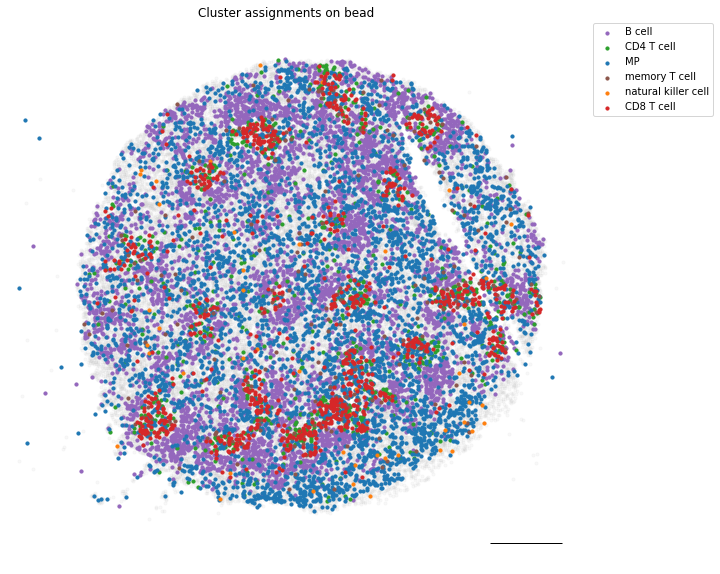

In [7]:
# Plot RCTD
point_size = 10

fig, ax = plt.subplots(figsize=(10, 10))

gray_filt = puckSpleen.s1_dge_fmtd
plt.scatter([puckSpleen.bc_loc_dict_s1[i][0] for i in gray_filt.index],
            [puckSpleen.bc_loc_dict_s1[i][1] for i in gray_filt.index],
            s=point_size,
            alpha=0.05,
            c='gray')  #c=list(marco_filt['Marco']),

fn = "{}/spleen_rctd_clusters_aging.csv".format(directory)
cluster_labels = pd.read_csv(fn)
cluster_labels['cluster'] = cluster_labels['cell_label']
cluster_num = len(list(set(cluster_labels.cluster)))

# Merge all macrophage labels
macrophage_dict = {
    'CD8 macrophage': 'MP',
    'CD4 macrophage': 'MP',
    'activated macrophage': 'MP'
}
cluster_labels.cell_label = [
    macrophage_dict[i] if i in macrophage_dict else i
    for i in cluster_labels.cell_label
]
cluster_labels.cluster = [
    macrophage_dict[i] if i in macrophage_dict else i
    for i in cluster_labels.cluster
]

groups = cluster_labels.groupby(
    "cell_label"
)  # can change to translated to visualize by translation or clonotype
cell_type_list = list(set(cluster_labels.cluster))
colors_to_use = [
    sns.color_palette('deep')[idx] for idx in range(len(cell_type_list))
]
colors_to_use_dict = {
    'CD8 T cell': sns.color_palette()[3],
    'natural killer cell': sns.color_palette()[1],
    'MP': sns.color_palette()[0],
    'memory T cell': sns.color_palette()[5],
    'CD4 T cell': sns.color_palette()[2],
    'B cell': sns.color_palette()[4]
}
# plot MP first
for name, group in groups:
    if name == 'CD8 T cell':
        continue
    plt.scatter(group["x"],
                group["y"],
                s=point_size,
                label=name,
                marker='o',
                alpha=1,
                color=colors_to_use_dict[name])

for name, group in groups:
    if name != 'CD8 T cell':
        continue
    plt.scatter(group["x"],
                group["y"],
                s=point_size,
                label=name,
                marker='o',
                alpha=1,
                color=colors_to_use_dict[name])

plt.title('Cluster assignments on bead')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([0, 6000])
plt.ylim([0, 6000])
plt.axis('off')
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           pixels_needed,
                           '',
                           'lower right',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
plt.savefig('./vectorized_figures/figure1d.pdf')
plt.show()

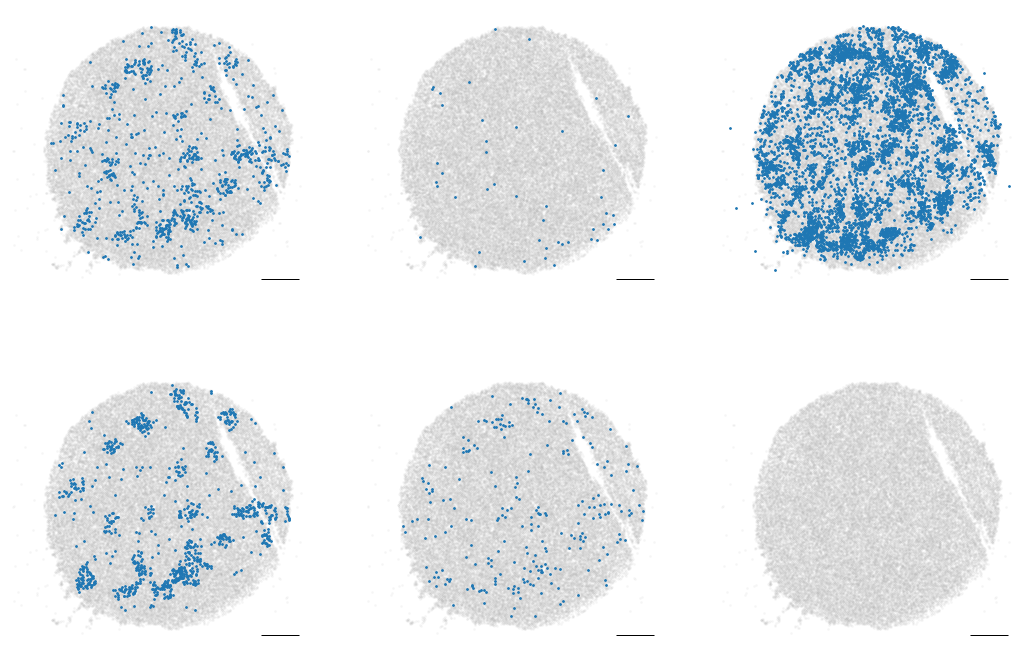

In [68]:
# Supplementary Figure 1a
fig, ax = plt.subplots(2, 3, figsize=(9 * 2, 6 * 2))

gray_filt = puckSpleen.s1_dge_fmtd
gray_filt_x = [puckSpleen.bc_loc_dict_s1[i][0] for i in gray_filt.index]
gray_filt_y = [puckSpleen.bc_loc_dict_s1[i][1] for i in gray_filt.index]

for idx in range(len(cell_type_list)):
    c = cell_type_list[idx]
    x = cluster_labels[cluster_labels.cluster == c].x
    y = cluster_labels[cluster_labels.cluster == c].y
    ax[math.floor(idx / 3), idx % 3].scatter(gray_filt_x,
                                             gray_filt_y,
                                             s=3,
                                             alpha=0.05,
                                             c='gray')
    ax[math.floor(idx / 3), idx % 3].scatter(x, y, s=3)
    ax[math.floor(idx / 3), idx % 3].axis('off')
    ax[math.floor(idx / 3), idx % 3].set_xlim([0, 6000])
    ax[math.floor(idx / 3), idx % 3].set_ylim([0, 6000])

    ######
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(ax[math.floor(idx / 3), idx % 3].transData,
                               pixels_needed,
                               '',
                               'lower right',
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax[math.floor(idx / 3), idx % 3].add_artist(scalebar)
#plt.title('Cluster assignments on bead')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis('off')
plt.savefig(
    './vectorized_figures/figure2_rctd_cell_type_assignment_{}.pdf'.format(
        puckSpleen.puck_name))
plt.show()

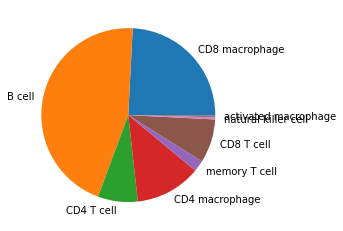

In [61]:
# Supplementary Figure 1b
plt.rcParams.update({'font.size': 10})
cter = Counter(cluster_labels.cell_label)
cell_type = list(cter.keys())
counts = list(cter.values())

#Using matplotlib
plot = plt.pie(counts, labels=cell_type)
plt.savefig('./vectorized_figures/Figure1D_pie.pdf')

# Figure 1d - Gene expression gaussian-filtered heatmap for visualizing the spatial distribution of gene markers

real life size: 91.23825
real life size: 85.84584999999998
real life size: 91.24085


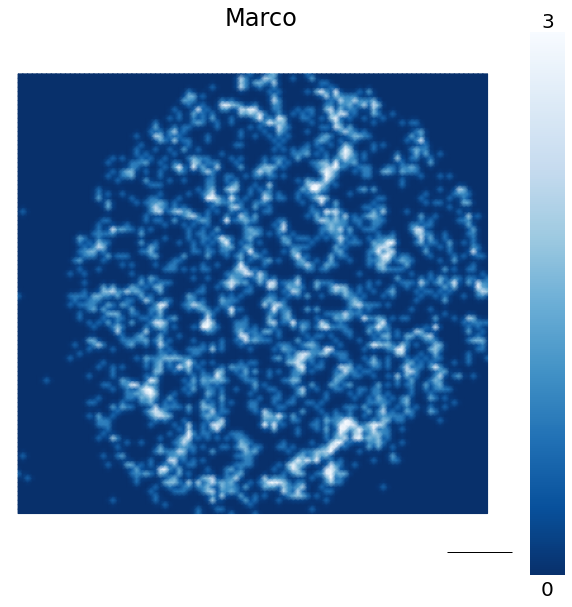

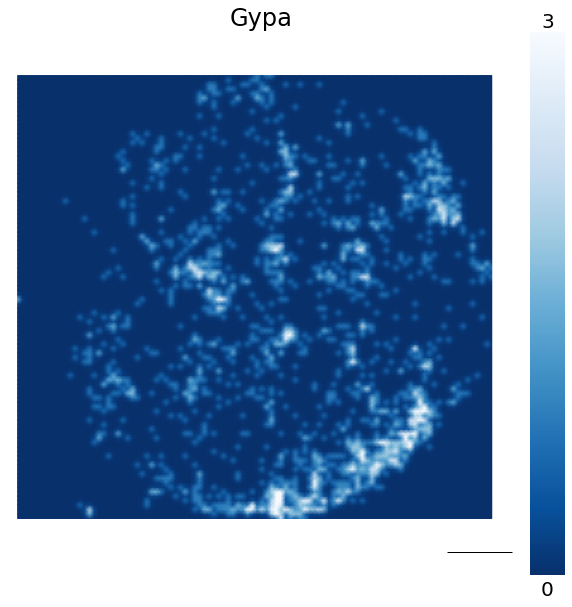

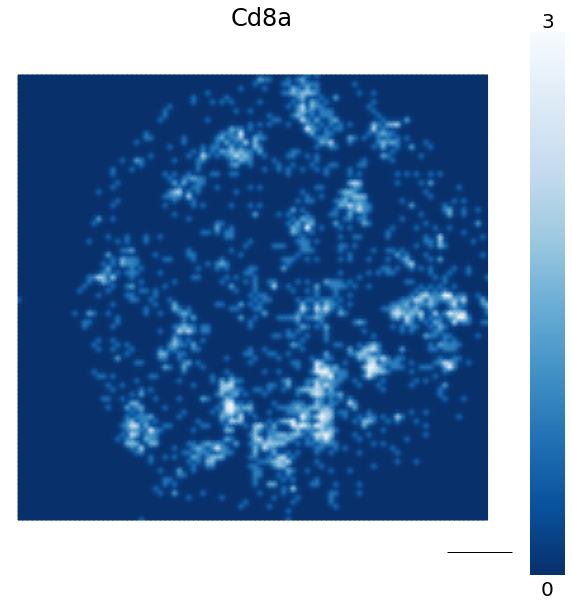

In [54]:
plt.rcParams.update({'font.size': 20})
color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

nbins = 100

for gene in ['Marco', 'Gypa', 'Cd8a']:
    gene_filt = puckSpleen.s1_dge_fmtd[puckSpleen.s1_dge_fmtd[gene] > 0]
    x = [puckSpleen.bc_loc_dict_s1[i][0] for i in gene_filt.index]
    y = [puckSpleen.bc_loc_dict_s1[i][1] for i in gene_filt.index]
    gaussian_heat_plot(x, y, 0, 3, title=True, title_text=gene)

# Figure 1e and 1f - TCR constant and variable heatmaps

real life size: 84.77595
real life size: 84.77595
real life size: 169.1837
Beta
real life size: 85.08534999999999


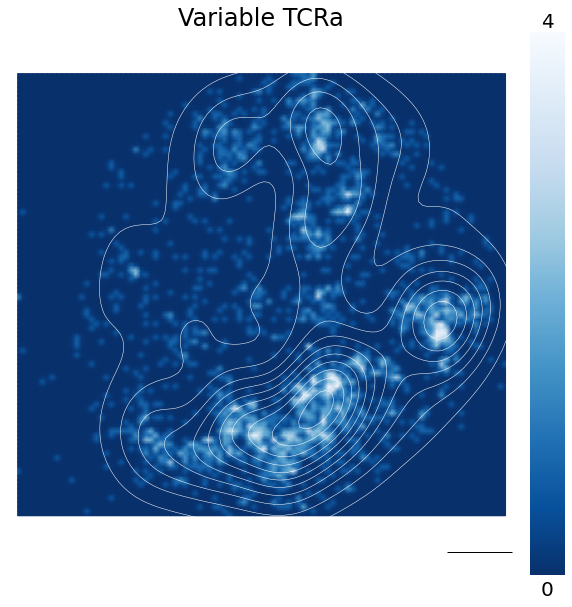

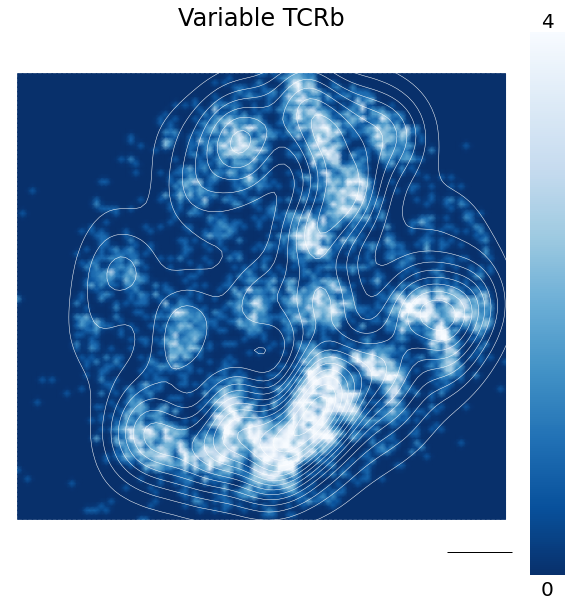

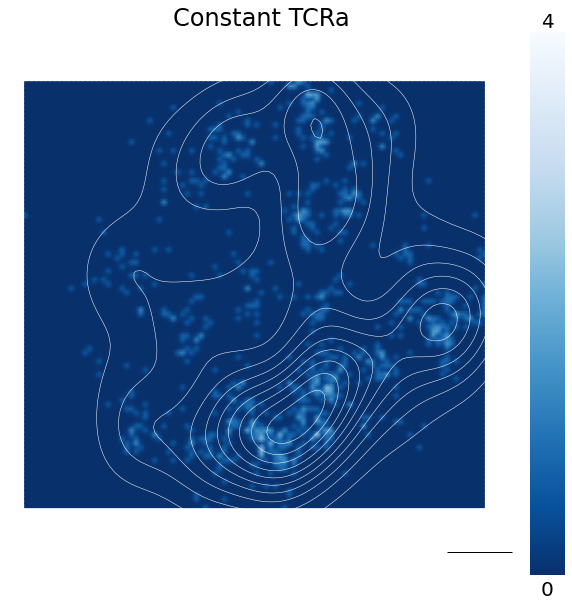

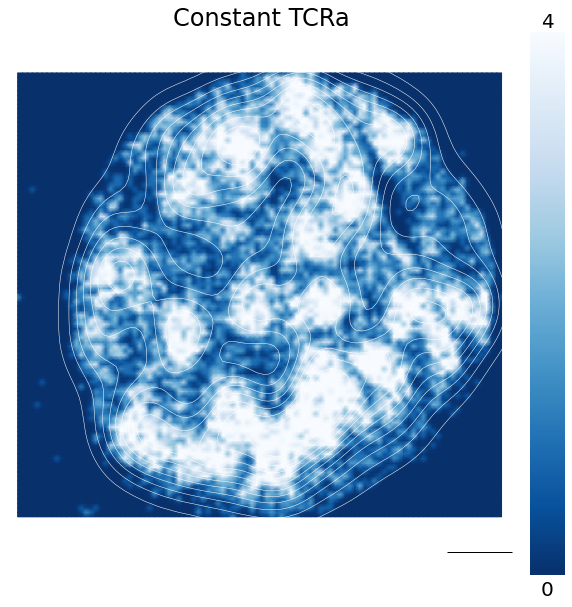

In [53]:
# Contour plot with gaussian smoothing
# Plot kdeplot on for Human or Spleen
# plot for figure
puck = puckSpleen
species = 'mouse'
if species == 'mouse':
    tcra_gene_name = 'Trac'
    tcrb_gene_name = 'Trbc2'
else:
    tcra_gene_name = 'Trac'
    tcrb_gene_name = 'Trbc2'

tcr_locs = list(set(list(sum(puck.tcr_loc_dict_s1_filtered3.values(),
                             []))))  # variable locations

tcr_locs_alpha = []  # variable locations
tcr_locs_beta = []
for tcr in puck.tcr_loc_dict_s1_filtered3:
    if tcr in puck.clonotypes['1a']:
        tcr_locs_alpha = tcr_locs_alpha + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr]))
    else:
        tcr_locs_beta = tcr_locs_beta + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr]))

color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

point_size = 20
pixels_needed = 500 / 0.65
bin_pixels = 0.65 * 6000 / nbins
bins_needed = pixels_needed / bin_pixels

gaussian_heat_plot([float(i[0]) for i in tcr_locs_alpha],
                   [float(i[1]) for i in tcr_locs_alpha],
                   vmin_val,
                   vmax_val_alpha,
                   plot_contour=True,
                   title=True,
                   title_text='Variable TCRa')
gaussian_heat_plot([float(i[0]) for i in tcr_locs_beta],
                   [float(i[1]) for i in tcr_locs_beta],
                   vmin_val,
                   vmax_val_beta,
                   plot_contour=True,
                   title=True,
                   title_text='Variable TCRb')

gene_filt = puck.s1_dge_fmtd[puck.s1_dge_fmtd[tcra_gene_name] > 0]
x = [puck.bc_loc_dict_s1[i][0] for i in gene_filt.index]
y = [puck.bc_loc_dict_s1[i][1] for i in gene_filt.index]
gaussian_heat_plot(x,
                   y,
                   vmin_val,
                   vmax_val_alpha,
                   plot_contour=True,
                   title=True,
                   title_text='Constant TCRa')

print('Beta')

gene_filt = puck.s1_dge_fmtd[puck.s1_dge_fmtd[tcrb_gene_name] > 0]
x = [puck.bc_loc_dict_s1[i][0] for i in gene_filt.index]
y = [puck.bc_loc_dict_s1[i][1] for i in gene_filt.index]
gaussian_heat_plot(x,
                   y,
                   vmin_val,
                   vmax_val_beta,
                   plot_contour=True,
                   title=True,
                   title_text='Constant TCRa')

# Figure 1g - Variable recovery

TCR beta
10
[0.21337291854911578, 0.3862368257904526, 0.5378310214375788, 0.6507760532150776, 0.7504393673110721, 0.8292682926829268, 0.8921568627450981, 0.935251798561151, 0.9428571428571428, 1.0, [0.9807692307692307]]
TCR alpha
2
[0.6158854166666666, 0.8333333333333334, [1.0]]


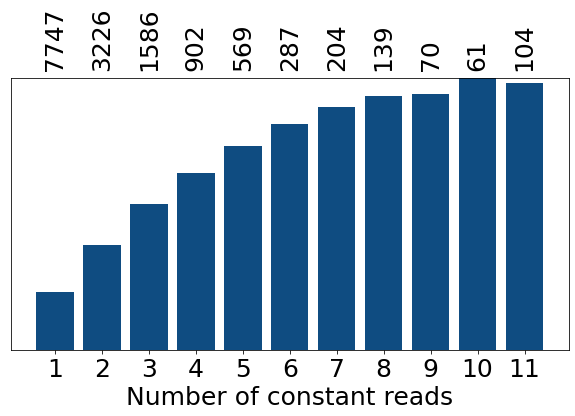

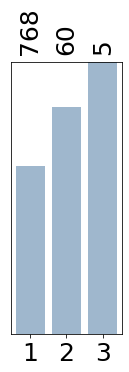

In [56]:
print('TCR beta')
plot_variable_vs_constant(puckSpleen.s1_dge_fmtd,
                          'tcr_b',
                          puckSpleen.tcr_loc_dict_s1_filtered3,
                          puckSpleen.loc_to_bc_s1,
                          human=False,
                          cutoff=10,
                          plot_histogram=False)

print('TCR alpha')
plot_variable_vs_constant(puckSpleen.s1_dge_fmtd,
                          'tcr_a',
                          puckSpleen.tcr_loc_dict_s1_filtered3,
                          puckSpleen.loc_to_bc_s1,
                          human=False,
                          cutoff=2,
                          plot_histogram=False)

# Supplementary Figure 2a-b and Supplementary Table 4

0.3714627341570347 fraction of constant that also have variable 
0.24717285945072698 new to constant


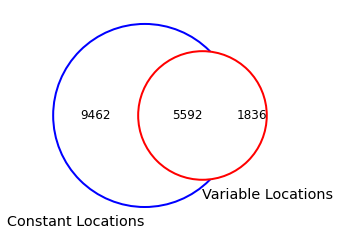

In [81]:
# Supplementary Figure 2a
plt.rcParams.update({'font.size': 12})
constant_locs = []
variable_locs = []
constant_locs = [
    puckSpleen.bc_loc_dict_s1[i]
    for i in puckSpleen.s1_dge_fmtd[(puckSpleen.s1_dge_fmtd['Trac'] > 0) | (
        puckSpleen.s1_dge_fmtd['Trbc2'] > 0)].index
]
for tcr in puckSpleen.tcr_loc_dict_s1_filtered3:
    variable_locs = variable_locs + puckSpleen.tcr_loc_dict_s1_filtered3[tcr]

constant_locs = set(constant_locs)
variable_locs = set(variable_locs)

shared_locs = set(list(constant_locs & variable_locs))
print(
    len(shared_locs) / len(constant_locs),
    'fraction of constant that also have variable ')
print(
    len([i
         for i in variable_locs if i not in shared_locs]) / len(variable_locs),
    'new to constant')

#####
set1 = constant_locs
set2 = variable_locs

v = venn2([set1, set2], ('Constant Locations', 'Variable Locations'))
c = venn2_circles([set1, set2])
c[0].set_color("white")
c[0].set_ls('solid')
c[0].set_edgecolor('blue')

c[1].set_color("white")
c[1].set_ls('solid')
c[1].set_edgecolor('red')
plt.savefig('./vectorized_figures/Supplementary Figure 1B.pdf')
plt.show()

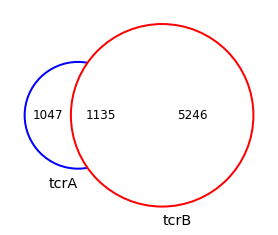

0.13254700455447857

In [86]:
# Supplementary Figure 2b
locs_all_a = []
locs_all_b = []
for cl in puckSpleen.tcr_loc_dict_s1_filtered3:
    if cl in puckSpleen.clonotypes['1a']:
        locs_all_a = locs_all_a + puckSpleen.tcr_loc_dict_s1_filtered3[cl]
    elif cl in puckSpleen.clonotypes['1b']:
        locs_all_b = locs_all_b + puckSpleen.tcr_loc_dict_s1_filtered3[cl]
        print(cl)
locs_all_a = set(locs_all_a)
locs_all_b = set(locs_all_b)

# Circos plot
df_use = puckSpleen.df_s1_filtered3

all_bc = list(puckSpleen.s1_dge_fmtd.index)
puckSpleen.df_s1
bc_s1_tcrb = set(
    [i for i in find_specific_barcodes('tcr_b', df_use) if i in all_bc])
bc_s1_tcra = set(
    [i for i in find_specific_barcodes('tcr_a', df_use) if i in all_bc])
paired_bcs = list(set(bc_s1_tcrb) & set(bc_s1_tcra))
paired_df = puckSpleen.df_s1_filtered3[(df_use.tcr_a.map(len) > 0)
                                       & (df_use.tcr_b.map(len) > 0)]

circos_plot_df = paired_df.copy(deep=True)
circos_plot_df['tcr_a'] = paired_df.tcr_a
circos_plot_df['tcr_b'] = paired_df.tcr_b

true_ot1_tcra = 'CAASDNYQLIW'
true_ot1_tcrb = 'CASSRANYEQYF'
tcr_a_hamming = []
tcr_b_hamming = []
for i in circos_plot_df['tcr_a']:
    i = ast.literal_eval(i)
    this_list = []
    for j in i:
        #         if hamming_distance(j,true_ot1_tcra) == 1:
        #             this_list.append(true_ot1_tcra)
        #         else:
        this_list.append(j)
    tcr_a_hamming.append(this_list)

for i in circos_plot_df['tcr_b']:
    i = ast.literal_eval(i)
    this_list = []
    for j in i:
        #         if hamming_distance(j,true_ot1_tcrb) == 1:
        #             this_list.append(true_ot1_tcrb)
        #         else:
        this_list.append(j)
    tcr_b_hamming.append(list(set(this_list)))

circos_plot_df['tcr_a_hamming'] = tcr_a_hamming
circos_plot_df['tcr_b_hamming'] = tcr_b_hamming

# SUPPLEMENTARY TABLE 4 IS CIRCOS_PLOT_DF

tcr_a_top = []
tcr_b_top = []
tcr_bc_counter_dict = {}  # A dictionary for counting (tcr,bc) pairs
for cl in puckSpleen.tcr_loc_dict_s1_filtered3:
    cl_name = cl
    for loc in puckSpleen.tcr_loc_dict_s1_filtered3[cl_name]:
        bc = puckSpleen.loc_to_bc_s1[loc]
        if (cl, bc) not in tcr_bc_counter_dict:
            tcr_bc_counter_dict[(cl_name, bc)] = 0
        tcr_bc_counter_dict[tuple((cl_name, bc))] += 1


def find_highest_expressing_clonotype(barcode, list_of_clonotypes):
    errors = []
    counts = 0
    cl_keep = ''
    for cl in list_of_clonotypes:
        if (cl, barcode) not in tcr_bc_counter_dict:
            errors.append((cl, barcode))
        else:
            bc_count = tcr_bc_counter_dict[(cl, barcode)]
            if bc_count > counts:
                counts = bc_count
                cl_keep = cl
        if errors != []:
            print(errors)
    return cl_keep


circos_bcs = list(circos_plot_df['bead_barcodes'])
circos_a = list(circos_plot_df['tcr_a_hamming'])
circos_b = list(circos_plot_df['tcr_b_hamming'])
circos_plot_df['tcr_a_top'] = [
    find_highest_expressing_clonotype(circos_bcs[idx], circos_a[idx])
    for idx in range(len(circos_plot_df))
]
circos_plot_df['tcr_b_top'] = [
    find_highest_expressing_clonotype(circos_bcs[idx], circos_b[idx])
    for idx in range(len(circos_plot_df))
]

# circos_plot_df['tcr_a_hamming'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
circos_plot_df = circos_plot_df.groupby(
    by=["tcr_a_top", "tcr_b_top"]).count()[["bead_barcodes"
                                            ]].rename(columns={
                                                "bead_barcodes": "Count"
                                            }).reset_index()

# Plot pairing
plt.rcParams.update({'font.size': 12})
all_bc = list(puckSpleen.s1_dge_fmtd.index)
bc_s1_tcrb = locs_all_b
bc_s1_tcra = locs_all_a
paired_bcs = list(set(bc_s1_tcrb) & set(bc_s1_tcra))
# Second way
v = venn2([bc_s1_tcra, bc_s1_tcrb], set_labels=['tcrA', 'tcrB'])
c = venn2_circles([bc_s1_tcra, bc_s1_tcrb])
c[0].set_color("white")
c[0].set_ls('solid')
c[0].set_edgecolor('blue')

c[1].set_color("white")
c[1].set_ls('solid')
c[1].set_edgecolor('red')

plt.savefig('./vectorized_figures/Supplementary Figure 1B.pdf')
plt.show()
len(paired_bcs) / (len(bc_s1_tcrb) + len(bc_s1_tcra))

# Supplementary Figure 2c-e

In [ ]:
# Find beads with constant Alpha or Beta sequence
puck = puckSpleen
constant_seq_present = puck.s1_dge_fmtd[(puck.s1_dge_fmtd['Trac'] > 0) |
                                        (puck.s1_dge_fmtd['Trbc2'] > 0)]
constant_seq_present_tcra_tcrb_sum = constant_seq_present[
    'Trac'] + constant_seq_present['Trbc2']
constant_seq_present_bcs = []
for bc in constant_seq_present.index:
    constant_seq_present_bcs = constant_seq_present_bcs + [bc]

# Find beads with variable Alpha or Beta sequence
variable_seq_present = []
for tcr in puck.tcr_loc_dict_s1_filtered3:
    for loc in set(puck.tcr_loc_dict_s1_filtered3[tcr]):
        variable_seq_present.append(loc)
variable_seq_present = list(set(variable_seq_present))

cmap_to_use = sns.color_palette("rocket", as_cmap=True)
## Constant
x = [i[0] for i in [puck.bc_loc_dict_s1[i] for i in constant_seq_present_bcs]]
y = [i[1] for i in [puck.bc_loc_dict_s1[i] for i in constant_seq_present_bcs]]
heatmap_constant, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure()
plt.imshow(heatmap_constant.T, extent=extent, cmap=cmap_to_use, origin='lower')
plt.colorbar()
plt.title('Constant')
plt.savefig('./vectorized_figures/Supplementary Figure 2A.pdf')

## Variable
x_var = [i[0] for i in variable_seq_present]
y_var = [i[1] for i in variable_seq_present]
heatmap_variable, xedges, yedges = np.histogram2d(x_var, y_var, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure()
plt.imshow(heatmap_variable.T, extent=extent, cmap=cmap_to_use, origin='lower')
plt.colorbar()
plt.title('Variable')
plt.savefig('./vectorized_figures/Supplementary Figure 2B.pdf')

## Plot correlation between the two
plt.rcParams.update({'font.size': 22})

x = heatmap_constant.reshape(-1)
y = heatmap_variable.reshape(-1)

plt.figure()
plt.scatter(x, y, alpha=0.1)
abline(scipy.stats.linregress(x, y)[0], scipy.stats.linregress(x, y)[1])
print(scipy.stats.linregress(x, y))
plt.xlabel('constant')
plt.ylabel('variable')
plt.savefig('./vectorized_figures/Supplementary Figure 2C.pdf')

# Load in RCC pucks

In [53]:
# Post-treatment RCC
# For resave and resave_sparse
# Set True if this is your first time loading a puck.
# Otherwise you can set to False.

# puck8 = PuckReplicate(puck_name='2020-09-02_Puck_200727_08',
#                       genome='hg19',
#                       clonotype_sample_name='B10_8',
#                       clonotype_fastq_name='B10-8_S1',
#                       umi_filter_number=1,
#                       resave=False,
#                       resave_sparse=False)

# puck9 = PuckReplicate(puck_name='2020-09-02_Puck_200727_09',
#                       genome='hg19',
#                       clonotype_sample_name='B10_9',
#                       clonotype_fastq_name='B10-9_S2',
#                       umi_filter_number=1,
#                       resave=False,
#                       resave_sparse=False)

puck10 = PuckReplicate(puck_name='2020-09-02_Puck_200727_10',
                       genome='hg19',
                       clonotype_sample_name='B10_10',
                       clonotype_fastq_name='B10-10_S1',
                       umi_filter_number=1,
                       resave=False,
                       resave_sparse=False)

# puck12 = PuckReplicate(puck_name='2020-09-02_Puck_200727_12',
#                        genome='hg19',
#                        clonotype_sample_name='B10_12',
#                        clonotype_fastq_name='B10-12_S1',
#                        umi_filter_number=1,
#                        resave=False,
#                        resave_sparse=False)

# puck13 = PuckReplicate(puck_name='2020-09-02_Puck_200727_13',
#                        genome='hg19',
#                        clonotype_sample_name='B10_13',
#                        clonotype_fastq_name='B10-13_S2',
#                        umi_filter_number=1,
#                        resave=False,
#                        resave_sparse=False)

  0%|          | 0/119043 [00:00<?, ?it/s]

  0%|          | 0/758 [00:00<?, ?it/s]

673 total to analyze


  0%|          | 0/673 [00:00<?, ?it/s]

# Figure 2b - Spatial reconstruction of Slide-TCR-seq array (RCC) and Supplementary Figure 3a

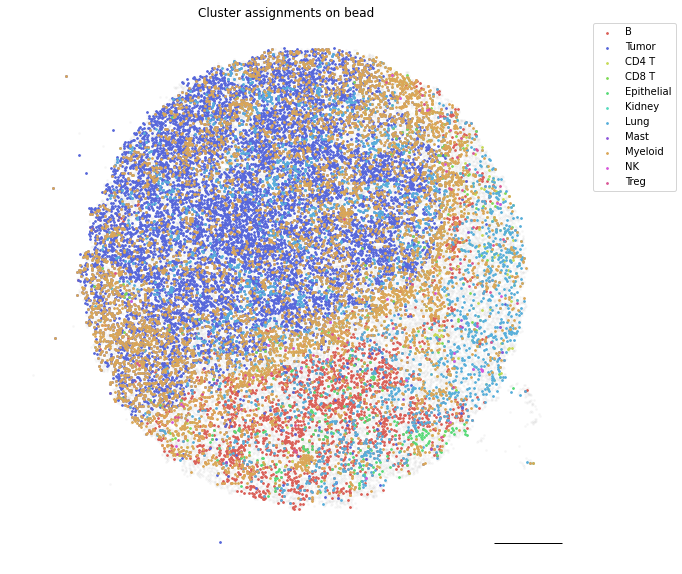

In [9]:
# Plot RCTD
puck = puck8

condensed_cell_type_names = {
    'Bcell': 'B',
    'MastCell': 'Mast',
    'MyeloidCell_02_CD11c_CD14': 'Myeloid',
    'Myeloid_01_CD11c': 'Myeloid',
    'Myeloid_03_CD16': 'Myeloid',
    'Myeloid_04_CD14_CD16': 'Myeloid',
    'Myeloid_DC1_CD141': 'Myeloid',
    'Myeloid_pDC': 'Myeloid',
    'NK': 'NK',
    'NKT': 'NK',
    'NonImmuneCell': 'Lung',
    'PlasmaCell': 'B',
    'Tcell_CD4': 'CD4 T',
    'Tcell_CD8': 'CD8 T',
    'Tcell_Treg': 'Treg',
    'TumorCell_CA9': 'Tumor',
    'Kidney_DistalTubule': 'Kidney',
    'Kidney_ProximalTubule': 'Kidney',
    'Epithelial_EPCAM': 'Epithelial'
}

point_size = 3

fig, ax = plt.subplots(figsize=(10, 10))

gray_filt = puck.s1_dge_fmtd
plt.scatter([puck.bc_loc_dict_s1[i][0] for i in gray_filt.index],
            [puck.bc_loc_dict_s1[i][1] for i in gray_filt.index],
            s=point_size,
            alpha=0.05,
            c='gray')  #c=list(marco_filt['Marco']),

fn = "./vectorized_figures/rcc_rctd_clusters_{}.csv".format(puck.puck_name)
cluster_labels = pd.read_csv(fn)
cluster_labels['cluster'] = cluster_labels['cell_label']

cluster_num = len(list(set(cluster_labels.cluster)))

cell_type_list = sorted(list(set(list(condensed_cell_type_names.values()))))
# move myeloid to position 1 for coloring and tumor to purple
cell_type_list.remove('Myeloid')
cell_type_list.insert(1, 'Myeloid')
cell_type_list.remove('Tumor')
cell_type_list.insert(7, 'Tumor')

cluster_labels['condensed'] = [
    condensed_cell_type_names[i] for i in cluster_labels['cluster']
]
colors_to_use_condensed = [
    sns.color_palette('hls', len(cell_type_list))[idx]
    for idx in range(len(cell_type_list))
]

groups = cluster_labels.groupby(
    "cell_label"
)  # can change to translated to visualize by translation or clonotype
groups_condensed = cluster_labels.groupby(
    "condensed"
)  # can change to translated to visualize by translation or clonotype
# for name, group in groups: #Plot tumor first
#     if name in ['TumorCell_CA9','PlasmaCell','Bcell']:
#         plt.scatter(group["x"], group["y"],s=point_size, label=name,marker = 'o',alpha = 1,color = colors_to_use[cell_type_list.index(name)])

# for name, group in groups:
#     if name not in ['TumorCell_CA9','PlasmaCell','Bcell']:
#         plt.scatter(group["x"], group["y"],s=point_size, label=name,marker = 'o',alpha = 1,color = colors_to_use[cell_type_list.index(name)])

# # for name, group in groups:
# #     if name in ['Tcell_CD4','Tcell_CD8','Tcell_Treg']:
# #         plt.scatter(group["x"], group["y"],s=point_size, label=name,marker = 'o',alpha = 1,color = colors_to_use[cell_type_list.index(name)])

##### CONDENSED VERSIONS

for name, group in groups_condensed:  #Plot tumor first
    if name in ['Tumor', 'B']:
        plt.scatter(group["x"],
                    group["y"],
                    s=point_size,
                    label=name,
                    marker='o',
                    alpha=1,
                    color=colors_to_use_condensed[cell_type_list.index(name)])

for name, group in groups_condensed:
    if name not in ['Tumor', 'B']:
        plt.scatter(group["x"],
                    group["y"],
                    s=point_size,
                    label=name,
                    marker='o',
                    alpha=1,
                    color=colors_to_use_condensed[cell_type_list.index(name)])

######
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           pixels_needed,
                           '',
                           'lower right',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

plt.title('Cluster assignments on bead')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axis('off')
plt.savefig(
    './vectorized_figures/figure2_rctd_cell_type_assignment_{}.pdf'.format(
        puck.puck_name))
plt.show()

# Supplementary Figure 3c TODO

In [43]:
# Plot each cell type individually

num_plots_one_dim = int(round(np.sqrt(len(set(cluster_labels.condensed)))))
fig, ax = plt.subplots(num_plots_one_dim,
                       num_plots_one_dim + 1,
                       figsize=(8 * 2, 6 * 2))

gray_filt = puck.s1_dge_fmtd
gray_filt_x = [puck.bc_loc_dict_s1[i][0] for i in gray_filt.index]
gray_filt_y = [puck.bc_loc_dict_s1[i][1] for i in gray_filt.index]

for idx in range(len(cell_type_list)):
    c = cell_type_list[idx]
    x = cluster_labels[cluster_labels.condensed == c].x
    y = cluster_labels[cluster_labels.condensed == c].y
    ax[math.floor(idx / 4), idx % 4].scatter(gray_filt_x,
                                             gray_filt_y,
                                             s=3,
                                             alpha=0.05,
                                             c='gray')
    ax[math.floor(idx / 4), idx % 4].scatter(x, y, s=2)
    ax[math.floor(idx / 4), idx % 4].axis('off')
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(ax[math.floor(idx / 4), idx % 4].transData,
                               pixels_needed,
                               '',
                               'lower right',
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax[math.floor(idx / 4), idx % 4].add_artist(scalebar)

    #ax[math.floor(idx/4),idx%4].set_title(c)
    plt.savefig('./vectorized_figures/sf3a_puckSpleen.pdf')

AttributeError: 'DataFrame' object has no attribute 'condensed'

# Supplementary Table 6

In [ ]:
# To make Supplementary Table 6
tcrs_all = {}
for puck in [puck12, puck13]:
    for tcr in puck.tcr_loc_dict_s1_filtered3:
        if tcr not in puck.clonotypes['1b']:
            continue
        if tcr not in tcrs_all:
            tcrs_all[tcr] = []
        tcrs_all[tcr] = tcrs_all[tcr] + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr])
        )  # fraction of beads, not umis
sum_all = 0
for tcr in tcrs_all:
    sum_all += len(tcrs_all[tcr])

tcr_name = []
fraction_all = []
for tcr in tcrs_all:
    if len(tcrs_all[tcr]) == 0:
        continue
    fraction = len(tcrs_all[tcr]) / sum_all
    #     if fraction > 0.09: #tcr == 'CASSVTGETGELFF':
    #print(fraction,tcr)
    tcr_name.append(tcr)
    fraction_all.append(fraction)

clonotype_fractions = pd.DataFrame.from_dict({
    'clonotype': tcr_name,
    'fraction': fraction_all
})
clonotype_fractions.sort_values('fraction', ascending=False, inplace=True)
clonotype_fractions.reset_index(inplace=True)
clonotype_fractions.drop(columns=['index'], inplace=True)
#clonotype_fractions['name'] = ['TCR-'+str(i+1) for i in clonotype_fractions.index]
clonotype_fractions['name'] = [
    'TCR-' + str(i + 1133) for i in clonotype_fractions.index
]
clonotype_fractions.to_csv(
    '{}pre_treatment_clonotype_fraction_slide_seq.csv'.format(directory))

# Fraction calculation for betas for each clonotype across all pucks
tcrs_all = {}
for puck in [puck8, puck9, puck10]:
    for tcr in puck.tcr_loc_dict_s1_filtered3:
        if tcr not in puck.clonotypes['1b']:
            continue
        if tcr not in tcrs_all:
            tcrs_all[tcr] = []
        tcrs_all[tcr] = tcrs_all[tcr] + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr])
        )  # fraction of beads, not umis
sum_all = 0
for tcr in tcrs_all:
    sum_all += len(tcrs_all[tcr])

tcr_name = []
fraction_all = []
for tcr in tcrs_all:
    if len(tcrs_all[tcr]) == 0:
        continue
    fraction = len(tcrs_all[tcr]) / sum_all
    #     if fraction > 0.09: #tcr == 'CASSVTGETGELFF':
    #print(fraction,tcr)
    tcr_name.append(tcr)
    fraction_all.append(fraction)

clonotype_fractions = pd.DataFrame.from_dict({
    'clonotype': tcr_name,
    'fraction': fraction_all
})
clonotype_fractions.sort_values('fraction', ascending=False, inplace=True)
clonotype_fractions.reset_index(inplace=True)
clonotype_fractions.drop(columns=['index'], inplace=True)
#clonotype_fractions['name'] = ['TCR-'+str(i+1) for i in clonotype_fractions.index]
clonotype_fractions['name'] = [
    'TCR-' + str(i + 1133) for i in clonotype_fractions.index
]
clonotype_fractions.to_csv(
    '{}post_treatment_clonotype_fraction_slide_seq.csv'.format(directory))

# Figure 2c -  Cumulative distribution function (CDF) showing the diversity and abundance of clonotypes and Supplementary Figure 4

In [20]:
# Load bulk data
pre_bulk_beta = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                              sheet_name='RCCpre Beta')
post_bulk_beta = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                               sheet_name='RCCpost Beta')
pre_bulk_alpha = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                               sheet_name='RCCpre Alpha')
post_bulk_alpha = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                                sheet_name='RCCpost Alpha')

# pre_bulk_beta = pre_bulk_beta[pre_bulk_beta.count_sum >=10]
# post_bulk_beta = post_bulk_beta[post_bulk_beta.count_sum >=10]

(0.7488400462106771, 1.6991214825484169e-12)

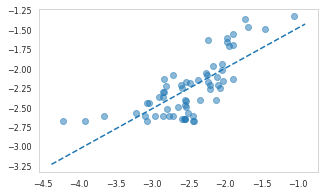

In [37]:
# Supplementary Figure 4a
pre_treatment_df = pd.read_csv(
    '{}pre_treatment_clonotype_fraction_slide_seq.csv'.format(directory))
post_treatment_df = pd.read_csv(
    '{}post_treatment_clonotype_fraction_slide_seq.csv'.format(directory))
post_treatment_df = post_treatment_df[
    post_treatment_df.fraction > 0.00018889308651303364 *
    10]  # To filter for at least 10 counts in Slide-seq
pre_treatment_dict = dict(
    zip(pre_treatment_df.clonotype, pre_treatment_df.fraction))
pre_treatment_dict_bulk = dict(zip(pre_bulk_beta.cdr3, pre_bulk_beta.Freq))

post_treatment_dict = dict(
    zip(post_treatment_df.clonotype, post_treatment_df.fraction))
post_treatment_dict_bulk = dict(zip(post_bulk_beta.cdr3, post_bulk_beta.Freq))

values_in_slide_seq = []
values_in_bulk = []
for cl in post_treatment_dict:
    if cl in post_treatment_dict_bulk:
        values_in_slide_seq.append(post_treatment_dict[cl])
        values_in_bulk.append(post_treatment_dict_bulk[cl])

x = np.log10(values_in_bulk)
y = np.log10(values_in_slide_seq)
fig, ax = plt.subplots(figsize=(5, 3))
plt.scatter(x, y, alpha=0.5)
x_vals = np.array(ax.get_xlim())
y_vals = scipy.stats.linregress(
    x, y)[1] + scipy.stats.linregress(x, y)[0] * x_vals
ax.plot(x_vals, y_vals, '--')
plt.savefig('{}sf3d_post.pdf'.format(directory))
pearsonr(x, y)

r 0.41394283000776283 pval 1.7621930963589905e-06
r 0.36326404923903477 pval 3.914446680973196e-05
r 0.3522754010943085 pval 0.00018479060136278647


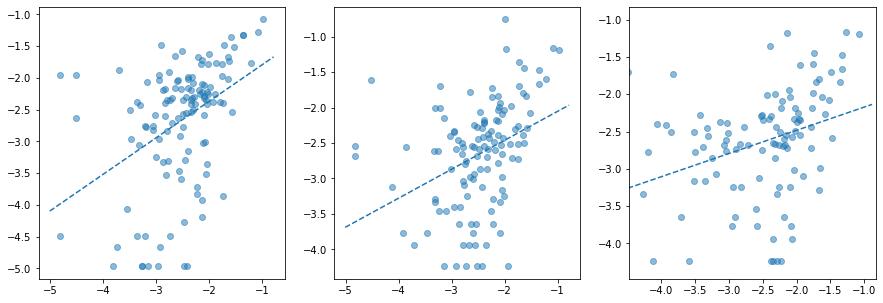

In [18]:
# Supplementary Figure 4b

puck8.total_reads = sum(puck8.s1_total_counts)
puck9.total_reads = sum(puck9.s1_total_counts)
puck10.total_reads = sum(puck10.s1_total_counts)

puck8.total_cl_counts = 0
puck9.total_cl_counts = 0
puck10.total_cl_counts = 0

puck8_umi_cl_counts = []
puck9_umi_cl_counts = []
for cl in puck8.tcr_loc_dict_s1_filtered3:
    if cl in puck9.tcr_loc_dict_s1_filtered3:
        if len(puck8.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        if len(puck9.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        puck8.total_cl_counts += len(puck8.tcr_loc_dict_s1_filtered3[cl])
        puck9.total_cl_counts += len(puck9.tcr_loc_dict_s1_filtered3[cl])
        puck8_umi_cl_counts.append(len(puck8.tcr_loc_dict_s1_filtered3[cl]))
        puck9_umi_cl_counts.append(len(puck9.tcr_loc_dict_s1_filtered3[cl]))

puck8_umi_cl_counts_vs10 = []
puck10_umi_cl_counts = []
for cl in puck8.tcr_loc_dict_s1_filtered3:
    if cl in puck10.tcr_loc_dict_s1_filtered3:
        if len(puck8.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        if len(puck10.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        puck8_umi_cl_counts_vs10.append(
            len(puck8.tcr_loc_dict_s1_filtered3[cl]))
        puck10.total_cl_counts += len(puck10.tcr_loc_dict_s1_filtered3[cl])
        puck10_umi_cl_counts.append(len(puck10.tcr_loc_dict_s1_filtered3[cl]))

puck9_umi_cl_counts_vs10 = []
puck10_umi_cl_counts_vs9 = []
for cl in puck9.tcr_loc_dict_s1_filtered3:
    if cl in puck10.tcr_loc_dict_s1_filtered3:
        if len(puck9.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        if len(puck10.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue

        puck9_umi_cl_counts_vs10.append(
            len(puck9.tcr_loc_dict_s1_filtered3[cl]))
        puck10_umi_cl_counts_vs9.append(
            len(puck10.tcr_loc_dict_s1_filtered3[cl]))


def normalize_by_total_reads(list_name, total_reads):
    return [i / total_reads for i in list_name]


puck8_umi_cl_counts = normalize_by_total_reads(puck8_umi_cl_counts,
                                               puck8.total_cl_counts)
puck8_umi_cl_counts_vs10 = normalize_by_total_reads(puck8_umi_cl_counts_vs10,
                                                    puck8.total_cl_counts)
puck9_umi_cl_counts = normalize_by_total_reads(puck9_umi_cl_counts,
                                               puck9.total_cl_counts)
puck9_umi_cl_counts_vs10 = normalize_by_total_reads(puck9_umi_cl_counts_vs10,
                                                    puck9.total_cl_counts)
puck10_umi_cl_counts = normalize_by_total_reads(puck10_umi_cl_counts,
                                                puck10.total_cl_counts)
puck10_umi_cl_counts_vs9 = normalize_by_total_reads(puck10_umi_cl_counts_vs9,
                                                    puck10.total_cl_counts)

puck8_umi_cl_counts = np.log10(puck8_umi_cl_counts)
puck9_umi_cl_counts = np.log10(puck9_umi_cl_counts)
puck10_umi_cl_counts = np.log10(puck10_umi_cl_counts)
puck8_umi_cl_counts_vs10 = np.log10(puck8_umi_cl_counts_vs10)
puck9_umi_cl_counts_vs10 = np.log10(puck9_umi_cl_counts_vs10)
puck10_umi_cl_counts_vs9 = np.log10(puck10_umi_cl_counts_vs9)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(puck8_umi_cl_counts,
            puck9_umi_cl_counts,
            label='8 vs 9',
            alpha=0.5)
ax2.scatter(puck8_umi_cl_counts_vs10,
            puck10_umi_cl_counts,
            label='8 vs 10',
            alpha=0.5)
ax3.scatter(puck9_umi_cl_counts_vs10,
            puck10_umi_cl_counts_vs9,
            label='9 vs 10',
            alpha=0.5)
# plt.legend()

abline(scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[0],
       scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[1],
       ax_name=ax1)
abline(scipy.stats.linregress(puck8_umi_cl_counts_vs10,
                              puck10_umi_cl_counts)[0],
       scipy.stats.linregress(puck8_umi_cl_counts_vs10,
                              puck10_umi_cl_counts)[1],
       ax_name=ax2)
abline(scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                              puck10_umi_cl_counts_vs9)[0],
       scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                              puck10_umi_cl_counts_vs9)[1],
       ax_name=ax3)

print('r',
      scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[2],
      'pval',
      scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[3])
print(
    'r',
    scipy.stats.linregress(puck8_umi_cl_counts_vs10, puck10_umi_cl_counts)[2],
    'pval',
    scipy.stats.linregress(puck8_umi_cl_counts_vs10, puck10_umi_cl_counts)[3])
print(
    'r',
    scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                           puck10_umi_cl_counts_vs9)[2], 'pval',
    scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                           puck10_umi_cl_counts_vs9)[3])

args = (puck9_umi_cl_counts_vs10, puck10_umi_cl_counts_vs9,
        puck8_umi_cl_counts_vs10, puck10_umi_cl_counts, puck8_umi_cl_counts,
        puck9_umi_cl_counts)
all_counts = np.concatenate(args)

max_val = max(all_counts)
min_val = min(all_counts)
plt.xlim([min_val * 0.9, max_val * 1.1])
plt.ylim([min_val * 0.9, max_val * 1.1])
plt.savefig('./vectorized_figures/sf3c.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

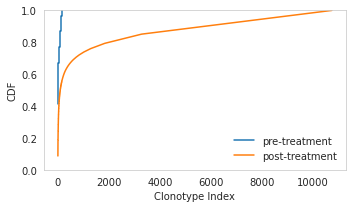

In [23]:
# Supplementary Figure 4c
# CDF for bulk
# Histogram of percent of all beads vs clonotype
plt.figure()
pre_bulk_cdf = list(
    pre_bulk_beta.sort_values('Freq', ascending=False).cumsum()['Freq'])
post_bulk_cdf = list(
    post_bulk_beta.sort_values('Freq', ascending=False).cumsum()['Freq'])
sns.set_style("whitegrid", {'axes.grid': False})

plt.figure(figsize=(5, 3))
plt.step(range(len(pre_bulk_cdf)), pre_bulk_cdf, label='pre-treatment')
plt.step(range(len(post_bulk_cdf)), post_bulk_cdf, label='post-treatment')
plt.ylim([0, 1])
plt.xlabel('Clonotype Index')
plt.ylabel('CDF')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('./vectorized_figures/supp_figure4a.pdf')

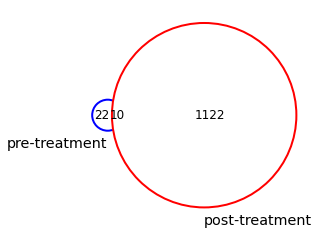

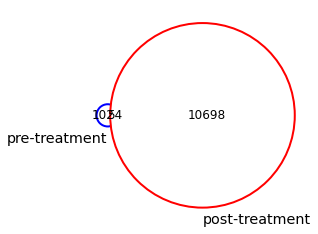

In [21]:
# Supplementary Figure 4d
pre_treatment_df = pd.read_csv(
    './vectorized_figures/pre_treatment_clonotype_fraction_slide_seq.csv')
post_treatment_df = pd.read_csv(
    './vectorized_figures/post_treatment_clonotype_fraction_slide_seq.csv')


def clono_vd(pre_list, post_list, labels, filename):
    plt.rcParams.update({'font.size': 12})
    set1 = set(pre_list)
    set2 = set(post_list)

    v = venn2([set1, set2], labels)
    c = venn2_circles([set1, set2])
    c[0].set_color("white")
    c[0].set_ls('solid')
    c[0].set_edgecolor('blue')

    c[1].set_color("white")
    c[1].set_ls('solid')
    c[1].set_edgecolor('red')
    plt.savefig(filename)
    plt.show()


clono_vd(list(pre_treatment_df.clonotype),
         list(post_treatment_df.clonotype),
         ('pre-treatment', 'post-treatment'),
         filename='./vectorized_figures/Supplementary Figure 5B_slide_seq.pdf')
clono_vd(list(pre_bulk_beta.cdr3),
         list(post_bulk_beta.cdr3), ('pre-treatment', 'post-treatment'),
         filename='./vectorized_figures/Supplementary Figure 5B_bulk.pdf')

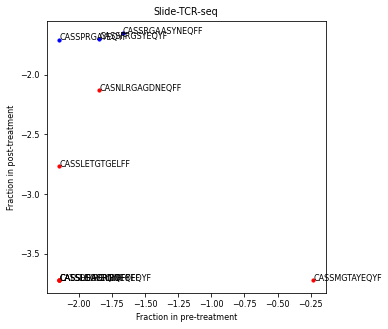

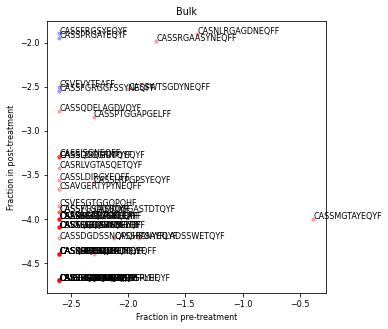

In [25]:
# Supplementary Figure 4e

plt.rcParams.update({'font.size': 8})
shared_test = list(
    set(pre_treatment_df.clonotype) & set(post_treatment_df.clonotype))
x = []
y = []
for i in shared_test:
    x.append(float(pre_treatment_df[pre_treatment_df.clonotype == i].fraction))
    y.append(
        float(post_treatment_df[post_treatment_df.clonotype == i].fraction))

x_pre_higher = []
y_pre_higher = []
x_post_higher = []
y_post_higher = []

for (xid, yid) in zip(x, y):
    if xid > yid:
        x_pre_higher.append(xid)
        y_pre_higher.append(yid)
    else:
        x_post_higher.append(xid)
        y_post_higher.append(yid)

x_pre_higher = np.log10(x_pre_higher)
y_pre_higher = np.log10(y_pre_higher)
x_post_higher = np.log10(x_post_higher)
y_post_higher = np.log10(y_post_higher)

fig, ax = plt.subplots(figsize=(5, 5))
#plt.scatter(x,y)
plt.scatter(x_pre_higher,
            y_pre_higher,
            c='red',
            s=10,
            label='Higher clonotype fraction in pre-treatment')
plt.scatter(x_post_higher,
            y_post_higher,
            c='blue',
            s=10,
            label='Higher clonotype fraction in post-treatment')
plt.title('Slide-TCR-seq')
for i, txt in enumerate(shared_test):
    #ax.annotate(txt, (x[i], y[i]))
    ax.annotate(txt, (np.log10(x[i]), np.log10(y[i])))
plt.xlabel('Fraction in pre-treatment')
plt.ylabel('Fraction in post-treatment')
plt.savefig('./vectorized_figures/sf5c.pdf')

#### BULK
# PLOT CHANGES IN CLONOTYPE FRACTIONS FOR SHARED CLONOTYPES AND ALL CLONOTYPES for slide-seq and bulk
plt.rcParams.update({'font.size': 8})
shared_test = list(set(pre_bulk_beta.cdr3) & set(post_bulk_beta.cdr3))
x = []
y = []
for i in shared_test:
    x.append(float(pre_bulk_beta[pre_bulk_beta.cdr3 == i].Freq))
    y.append(float(post_bulk_beta[post_bulk_beta.cdr3 == i].Freq))

x_pre_higher = []
y_pre_higher = []
x_post_higher = []
y_post_higher = []

for (xid, yid) in zip(x, y):
    if xid > yid:
        x_pre_higher.append(xid)
        y_pre_higher.append(yid)
    else:
        x_post_higher.append(xid)
        y_post_higher.append(yid)

x_pre_higher = np.log10(x_pre_higher)
y_pre_higher = np.log10(y_pre_higher)
x_post_higher = np.log10(x_post_higher)
y_post_higher = np.log10(y_post_higher)

fig, ax = plt.subplots(figsize=(5, 5))
#plt.scatter(x,y)
plt.scatter(x_pre_higher,
            y_pre_higher,
            c='red',
            s=10,
            label='Higher clonotype fraction in pre-treatment',
            alpha=0.3)
plt.scatter(x_post_higher,
            y_post_higher,
            c='blue',
            s=10,
            label='Higher clonotype fraction in post-treatment',
            alpha=0.3)
plt.title('Bulk')
for i, txt in enumerate(shared_test):
    #ax.annotate(txt, (x[i], y[i]))
    ax.annotate(txt, (np.log10(x[i]), np.log10(y[i])))
plt.xlabel('Fraction in pre-treatment')
plt.ylabel('Fraction in post-treatment')
plt.savefig('./vectorized_figures/sf5c_bulk.pdf')

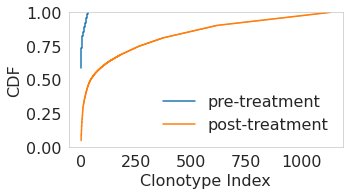

In [29]:
# Figure 2c
pre_treatment_df = pd.read_csv(
    '{}pre_treatment_clonotype_fraction_slide_seq.csv'.format(directory))
post_treatment_df = pd.read_csv(
    '{}post_treatment_clonotype_fraction_slide_seq.csv'.format(directory))

# Histogram of percent of all beads vs clonotype
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(5, 3))
plt.step(range(len(cumsum_12)), cumsum_12, label='pre-treatment')
plt.step(range(len(cumsum_10)), cumsum_10, label='post-treatment')
plt.ylim([0, 1])
plt.xlabel('Clonotype Index')
plt.ylabel('CDF')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('./vectorized_figures/figure2e.pdf')

# Figure 2d - Compartment assignment

In [75]:
# Make the assignments
def make_knn_assignments(rctd_filename, puck_abbreviation, puck,
                         cluster_num_to_name_list, cell_type_list):

    cluster_num_to_name_dict = {
        idx: cluster_num_to_name_list[idx]
        for idx in range(len(cluster_num_to_name_list))
    }

    puck.all_locs = list(puck.loc_to_bc_s1.keys())
    aggregated_clusters = pd.read_csv(fn)
    rep = [i.split('_')[0] for i in list(aggregated_clusters.barcode)]
    barcode = [i.split('_')[1] for i in list(aggregated_clusters.barcode)]
    aggregated_clusters['rep'] = rep
    aggregated_clusters['barcode'] = barcode

    cluster_labels = aggregated_clusters[aggregated_clusters.rep ==
                                         puck_abbreviation]

    cluster_num = len(list(set(cluster_labels.cluster)))
    cluster_labels['x'] = [
        puck.bc_loc_dict_s1[bc][0] for bc in cluster_labels.barcode
    ]
    cluster_labels['y'] = [
        puck.bc_loc_dict_s1[bc][1] for bc in cluster_labels.barcode
    ]

    bc_to_cluster_label_dict = dict(
        zip(cluster_labels.barcode, cluster_labels.cluster))
    loc_to_cluster_dict = {
        puck.bc_loc_dict_s1[i]: bc_to_cluster_label_dict[i]
        for i in list(bc_to_cluster_label_dict.keys())
    }

    x_1 = [float(i[0]) for i in loc_to_cluster_dict]
    y_1 = [float(i[1]) for i in loc_to_cluster_dict]
    c_1 = [loc_to_cluster_dict[i] for i in loc_to_cluster_dict]

    cluster_labels['cluster_name'] = [
        cluster_num_to_name_list[i] for i in cluster_labels.cluster
    ]
    # Load in cell type assignments for posttreatment
    # Perform KNN to assign tumor, lung, and TIL regions

    ###### KNN Classifier
    loc_cluster_dict = {}
    loc_cluster_dict_all = {}

    #cell_type_list = ['Tumor','Normal']
    #cell_type_list = ['TumorCell_CA9','NonImmuneCell','PlasmaCell']

    for index, row in cluster_labels.iterrows():
        loc_cluster_dict_all[(float(row['x']),
                              float(row['y']))] = row['cluster_name']
        if row['cluster_name'] in cell_type_list:
            loc_cluster_dict[(float(row['x']),
                              float(row['y']))] = row['cluster_name']

    unassigned_points = set(
        [i for i in puck.all_locs if i not in list(loc_cluster_dict.keys())])

    neigh = KNeighborsClassifier(
        n_neighbors=500
    )  # nearest neighbors was 500 for post treatment. trying 10
    print('Begin classifier process')
    X = np.array(list(loc_cluster_dict.keys()))
    y = np.array(list(loc_cluster_dict.values()))
    neigh.fit(X, y)
    cl_assignment = {}
    for pt in tqdm(unassigned_points):
        cl_assignment[pt] = neigh.predict([pt])[0]
    for pt in tqdm(loc_cluster_dict):
        cl_assignment[pt] = neigh.predict([pt])[0]

    # Plots results of classifier
    testl = []
    testtil = []
    testtu = []
    for loc in cl_assignment:
        if cl_assignment[loc] == cell_type_list[0]:
            testl.append(loc)
        if cl_assignment[loc] == cell_type_list[1]:
            testtu.append(loc)
        if cl_assignment[loc] == cell_type_list[2]:
            testtil.append(loc)

    loc_cluster_dict = copy.deepcopy(cl_assignment)
    puck.tll_loc_cluster_dict = loc_cluster_dict
    puck.tumor_beads = [
        j for j in
        [i for i in loc_cluster_dict if loc_cluster_dict[i] == 'Tumor']
    ]

    puck.loc_to_cluster_dict = loc_to_cluster_dict


# POST-TREATMENT
cluster_num_to_name_list = [
    'Tumor', 'B', 'MGP', 'RNA28S5', 'Lung', 'TIL Chemokines', 'IghM B',
    'No markers', 'Igll5 and Iglv3.25', 'No markers', 'B', 'B', 'B', 'RBC',
    'TIL Chemokines', 'B', 'B', 'B', 'B', 'B', 'B', 'Ftl', 'Tmsb4x'
]
cell_type_list = ['Lung', 'Tumor', 'TIL Chemokines']
# make_knn_assignments(
#     './Aggregated_clusterassignments.csv', 'rep8', puck8,
#     cluster_num_to_name_list,
#     cell_type_list)
# make_knn_assignments(
#     './Aggregated_clusterassignments.csv', 'rep9', puck9,
#     cluster_num_to_name_list,
#     cell_type_list)
make_knn_assignments('{}Aggregated_clusterassignments.csv'.format(directory),
                     'rep10', puck10, cluster_num_to_name_list, cell_type_list)

# PRE-TREATMENT
# cluster_num_to_name_list = [
#     'None', 'None', 'None', 'Tumor', 'None', 'None', 'None', 'None', 'None',
#     'None', 'None', 'None', 'None', 'None', 'Immune', 'None', 'None', 'None',
#     'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
#     'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None'
# ]
# cell_type_list = ['','Tumor', 'Immune']
# make_knn_assignments(
#     './Aggregated_clusterassignments_pre_treatment.csv', 'rep12', puck12,
#     cluster_num_to_name_list,
#     cell_type_list)  # CHANGE TO 'REP# AND PUCK# FOR DIFFERENT PUCKS'

/home/unix/sophliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/unix/sophliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/unix/sophliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Begin classifier process


  0%|          | 0/23097 [00:00<?, ?it/s]

  0%|          | 0/13131 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

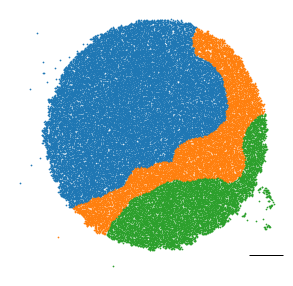

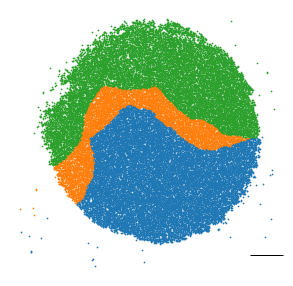

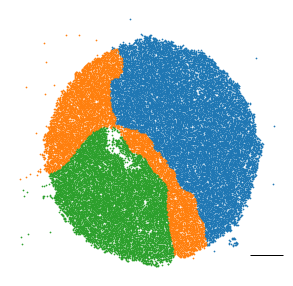

In [76]:
# Plot cell type compartments

for puck in tqdm([puck8, puck9, puck10]):  #puck8,puck9,puck10
    fig, ax = plt.subplots(figsize=(5, 5))
    puck.tumor_beads = [
        j for j in [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'Tumor'
        ]
    ]
    puck.til_beads = [
        j for j in [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines'
        ]
    ]
    puck.lung_beads = [
        j for j in [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'Lung'
        ]
    ]

    plt.scatter([i[0] for i in puck.tumor_beads],
                [i[1] for i in puck.tumor_beads],
                label='tumor',
                s=0.5,
                alpha=1,
                color=sns.color_palette()[0])
    plt.scatter([i[0] for i in puck.til_beads], [i[1] for i in puck.til_beads],
                label='tll',
                s=0.5,
                alpha=1,
                color=sns.color_palette()[1])
    plt.scatter([i[0] for i in puck.lung_beads],
                [i[1] for i in puck.lung_beads],
                label='lung',
                s=0.5,
                alpha=1,
                color=sns.color_palette()[2])

    plt.axis('off')
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(ax.transData,
                               pixels_needed,
                               '',
                               'lower right',
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    ax.add_artist(scalebar)

    plt.show()

# Figure 2e - All clonotypes and Supplementary Figure 3b

752 total number of clonotypes on this puck


  0%|          | 0/752 [00:00<?, ?it/s]

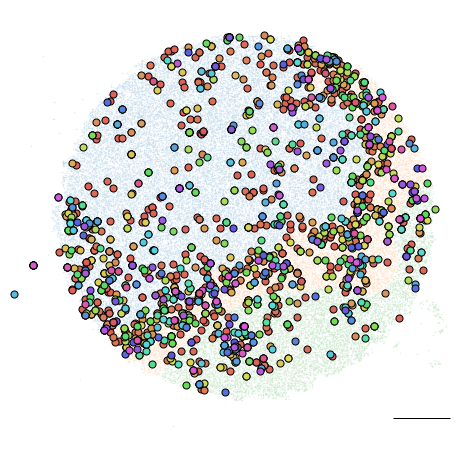

In [42]:
# Plot all clonotypes in different colors
puck = puck8

clonotypes_to_plot = []
clonotypes_to_plot_names = []
for cl in puck.tcr_loc_dict_s1_filtered3:
    if cl not in puck.clonotypes['1b']:
        continue
    clonotypes_to_plot = clonotypes_to_plot + [cl]
    clonotypes_to_plot_names.append(cl)

print(len(clonotypes_to_plot_names), 'total number of clonotypes on this puck')

fig, ax = plt.subplots(figsize=(8, 8))
t_plotx = [
    j[0] for j in [
        i for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == 'Tumor'
    ]
]
t_ploty = [
    j[1] for j in [
        i for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == 'Tumor'
    ]
]
ax.scatter(t_plotx, t_ploty, s=0.5, alpha=0.1, label='Tumor')

til_plotx = [
    j[0] for j in [
        i for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines'
    ]
]
til_ploty = [
    j[1] for j in [
        i for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines'
    ]
]
ax.scatter(til_plotx, til_ploty, s=0.5, alpha=0.1, label='Immune')

til_plotx = [
    j[0] for j in [
        i for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == 'Lung'
    ]
]
til_ploty = [
    j[1] for j in [
        i for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == 'Lung'
    ]
]
ax.scatter(til_plotx, til_ploty, s=0.5, alpha=0.1, label='Lung')

for idx in tqdm(range(len(clonotypes_to_plot))):
    clonotype = clonotypes_to_plot[idx]
    #####
    loc_for_this_cl = list(set(puck.tcr_loc_dict_s1_filtered3[clonotype]))

    x_val = [float(i[0]) for i in loc_for_this_cl]
    y_val = [float(i[1]) for i in loc_for_this_cl]

    plt.scatter(x_val,
                y_val,
                label=clonotype,
                color=sns.color_palette('hls', len(clonotypes_to_plot))[idx],
                edgecolors='k',
                linewidth=1,
                s=50)
    plt.xlim(0, 6000)
    plt.ylim(0, 6000)

    plt.axis('off')
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           pixels_needed,
                           '',
                           'lower right',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
plt.show()

# Figure 2f - Spatial enrichment analysis TODO

In [ ]:
# Establish tumor boundary
#Determine beads at the boundary of tumor and anything else
puck = puck8
d = 50

distarray = c(puck.tumor_beads,
              [j for j in [i for i in puck.tll_loc_cluster_dict]])

all_beads = [j for j in [i for i in puck.tll_loc_cluster_dict]]
boundary_points = []

skip_these_beads = set(
    [])  # for the tumor beads that are just too far away from the boundary

tumor_beads_loc_to_index = {}
for i in range(len(puck.tumor_beads)):
    tumor_beads_loc_to_index[puck.tumor_beads[i]] = i

for each_loc in tqdm(puck.tumor_beads):

    if each_loc in skip_these_beads:
        continue

    nearby_cell_types = [0, 0]  # First is tumor, second is anything else
    # Get nearest points within distance

    all_beads_indices = [
        i for i, x in enumerate(distarray[puck.tumor_beads.index(each_loc), ])
        if x < d
    ]
    cell_types = [
        puck.tll_loc_cluster_dict[all_beads[idx]] for idx in all_beads_indices
    ]
    for i in cell_types:
        if i == 'Tumor':
            nearby_cell_types[0] += 1
        else:
            nearby_cell_types[1] += 1
    if (nearby_cell_types[0] / sum(nearby_cell_types) <= 0.9):
        boundary_points.append(each_loc)

    else:
        skip_these_beads |= set([
            all_beads[i] for i in all_beads_indices
            if all_beads[i] in puck.tumor_beads
        ])
puck.boundary_points = boundary_points

In [ ]:
d = 50  # distance in microns
d = d / 0.65
cl_cell_counter = {}

# Save or load pucks

In [ ]:
# Build normalized DGE as part of saved pucks
puck = puck9
puck.s1_dge_fmtd_norm = puck.s1_dge_fmtd.div(puck.s1_dge_fmtd.sum(axis=1),
                                             axis=0)

In [ ]:
# Save or load pucks that you have been analyzing

save = False  # Set to true if you want to re-save everything again and false if you want to load a previously saved puck

all_puck_names = [
    '2020-09-02_Puck_200727_08',
    '2020-09-02_Puck_200727_09',
    '2020-09-02_Puck_200727_10',  # Post-treatment
    '2020-08-31_Puck_200727_02',  # Spleen
    '2020-09-02_Puck_200727_12',
    '2020-09-02_Puck_200727_12'
]  # Pre-treatment
puck_name = '2020-09-02_Puck_200727_08'
puck = puck8

if save:
    with open('{}_object.pickle'.format(puck_name), 'wb') as handle:
        pkl.dump(puck, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open('{}_object.pickle'.format(puck_name), 'rb') as handle:
        puck8 = pkl.load(handle)

# Clonotype and other cell Interaction Analyses (descriptive plot)

In [48]:
# Generate nearest cell types vectors(unsupervised)

cluster_num_to_name_dict = {}

cluster_num_to_name_list = [
    'Tumor',
    'B',
    'MGP',
    'RNA28S5',
    'Lung',
    'TIL Chemokines',
    'B',
    'No markers',
    'B',
    'No markers', 
    'B',
    'B',
    'B',
    'Blood',
    'TIL Chemokines',
    'B',  
    'B',
    'B',
    'B',
    'B',
    'B',
    'Ftl',
    'Tmsb4x'
]

cluster_num_to_name_dict = {
    idx: cluster_num_to_name_list[idx]
    for idx in range(len(cluster_num_to_name_list))
}

fn = './Aggregated_clusterassignments.csv'
aggregated_clusters = pd.read_csv(fn)
rep = [i.split('_')[0] for i in list(aggregated_clusters.barcode)]
barcode = [i.split('_')[1] for i in list(aggregated_clusters.barcode)]
aggregated_clusters['rep'] = rep
aggregated_clusters['barcode'] = barcode

for puck in tqdm([puck8, puck9, puck10]):
    if puck == puck8:
        cluster_labels = aggregated_clusters[aggregated_clusters.rep == 'rep8']
    if puck == puck9:
        cluster_labels = aggregated_clusters[aggregated_clusters.rep == 'rep9']
    if puck == puck10:
        cluster_labels = aggregated_clusters[aggregated_clusters.rep ==
                                             'rep10']

    cluster_num = len(list(set(cluster_labels.cluster)))
    cluster_labels['x'] = [
        puck.bc_loc_dict_s1[bc][0] for bc in cluster_labels.barcode
    ]
    cluster_labels['y'] = [
        puck.bc_loc_dict_s1[bc][1] for bc in cluster_labels.barcode
    ]

    bc_to_cluster_label_dict = dict(
        zip(cluster_labels.barcode, cluster_labels.cluster))
    loc_to_cluster_dict = {
        puck.bc_loc_dict_s1[i]: bc_to_cluster_label_dict[i]
        for i in list(bc_to_cluster_label_dict.keys())
    }

    x_1 = [float(i[0]) for i in loc_to_cluster_dict]
    y_1 = [float(i[1]) for i in loc_to_cluster_dict]
    c_1 = [loc_to_cluster_dict[i] for i in loc_to_cluster_dict]

    loc_to_bc_s1 = {y: x for x, y in puck.bc_loc_dict_s1.items()}
    loc_to_cluster_dict = {
        puck.bc_loc_dict_s1[i]: bc_to_cluster_label_dict[i]
        for i in list(bc_to_cluster_label_dict.keys())
    }

    cluster_labels['cluster_name'] = [
        cluster_num_to_name_list[i] for i in cluster_labels.cluster
    ]

    puck.loc_cluster_dict = loc_to_cluster_dict

    # Find nearest beads and generate dictionary of normalized nearest neighbors vectors
    # for every point

    tcr_locs = []
    for cl in puck.tcr_loc_dict_s1_filtered3:
        for loc in set(puck.tcr_loc_dict_s1_filtered3[cl]):
            tcr_locs.append(loc)
    tcr_locs = list(set(tcr_locs))
    distarray = c(tcr_locs, list(puck.loc_to_bc_s1.keys())
                  )  # CAN CHANGE TO TUMOR BEADS FOR JUST IN TUMOR

    loc_list_sort = sorted(puck.tumor_beads, key=lambda x: x[0])
    loc_list_sort_x = [i[0] for i in loc_list_sort]

    cluster_num_to_name_dict = {
        idx: cluster_num_to_name_list[idx]
        for idx in range(len(cluster_num_to_name_list))
    }
    cell_type_name_to_num_dict = {
        cluster_num_to_name_dict[i]: i
        for i in cluster_num_to_name_dict
    }
    cell_type_list = list(cluster_num_to_name_dict.keys())

    tumor_beads_loc_to_index = {}
    for i in range(len(puck.tumor_beads)):
        tumor_beads_loc_to_index[puck.tumor_beads[i]] = i

    random_tumor_dict = {}
    for each_loc in tqdm(tcr_locs):

        # Filter for x values within distance in either direction to reduce number of points needed to search.

        x_lower_bound = each_loc[0] - d
        x_upper_bound = each_loc[0] + d

        locs_within_bounds = loc_list_sort[
            find_le(loc_list_sort_x, x_lower_bound
                    ):find_ge(loc_list_sort_x, x_upper_bound) + 1]
        locs_within_bounds = [
            loc for loc in locs_within_bounds
            if ((each_loc[0] - loc[0])**2 + (each_loc[1] - loc[1])**2)**0.5 < d
        ]
        cl_convert = bc_list_to_clusters_vector(
            [puck.loc_to_bc_s1[loc] for loc in locs_within_bounds],
            cell_type_list, bc_to_cluster_label_dict)
        random_tumor_dict[each_loc] = np.array(cl_convert)
    puck.random_tumor_dict = random_tumor_dict

    for tcr in tqdm(puck.tcr_loc_dict_s1_filtered3):
        # only look at TCRbeta
        if tcr not in puck.clonotypes['1b']:
            continue
        if len(set(puck.tcr_loc_dict_s1_filtered3[tcr])) < 10:
            continue
        if tcr not in cl_cell_counter:
            cl_cell_counter[tcr] = np.array([0] * len(cell_type_list))
        for loc in set(puck.tcr_loc_dict_s1_filtered3[tcr]):
            cl_cell_counter[tcr] = cl_cell_counter[tcr] + np.array(
                random_tumor_dict[loc])

  0%|          | 0/3 [00:00<?, ?it/s]

/home/unix/sophliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/unix/sophliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/unix/sophliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1010 [00:00<?, ?it/s]

AttributeError: 'PuckReplicate' object has no attribute 'tumor_beads'

In [ ]:
# Generate nearest cell types vectors(RCTD)
#fn = 'rcc_rctd_clusters_{}.csv'.format(puck8.puck_name)
fn = 'rcc_rctd_clusters_{}.csv'.format(puck13.puck_name)
cluster_labels = pd.read_csv(fn)
cluster_labels.rename(columns={"cell_label": "cluster_name"}, inplace=True)
cell_type_list = list(set(cluster_labels.cluster_name))

fn = 'rcc_rctd_clusters_{}.csv'.format(puck12.puck_name)
cluster_labels = pd.read_csv(fn)
cluster_labels.rename(columns={"cell_label": "cluster_name"}, inplace=True)
cell_type_list = list(
    set(cell_type_list + list(set(cluster_labels.cluster_name))))

cluster_num_to_name_dict = {
    i: cell_type_list[i]
    for i in range(len(cell_type_list))
}
cluster_name_to_num_dict = {
    cell_type_list[i]: i
    for i in range(len(cell_type_list))
}

for puck in tqdm([puck12, puck13]):  #[puck8,puck9,puck10]
    fn = 'rcc_rctd_clusters_{}.csv'.format(puck.puck_name)
    cluster_labels = pd.read_csv(fn)
    cluster_labels.rename(columns={"cell_label": "cluster_name"}, inplace=True)

    barcodes = [
        puck.loc_to_bc_s1[i, j]
        for i, j in zip(cluster_labels.x, cluster_labels.y)
    ]
    cluster_num = [
        cluster_name_to_num_dict[i] for i in cluster_labels.cluster_name
    ]
    cluster_labels['cluster'] = cluster_num
    cluster_labels['barcode'] = barcodes
    bc_to_cluster_label_dict = dict(
        zip(cluster_labels.barcode, cluster_labels.cluster))
    loc_to_cluster_dict = {
        puck.bc_loc_dict_s1[i]: bc_to_cluster_label_dict[i]
        for i in list(bc_to_cluster_label_dict.keys())
    }
    puck.loc_cluster_dict = loc_to_cluster_dict

    # Find nearest beads and generate dictionary of normalized nearest neighbors vectors
    # for every point

    tcr_locs = []
    for cl in puck.tcr_loc_dict_s1_filtered3:
        for loc in set(puck.tcr_loc_dict_s1_filtered3[cl]):
            tcr_locs.append(loc)
    tcr_locs = list(set(tcr_locs))
    distarray = c(tcr_locs, list(puck.loc_to_bc_s1.keys())
                  )  # CAN CHANGE TO TUMOR BEADS FOR JUST IN TUMOR

    loc_list_sort = sorted(puck.tumor_beads, key=lambda x: x[0])
    loc_list_sort_x = [i[0] for i in loc_list_sort]

    tumor_beads_loc_to_index = {}
    for i in range(len(puck.tumor_beads)):
        tumor_beads_loc_to_index[puck.tumor_beads[i]] = i

    random_tumor_dict = {}
    for each_loc in tqdm(tcr_locs):

        # Filter for x values within distance in either direction to reduce number of points needed to search.

        x_lower_bound = each_loc[0] - d
        x_upper_bound = each_loc[0] + d

        locs_within_bounds = loc_list_sort[
            find_le(loc_list_sort_x, x_lower_bound
                    ):find_ge(loc_list_sort_x, x_upper_bound) + 1]
        locs_within_bounds = [
            loc for loc in locs_within_bounds
            if ((each_loc[0] - loc[0])**2 + (each_loc[1] - loc[1])**2)**0.5 < d
        ]
        cl_convert = bc_list_to_clusters_vector(
            [puck.loc_to_bc_s1[loc] for loc in locs_within_bounds],
            cell_type_list,
            bc_to_cluster_label_dict,
            verbose=False)
        random_tumor_dict[each_loc] = np.array(cl_convert)
    puck.random_tumor_dict = random_tumor_dict

    for tcr in tqdm(puck.tcr_loc_dict_s1_filtered3):
        # only look at TCRbeta
        if tcr not in puck.clonotypes['1b']:
            continue
        if len(set(puck.tcr_loc_dict_s1_filtered3[tcr])) < 10:
            continue
        if tcr not in cl_cell_counter:
            cl_cell_counter[tcr] = np.array([0] * len(cell_type_list))
        for loc in set(puck.tcr_loc_dict_s1_filtered3[tcr]):
            cl_cell_counter[tcr] = cl_cell_counter[tcr] + np.array(
                random_tumor_dict[loc])
    puck.cluster_labels = cluster_labels

In [ ]:
pretty_cell_type_names = {
    'Bcell': 'B',
    'MastCell': 'Mast',
    'MyeloidCell_02_CD11c_CD14': 'Myeloid CD11c CD14',
    'Myeloid_01_CD11c': 'Myeloid CD11c',
    'Myeloid_03_CD16': 'Myeloid CD16',
    'Myeloid_04_CD14_CD16': 'Myeloid CD14 CD16',
    'Myeloid_DC1_CD141': 'Myeloid DC CD141',
    'Myeloid_pDC': 'Myeloid pDC',
    'NK': 'NK',
    'NKT': 'NKT',
    'NonImmuneCell': 'Lung',
    'PlasmaCell': 'Plasma B',
    'Tcell_CD4': 'CD4 T',
    'Tcell_CD8': 'CD8 T',
    'Tcell_Treg': 'Treg',
    'TumorCell_CA9': 'Tumor',
    'Kidney_DistalTubule': 'Kidney',
    'Kidney_ProximalTubule': 'Kidney',
    'Epithelial_EPCAM': 'Epithelial'
}

In [ ]:
sns.set(font_scale=1.4)
agg_interactions = pd.DataFrame.from_dict(cl_cell_counter)
agg_interactions.columns = [naming_dict[i] for i in agg_interactions.columns]
agg_interactions.index = [pretty_cell_type_names[i] for i in cell_type_list]
agg_interactions.columns
agg_interactions_no_zero = agg_interactions.loc[(
    agg_interactions.sum(axis=1) != 0), (agg_interactions.sum(axis=0) != 0)]

# Sum same cell type rows
#agg_interactions_no_zero = agg_interactions_no_zero.groupby(agg_interactions_no_zero.index).agg({i:sum for i in agg_interactions_no_zero.columns})
# Drop some rows
#agg_interactions_no_zero.drop(['Ftl','No markers','RNA28S5'],inplace=True)
#agg_interactions_no_zero.drop(['No markers'],inplace=True)

# normalize by dividing each column by sum
for col in agg_interactions_no_zero.columns:
    agg_interactions_no_zero[col] = agg_interactions_no_zero[col] / sum(
        agg_interactions_no_zero[col])

set_cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.color_palette("coolwarm", as_cmap=True)
#sns.diverging_palette(220, 20, as_cmap=True)
#sns.color_palette("icefire", as_cmap=True)
#

agg_interactions_no_zero = agg_interactions_no_zero
agg_interactions_no_zero.sort_index(inplace=True)
# For post-treatment, use this:
# g = sns.clustermap(agg_interactions_no_zero,z_score=0,
#                yticklabels=True,
#                xticklabels=True,
#                cmap=set_cmap,center=0,
#               figsize=(15,7))

#For pre-treatment, use this:
g = sns.heatmap(agg_interactions_no_zero,
                yticklabels=True,
                xticklabels=True,
                cmap=set_cmap,
                center=0)
plt.savefig('./vectorized_figures/figure2f_clustermap.pdf')

In [ ]:
agg_interactions_no_zero_zscore = pd.DataFrame(
    stats.zscore(agg_interactions_no_zero, axis=1, ddof=1),
    columns=agg_interactions_no_zero.columns,
    index=agg_interactions_no_zero.index)
agg_interactions_no_zero_zscore = agg_interactions_no_zero_zscore.T
agg_interactions_no_zero_zscore.sort_values('Tumor', inplace=True)
agg_interactions_no_zero_zscore.sort_values('Tumor', inplace=True)

In [ ]:
agg_interactions_no_zero_zscore = agg_interactions_no_zero_zscore[
    agg_interactions_no_zero_zscore.columns]

In [ ]:
agg_interactions_no_zero_zscore = agg_interactions_no_zero_zscore.T
plt.figure(figsize=(15, 7))
sns.heatmap(agg_interactions_no_zero_zscore,
            yticklabels=True,
            xticklabels=True,
            cmap=set_cmap,
            center=0)

plt.savefig('./vectorized_figures/figure2f_heatmap.pdf')

# Figure 3 Plots


## Metagene DE Analysis

In [ ]:
pixels_needed = 500 / 0.65
puck = puck8
load_genesets = True
run_geneset_qc = False
# Read in gene sets
if load_genesets:
    gene_df = pd.read_excel('T cell signatures.xls',
                            sheet_name='published signatures')
    gene_groups = {}
    for name in gene_df.columns:
        gene_groups[name] = [i for i in list(gene_df[name]) if type(i) == str]
    ss_genes = puck.s1_dge_fmtd.columns

    missing_genes = []
    for group in gene_groups:
        for gene in gene_groups[group]:
            if gene in ss_genes:
                pass
            if gene not in ss_genes:
                missing_genes.append(gene)
    if len(missing_genes) > 0:
        print('These genes are missing:', missing_genes)
    # Remove missing genes
    for group in gene_groups:
        gene_groups[group] = [
            i for i in gene_groups[group] if i not in missing_genes
        ]
if run_geneset_qc:
    # Geneset QC (see reads per bead for each geneset)
    for group in gene_group_cl_agg:
        print(group)
        print(np.mean([i for i in gene_group_cl_agg[group] if i != 0]))
    print('-----------')
    for group in gene_group_cl_agg_not_norm:
        print(group)
        #print([i for i in gene_group_cl_agg_not_norm[group] if i >= 10])
        #if np.median([i for i in gene_group_cl_agg_not_norm[group] if i >= 1])>=0:

        plt.figure()
        plt.hist([i for i in gene_group_cl_agg_not_norm[group] if i >= 1])
        plt.title(group)

In [ ]:
# Split the plots by clonotype:
# Calculate gene expression for each gene group for clonotypes separately and then all together

puck = puck8

# INDIVIDUAL CLONOTYPE ANALYSIS
gene_group_cl = {}
gene_group_cl_less = {}
gene_group_cl_greater = {}
all_cl_bcs = []
for clonotype in tqdm(puck.tcr_loc_dict_s1_filtered3):
    cl_locs = [
        i for i in set(puck.tcr_loc_dict_s1_filtered3[clonotype])
        if i in puck.tumor_beads
    ]  #  if i in puck.tumor_beads
    cl_bcs = [puck.loc_to_bc_s1[i] for i in cl_locs]
    all_cl_bcs = all_cl_bcs + cl_bcs
    if len(cl_bcs) < 10:
        continue

    # This is a distribution of the summed normalized expression of all the genes in each group
    if group not in gene_group_cl:
        gene_group_cl[group] = {}
        gene_group_cl_less[group] = {}
        gene_group_cl_greater[group] = {}
    gene_group_cl[group][clonotype] = list(
        puck.s1_dge_fmtd_norm.loc[cl_bcs, gene_groups[group]].sum(axis=1))

    cutoff = np.median(gene_group_cl[group][clonotype])
    gene_group_cl_less[group][clonotype] = [
        cl_locs[idx] for idx in range(len(gene_group_cl[group][clonotype]))
        if gene_group_cl[group][clonotype][idx] < cutoff
    ]
    gene_group_cl_greater[group][clonotype] = [
        cl_locs[idx] for idx in range(len(gene_group_cl[group][clonotype]))
        if gene_group_cl[group][clonotype][idx] >= cutoff
    ]

# AGGREGATE CLONOTYPE ANALYSIS
gene_group_cl_agg = {}
gene_group_cl_agg_less = {}
gene_group_cl_agg_greater = {}
gene_group_cl_agg_not_norm = {}
all_cl_bcs = list(set(all_cl_bcs))
all_locs = [puck.bc_loc_dict_s1[i] for i in all_cl_bcs]

gene_group_cl_agg[group] = list(
    puck.s1_dge_fmtd_norm.loc[all_cl_bcs, gene_groups[group]].sum(axis=1))
cutoff = np.median(gene_group_cl_agg[group])
gene_group_cl_agg_less = [
    all_locs[idx] for idx in range(len(gene_group_cl_agg[group]))
    if gene_group_cl_agg[group][idx] < cutoff
]
gene_group_cl_agg_greater = [
    all_locs[idx] for idx in range(len(gene_group_cl_agg[group]))
    if gene_group_cl_agg[group][idx] >= cutoff
]
less_agg_dist = [
    distance_between_points(pt, closest_node(pt, puck.boundary_points))
    for pt in gene_group_cl_agg_less if pt in puck.tumor_beads
]
greater_agg_dist = [
    distance_between_points(pt, closest_node(pt, puck.boundary_points))
    for pt in gene_group_cl_agg_greater if pt in puck.tumor_beads
]

# PLOT
plt.figure(figsize=(6, 3))
df_greater = pd.DataFrame.from_dict(
    {'Distance distribution': [i * 0.65 for i in greater_agg_dist]})
df_less = pd.DataFrame.from_dict(
    {'Distance distribution': [i * 0.65 for i in less_agg_dist]})
sns.distplot(df_greater['Distance distribution'],
             hist=False,
             kde=True,
             bins=int(180 / 5),
             color='darkblue',
             hist_kws={
                 'edgecolor': 'gray',
                 'alpha': 0.75
             },
             kde_kws={
                 'linewidth': 4,
                 'bw': 0.5,
                 'alpha': 0.75
             },
             norm_hist=True,
             label='Greater')

sns.distplot(df_less['Distance distribution'],
             hist=False,
             kde=True,
             bins=int(180 / 5),
             color='orange',
             hist_kws={
                 'edgecolor': 'gray',
                 'alpha': 0.75
             },
             kde_kws={
                 'linewidth': 4,
                 'bw': 0.5,
                 'alpha': 0.75
             },
             norm_hist=True,
             label='Less')

print(
    'ks_test',
    kstest([i * 0.65 for i in greater_agg_dist],
           [i * 0.65 for i in less_agg_dist]))
plt.savefig('./vectorized_figures/fig3_v3_1.pdf')

# PLOT 2
fig, ax = plt.subplots()
agg = copy.deepcopy(gene_group_cl_agg[group])

df_all = pd.DataFrame.from_dict({'Value': [i for i in agg]})

sns.distplot(df_all['Value'],
             hist=False,
             kde=True,
             bins=int(180 / 10),
             color='black',
             hist_kws={
                 'edgecolor': 'gray',
                 'alpha': 0.75
             },
             kde_kws={
                 'linewidth': 2,
                 'bw': 0.3,
                 'alpha': .75
             },
             norm_hist=True,
             label='Less')
plt.axvline(x=cutoff, c='black', linewidth=3)

sns.distplot(df_all['Value'],
             hist=True,
             kde=False,
             bins=int(180 / 10),
             color='orange',
             hist_kws={
                 'edgecolor': 'gray',
                 'alpha': 0.75
             },
             kde_kws={
                 'linewidth': 2,
                 'bw': 0.3,
                 'alpha': .75
             },
             norm_hist=True,
             label='Less')
plt.axvline(x=cutoff, c='black', linewidth=3)

for p in ax.patches:
    if p.get_xy()[0] >= cutoff * .95:
        p.set_color('darkblue')
    if p.get_xy()[1] >= cutoff:
        p.set_color('darkblue')
plt.savefig('./vectorized_figures/fig3_v3.pdf')

######

all_pvals = []
group = 'Bad response to ICP (from Sade-Feldman et al. 2018)'
plotting_df = {}
plotting_df['less_or_greater'] = []
plotting_df['value'] = []
plotting_df['clonotype'] = []

for cl in gene_group_cl[group]:
    less = gene_group_cl_less[group][cl]
    greater = gene_group_cl_greater[group][cl]

    less_dist = [
        distance_between_points(pt, closest_node(pt, puck.boundary_points))
        for pt in less if pt in puck.tumor_beads
    ]
    greater_dist = [
        distance_between_points(pt, closest_node(pt, puck.boundary_points))
        for pt in greater if pt in puck.tumor_beads
    ]

    if len(less_dist) < 10:
        continue
    if len(greater_dist) < 10:
        continue

#     plt.figure()
#     plt.hist(less_dist)
#     plt.hist(greater_dist)

    pval = round(kstest(less_dist, greater_dist)[1], 2)
    all_pvals.append(kstest(less_dist, greater_dist)[1])
    #     plt.title(cl + ' ' +  str(pval))

    plotting_df['clonotype'] = plotting_df['clonotype'] + [cl] * (
        len(less_dist) + len(greater_dist))
    plotting_df['value'] = plotting_df['value'] + less_dist + greater_dist
    plotting_df['less_or_greater'] = plotting_df['less_or_greater'] + [
        'less'
    ] * len(less_dist) + ['greater'] * len(greater_dist)

plotting_df['value'] = [i * 0.65 for i in plotting_df['value']]

color_palette_to_use = [sns.color_palette("tab10")[2]
                        ] + [sns.color_palette("tab10")[4]]
plotting_df = pd.DataFrame(plotting_df)
plotting_df.clonotype = [
    pretty_clonotype_name[i] for i in plotting_df.clonotype
]
plt.figure()
plt.rcParams.update({'font.size': 10})
plotting_df.sort_values('clonotype', inplace=True)
plt.figure(figsize=(6, 3))
plotting_df.sort_values('less_or_greater', inplace=True, ascending=True)
plotting_df.sort_values('clonotype', inplace=True)
sns.violinplot(x="clonotype",
               y="value",
               hue="less_or_greater",
               hue_order=['less', 'greater'],
               data=plotting_df,
               palette=color_palette_to_use,
               split=True,
               bw=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('./vectorized_figures/figure3f_new.pdf')

cl_distances = {}
cl_medians = {}
for cl in puck.tcr_loc_dict_s1_filtered3:
    cl_distances[cl] = [
        (pt, distance_between_points(pt, closest_node(pt,
                                                      puck.boundary_points)))
        for pt in set(puck.tcr_loc_dict_s1_filtered3[cl])
        if pt in puck.tumor_beads
    ]
    cl_medians[cl] = np.median([i[1] for i in cl_distances[cl]])

In [ ]:
# Adjust p values for above plot
p_values_all_corrected = stats.multitest.multipletests(all_pvals,
                                                       alpha=0.05,
                                                       method='fdr_bh',
                                                       is_sorted=False,
                                                       returnsorted=False)
conversion_dict = dict(zip(all_pvals, p_values_all_corrected[1]))
conversion_dict

In [ ]:
# Plot geneset expression spatially on puck separated by median geneset expression

# plot significant clonotypes on all pucks
plt.rcParams.update({'font.size': 10})

for puck in tqdm([puck8]):

    for group in gene_group_cl:
        if group != 'Bad response to ICP (from Sade-Feldman et al. 2018)':
            continue

        fig, ax = plt.subplots(figsize=(5, 5))
        puck.tumor_beads = [
            j for j in [
                i for i in puck.tll_loc_cluster_dict
                if puck.tll_loc_cluster_dict[i] == 'Tumor'
            ]
        ]
        puck.til_beads = [
            j for j in [
                i for i in puck.tll_loc_cluster_dict
                if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines'
            ]
        ]
        puck.lung_beads = [
            j for j in [
                i for i in puck.tll_loc_cluster_dict
                if puck.tll_loc_cluster_dict[i] == 'Lung'
            ]
        ]

        plt.scatter([i[0] for i in puck.til_beads],
                    [i[1] for i in puck.til_beads],
                    label='tll',
                    s=3,
                    alpha=0.01,
                    color=sns.color_palette()[1])
        plt.scatter([i[0] for i in puck.lung_beads],
                    [i[1] for i in puck.lung_beads],
                    label='lung',
                    s=3,
                    alpha=0.01,
                    color=sns.color_palette()[2])
        plt.scatter([i[0] for i in puck.tumor_beads],
                    [i[1] for i in puck.tumor_beads],
                    label='tumor',
                    s=3,
                    alpha=0.01,
                    color=sns.color_palette()[0])

        all_tcr_bcs = all_locs  ##
        coloring_for_each_loc = gene_group_cl_agg[group]

        #         x = [i[0] for i in all_tcr_locs  if i in puck.tumor_beads] #
        #         y = [i[1] for i in all_tcr_locs  if i in puck.tumor_beads] #
        x = [i[0] for i in all_locs]  #
        y = [i[1] for i in all_locs]  #
        ge = coloring_for_each_loc
        plotting_df = pd.DataFrame.from_dict({'x': x, 'y': y, 'ge': ge})
        cutoff = np.median(plotting_df['ge'])  ## FOR AGGREGATE
        test_df = plotting_df
        plotting_df_less = plotting_df[plotting_df['ge'] < cutoff]
        plotting_df_greater = plotting_df[plotting_df['ge'] >= cutoff]
        #         sns.scatterplot(data = plotting_df, x= x, y = y, hue = 'blue',alpha=0.5)

        ### FOR ORIGINAL SEPARATED PLOTS
        sns.scatterplot(data=plotting_df_less,
                        x='x',
                        y='y',
                        color='orange',
                        alpha=0.5,
                        label='lower_than_median')
        sns.scatterplot(data=plotting_df_greater,
                        x='x',
                        y='y',
                        color='darkblue',
                        alpha=0.5,
                        label='greater_than_median')
        ### FOR PLOTS COLORED BY EXPRESSION
        #         sns.scatterplot(data = plotting_df, x= 'x', y = 'y', hue='ge',alpha=0.5)
        plt.xlim([0, 6000])
        plt.ylim([0, 6000])
        ax.set_xlim([0, 6000])
        ax.set_ylim([0, 6000])
        #plt.title(group)
        lgd = plt.legend(bbox_to_anchor=(2, 1), loc='upper left')
        plt.axis('off')
        plt.tight_layout()
        fontprops = fm.FontProperties(size=18)
        scalebar = AnchoredSizeBar(ax.transData,
                                   pixels_needed,
                                   '',
                                   'lower right',
                                   pad=0.1,
                                   color='black',
                                   frameon=False,
                                   size_vertical=1,
                                   fontproperties=fontprops)

        ax.add_artist(scalebar)
        plt.savefig(
            './vectorized_figures/figure3b_spatial_legend_{}.pdf'.format(
                group),
            bbox_extra_artists=(lgd, ),
            bbox_inches='tight')
        plt.show()

# for ax, col in zip(ax[0], significant_clonotypes):
#     ax.set_title(col,fontsize=40)

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()

In [ ]:
# Plot gene expression for each clonotype against aggregated, ks_values_all
# Looking at all beads (can try tumor only next)
# ignore beads with 0s

make_plot = True
sns.set_style("whitegrid", {'axes.grid': False})

plt.rcParams.update({'font.size': 16})
ks_values_good_pval = [[], []]  # greater and less
ks_values_good_stat = [[], []]
ks_values_bad_pval = [[], []]
ks_values_bad_stat = [[], []]

ks_values_all = {}
cls_order = []
iterct = 0

for group in tqdm(gene_group_cl):
    iterct += 1

    for cl in gene_group_cl[group]:
        if cl in puck.clonotypes['1b']:
            #             if cl not in significant_clonotypes:
            #                 continue

            lowest = min(min(gene_group_cl[group][cl]),
                         min(gene_group_cl_agg[group]))
            highest = max(max(gene_group_cl[group][cl]),
                          max(gene_group_cl_agg[group]))
            agg_remove_query = []
            agg_remove_query = copy.deepcopy(gene_group_cl_agg[group])
            for value in gene_group_cl[group][cl]:
                agg_remove_query.remove(value)

            kstest_greater = kstest(
                gene_group_cl[group][cl],
                agg_remove_query)  #,alternative='two-sided'
            kstest_greater_pval = kstest_greater[1]

            #             kstest_greater = scipy.stats.ttest_ind(gene_group_cl[group][cl],agg_remove_query)
            #             kstest_greater_pval = scipy.stats.ttest_ind(gene_group_cl[group][cl],agg_remove_query)[1]

            ## CHANGE THIS line for different metrics
            metric = cohens_d(gene_group_cl[group][cl], agg_remove_query)

            if iterct == 1:
                cls_order.append(cl)

            if group not in ks_values_all:
                ks_values_all[group] = [[], []]
                # Change sign depending on mean differences
            if np.mean(agg_remove_query) < np.mean(gene_group_cl[group][cl]):
                ks_values_all[group][0].append(metric)
            elif np.mean(agg_remove_query) > np.mean(gene_group_cl[group][cl]):
                ks_values_all[group][0].append(metric)

            ks_values_all[group][1].append(kstest_greater[1])

            if cl in significant_clonotypes:  #['CASRYGSLAEGGTQYF']: #,'CASSQGLAGVLGQFF','CASSPTVYNEQFF'
                print((np.mean(gene_group_cl[group][cl]),
                       np.mean(agg_remove_query),
                       np.mean(gene_group_cl[group][cl]) -
                       np.mean(agg_remove_query)))
                #                 if group not in ['Bad response to ICP (from Sade-Feldman et al. 2018)']: #Good response to ICP (from Sade-Feldman et al. 2018)'
                #                     continue
                #             if (kstest_greater_pval < 0.05 or kstest_less_pval < 0.05): #(kstest_greater < 0.05 or kstest_less < 0.05)
                if make_plot:
                    if group not in [
                            'Bad response to ICP (from Sade-Feldman et al. 2018)'
                    ]:  #Good response to ICP (from Sade-Feldman et al. 2018)'
                        continue
                    plt.figure(figsize=(5, 3))
                    df = pd.DataFrame.from_dict({
                        'Gene expression':
                        gene_group_cl[group][cl],
                        'Clonotype': [cl] * len(gene_group_cl[group][cl])
                    })
                    df_agg = pd.DataFrame.from_dict({
                        'Clonotype': ['Aggregated'] * len(agg_remove_query),
                        'Aggregated gene expression':
                        agg_remove_query
                    })

                    sns.distplot(df_agg['Aggregated gene expression'],
                                 hist=False,
                                 kde=True,
                                 bins=int(180 / 18),
                                 color='black',
                                 hist_kws={'edgecolor': 'black'},
                                 kde_kws={
                                     'linewidth': 2,
                                     'bw': 0.2,
                                     'alpha': 0.5
                                 },
                                 norm_hist=True,
                                 label='Aggregated')

                    sns.distplot(df['Gene expression'],
                                 hist=True,
                                 kde=True,
                                 bins=int(180 / 18),
                                 color='red',
                                 hist_kws={'edgecolor': 'none'},
                                 kde_kws={
                                     'linewidth': 2,
                                     'bw': 0.5,
                                     'alpha': 0.5
                                 },
                                 norm_hist=True,
                                 label=cl)

                    #                 x1, bins1, p1 = plt.hist(gene_group_cl[group][cl],label=cl,alpha=0.3,
                    #                         range=(lowest,highest),bins=50)
                    #                 x2, bins2, p2 = plt.hist(agg_remove_query,label='All Clonotypes',
                    #                          alpha=0.3,range=(lowest,highest),bins=50)
                    #                 all_heights_to_find_max = []
                    #                 for item in p1:
                    #                     item.set_height(item.get_height()/sum(x1))
                    #                     all_heights_to_find_max.append(item.get_height())
                    #                 for item in p2:
                    #                     item.set_height(item.get_height()/sum(x2))
                    #                     all_heights_to_find_max.append(item.get_height())
                    #                 max_height = max(all_heights_to_find_max)

                    #                 plt.ylim([0,max_height*1.1])
                    pval_to_show = kstest(
                        gene_group_cl[group][cl],
                        agg_remove_query)[1]  #,alternative='two-sided'
                    #             kstest_less_pval = kstest_less[1]

                    plt.title(cl + ' ' + group + '\n pval_greater = ' +
                              str(round(pval_to_show, 2)))
                    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.savefig(
                        './vectorized_figures/figure3e_distribution.pdf')
                    plt.show()

In [ ]:
p_values_all_precorrected = []
for group in ks_values_all:
    p_values_all_precorrected = p_values_all_precorrected + ks_values_all[
        group][1]

p_values_all_corrected = stats.multitest.multipletests(
    p_values_all_precorrected,
    alpha=0.05,
    method='fdr_bh',
    is_sorted=False,
    returnsorted=False)
conversion_dict = dict(zip(p_values_all_precorrected, p_values_all_corrected[1]))
conversion_dict[0.001186844222397343]
#conversion_dict[0.0245150836249218]

In [ ]:
# Run this for each puck to be able to do aggregated analysis below
for puck in [puck8, puck9, puck10]:

    remove = []

    aggregated_p_values_filt = {
        i: puck.aggregated_p_values[i]
        for i in puck.aggregated_p_values if i not in remove
    }
    puck.aggregated_p_values_filt = aggregated_p_values_filt
    aggregated_p_values_adjusted = {
        i.split(' (')[0]: aggregated_p_values_filt[i]
        for i in aggregated_p_values_filt
    }  #i
    aggregated_p_values_adjusted
    pre_adjustment = list(puck.aggregated_p_values.values())
    post_adjustment = statsmodels.stats.multitest.multipletests(
        pre_adjustment,
        alpha=0.05,
        method='fdr_bh',
        is_sorted=False,
        returnsorted=False)[1]
    adjustment_dict = dict(zip(pre_adjustment, post_adjustment))
    aggregated_p_values_adjusted = {
        i: adjustment_dict[aggregated_p_values_adjusted[i]]
        for i in aggregated_p_values_adjusted
    }
    df = pd.DataFrame.from_dict(aggregated_p_values_adjusted, orient='index')
    df.columns = ['p-value']
    df = df.round(3)

    df = df[~df.index.isin(remove)]
    display(df)
    sns.heatmap(df)
    ##
    ##
    aggregated_effect_size = {
        i: puck.aggregated_effect_size[i]
        for i in puck.aggregated_effect_size if i not in remove
    }  #i
    aggregated_effect_size = {
        i.split(' (')[0]: aggregated_effect_size[i]
        for i in aggregated_effect_size
    }  #i

    df2 = pd.DataFrame.from_dict(aggregated_effect_size, orient='index')
    df2.columns = ['Effect size']
    df2 = df2.round(3)

    plt.figure(figsize=(1, 10))
    df2 = df2[~df2.index.isin(remove)]
    df2.sort_values('Effect size', inplace=True, ascending=False)
    display(df2)
    puck.df2 = df2
    puck.aggregated_p_values_filt = aggregated_p_values
    set_cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df2,
                cmap=set_cmap,
                center=0,
                yticklabels=True,
                linewidths=.5,
                vmin=-1,
                vmax=1)
    plt.tight_layout()
    plt.savefig('./vectorized_figures/figure3c_{}.pdf'.format(puck.puck_name))

In [ ]:
###### Aggregated analysis across all pucks

aggregated_and_corrected_values = {}
for geneset in puck8.aggregated_p_values_filt:
    if geneset == 'Good response to ICP (from Sade-Feldman et al. 2018)':
        continue
    aggregated_and_corrected_values[geneset] = scipy.stats.combine_pvalues([
        puck8.aggregated_p_values_filt[geneset],
        puck9.aggregated_p_values_filt[geneset],
        puck10.aggregated_p_values_filt[geneset]
    ])[1]

pre_adjustment = list(aggregated_and_corrected_values.values())
post_adjustment = statsmodels.stats.multitest.multipletests(
    pre_adjustment,
    alpha=0.05,
    method='fdr_bh',
    is_sorted=False,
    returnsorted=False)[1]
adjustment_dict = dict(zip(pre_adjustment, post_adjustment))
aggregated_and_corrected_values = {
    i: adjustment_dict[aggregated_and_corrected_values[i]]
    for i in aggregated_and_corrected_values
}

print(aggregated_and_corrected_values)
aggregated_effect_size_all_pucks = {}
for geneset in list(puck8.df2.index):
    if geneset == 'Good response to ICP (from Sade-Feldman et al. 2018)':
        continue
    print([
        float(puck8.df2[puck8.df2.index == geneset]['Effect size']),
        float(puck9.df2[puck9.df2.index == geneset]['Effect size']),
        float(puck10.df2[puck10.df2.index == geneset]['Effect size'])
    ])
    aggregated_effect_size_all_pucks[geneset] = np.mean([
        float(puck8.df2[puck8.df2.index == geneset]['Effect size']),
        float(puck9.df2[puck9.df2.index == geneset]['Effect size']),
        float(puck10.df2[puck10.df2.index == geneset]['Effect size'])
    ])

df3 = pd.DataFrame.from_dict(aggregated_effect_size_all_pucks, orient='index')
df3.columns = ['Effect size']
df3 = df3.round(3)

plt.figure(figsize=(1, 10))
df3 = df3[~df3.index.isin(remove)]
df3.sort_values('Effect size', inplace=True, ascending=False)
display(df3)
set_cmap = sns.diverging_palette(230, 20, as_cmap=True)
this_plot = sns.heatmap(df3,
                        cmap=set_cmap,
                        center=0,
                        yticklabels=True,
                        linewidths=.5)
plt.tight_layout()
plt.savefig('./vectorized_figures/figure3d.pdf', bbox_inches='tight')

In [ ]:
# Plot two distributions of gene expression based on distances split
puck = puck8
gene_group_cl_below_median = {}
gene_group_cl_above_median = {}

for clonotype in tqdm(puck.tcr_loc_dict_s1_filtered3):
    if clonotype not in cl_distances:
        continue
    below_cl_locs = [
        i[0] for i in cl_distances[clonotype] if i[1] <= cl_medians[clonotype]
    ]  # if i in puck.tumor_beads
    above_cl_locs = [
        i[0] for i in cl_distances[clonotype] if i[1] > cl_medians[clonotype]
    ]
    below_bcs = [puck.loc_to_bc_s1[i] for i in below_cl_locs]
    above_bcs = [puck.loc_to_bc_s1[i] for i in above_cl_locs]
    all_cl_bcs = all_cl_bcs + cl_bcs
    if len(below_cl_locs) < 10:
        continue
    if len(above_cl_locs) < 10:
        continue
    for group in gene_groups:
        # This is a distribution of the summed normalized expression of all the genes in each group
        if group not in gene_group_cl_below_median:
            gene_group_cl_below_median[group] = {}
        if group not in gene_group_cl_above_median:
            gene_group_cl_above_median[group] = {}

        gene_group_cl_below_median[group][clonotype] = list(
            puck.s1_dge_fmtd_norm.loc[below_bcs,
                                      gene_groups[group]].sum(axis=1))
        gene_group_cl_above_median[group][clonotype] = list(
            puck.s1_dge_fmtd_norm.loc[above_bcs,
                                      gene_groups[group]].sum(axis=1))

In [ ]:
cl_medians_pretty = {
    pretty_clonotype_name[i]: cl_medians[i]
    for i in cl_medians if i in pretty_clonotype_name
}
cl_medians_pretty['TCR-7']

In [ ]:
significant_clonotypes
significant_clonotypes_tumor_filt = []
for cl in significant_clonotypes:
    tumor_locs_for_this_cl = [
        loc for loc in set(puck.tcr_loc_dict_s1_filtered3[cl])
        if loc in puck.tumor_beads
    ]
    if len(tumor_locs_for_this_cl) >= 10:
        print(cl, pretty_clonotype_name[cl], len(tumor_locs_for_this_cl))
        significant_clonotypes_tumor_filt.append(cl)

In [ ]:
significant_clonotypes = significant_clonotypes_tumor_filt

In [ ]:
# Plot for each clonotype and geneset x-axis geneset expressoin, split by distance median.
def make_plotting_df():
    pval_recorder = []
    plt.rcParams.update({'font.size': 22})
    plotting_df = {}
    plotting_df['geneset'] = []
    plotting_df['clonotype'] = []
    plotting_df['greater_or_less'] = []
    plotting_df['expression'] = []

    for group in gene_group_cl_below_median:
        for cl in list(gene_group_cl_below_median[group].keys()
                       ):  ### changed to different group to test
            if cl in gene_group_cl_below_median[group]:
                lowest = min(gene_group_cl_below_median[group][cl])
                highest = max(gene_group_cl_above_median[group][cl])
                for i in range(len(gene_group_cl_below_median[group][cl])):
                    plotting_df['geneset'].append(group)
                    plotting_df['clonotype'].append(cl)
                    plotting_df['greater_or_less'].append('less')
                plotting_df['expression'] = plotting_df[
                    'expression'] + gene_group_cl_below_median[group][cl]

                for i in range(len(gene_group_cl_above_median[group][cl])):
                    plotting_df['geneset'].append(group)
                    plotting_df['clonotype'].append(cl)
                    plotting_df['greater_or_less'].append('greater')
                plotting_df['expression'] = plotting_df[
                    'expression'] + gene_group_cl_above_median[group][cl]
                if cl == 'CASSPRTSGRYNEQFF':
                    pass

                pval = kstest(gene_group_cl_below_median[group][cl],
                              gene_group_cl_above_median[group][cl])[1]
                if group in [
                        'Bad response to ICP (from Sade-Feldman et al. 2018)',
                        'Terminal exhausted (from Miller et al. 2019 and Feldman)'
                ]:
                    pval_recorder.append(pval)
                if group == 'Bad response to ICP (from Sade-Feldman et al. 2018)':
                    print(cl, pval)
                if pval < 0.05:
                    print('KS', cl, group, pval)
                pval = scipy.stats.ttest_ind(
                    gene_group_cl_below_median[group][cl],
                    gene_group_cl_above_median[group][cl])[1]
                if pval < 0.05:
                    print('TT', cl, group, pval)

    #                 plt.title('{} {} pval: {}'.format(group,cl,pval))
    #                 plt.legend()
    #                 plt.show()
    plotting_df = pd.DataFrame(plotting_df)
    return plotting_df, pval_recorder


plotting_df, pval_recorder = make_plotting_df()
genesets = list(set(plotting_df.geneset))
for geneset in genesets:
    if geneset != 'Bad response to ICP (from Sade-Feldman et al. 2018)':
        continue
    plotting_df, pval_recorder = make_plotting_df()
    #plotting_df = plotting_df[plotting_df.clonotype == 'CASSPRTSGRYNEQFF']
    plotting_df['log_expression'] = -np.log10(plotting_df['expression'])
    #plotting_df = plotting_df[plotting_df.geneset == 'Bad response to ICP (from Sade-Feldman et al. 2018)']
    plotting_df = plotting_df[plotting_df.geneset == geneset]
    if len(plotting_df) == 0:
        continue
    #plotting_df = plotting_df[plotting_df.geneset != 'Bad response to ICP (from Sade-Feldman et al. 2018)']
    plt.figure(figsize=(6, 3))
    # sns.violinplot(x="geneset", y="expression", hue="greater_or_less",
    #                     data=plotting_df, palette="Set1",split=True,bw=0.5)

    # reorder clonotypes for plotting
    cl_to_plot = list(
        gene_group_cl_below_median[geneset].keys()
    ) 

    # Heatmap merged of e
    plotting_df = plotting_df[plotting_df.clonotype.isin(cl_to_plot)]
    plotting_df.clonotype = plotting_df.clonotype.astype("category")
    plotting_df.clonotype.cat.set_categories(cl_to_plot, inplace=True)
    plotting_df.sort_values(["clonotype"], inplace=True)
    plotting_df.clonotype = plotting_df.clonotype.astype(str)
    plotting_df.clonotype = [
        pretty_clonotype_name[cl] for cl in list(plotting_df.clonotype)
    ]
    plotting_df.sort_values(["clonotype"], inplace=True)
    color_palette_to_use = [sns.color_palette("tab10")[2]
                            ] + [sns.color_palette("tab10")[4]]
    sns.violinplot(x="clonotype",
                   y="expression",
                   hue="greater_or_less",
                   data=plotting_df,
                   palette=color_palette_to_use,
                   split=True,
                   bw=0.5)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(geneset)
    plt.savefig('./vectorized_figures/figure3f_{}.pdf'.format(geneset))
    plt.show()

In [ ]:
p_values_all_corrected = stats.multitest.multipletests(pval_recorder,
                                                       alpha=0.05,
                                                       method='fdr_bh',
                                                       is_sorted=False,
                                                       returnsorted=False)
conversion_dict = dict(zip(pval_recorder, p_values_all_corrected[1]))

#conversion_dict[0.001186844222397343]
#conversion_dict[0.0245150836249218]
conversion_dict[0.00023847725260117691]
conversion_dict[0.020739064856711915]

In [ ]:
# clonotypes with at least 10 beads across all samples.
cter = {}
for puck in [puck8, puck9, puck10]:
    for cl in puck.tcr_loc_dict_s1_filtered3:
        if cl not in puck.clonotypes['1b']:
            continue
        if cl not in cter:
            cter[cl] = 0
        cter[cl] += len(set(puck.tcr_loc_dict_s1_filtered3[cl]))
cls_to_use = [i for i in cter if cter[i] >= 10]

In [ ]:
# For geneset NMF analysis for heatmaps # betas, at least 10 beads in tumor
puck = puck8

all_genes = []
for group in gene_groups:
    all_genes = all_genes + gene_groups[group]
all_genes = list(set(all_genes))
all_genes_pucks = list(
    set(list(set(puck8.s1_dge_fmtd.columns) & set(puck9.s1_dge_fmtd.columns)))
    & set(puck10.s1_dge_fmtd.columns))
all_genes = [i for i in all_genes if i in all_genes_pucks]

tcr_bcs_in_tumor = []
for tcr in puck.tcr_loc_dict_s1_filtered3:
    #     if tcr not in cls_to_use: ### COMMENT OUT FOR ONLY ONE PUCK ANALYSIS
    #         continue
    if tcr not in puck.clonotypes['1b']:
        continue
    tumor_beads_cl = set([
        i for i in list(set(puck.tcr_loc_dict_s1_filtered3[tcr]))
        if i in puck.tumor_beads
    ])
    if len(tumor_beads_cl) < 10:  # < 10: ### change to = 0 for all reps
        continue
    tcr_bcs_in_tumor = tcr_bcs_in_tumor + [
        puck.loc_to_bc_s1[i] for i in tumor_beads_cl
    ]
dge = puck.s1_dge_fmtd_norm[all_genes]
dge = dge[dge.index.isin(tcr_bcs_in_tumor)]
dge['rep'] = ['p8'] * len(dge)

# puck = puck9
# tcr_bcs_in_tumor = []
# for tcr in puck.tcr_loc_dict_s1_filtered3:
#     if tcr not in cls_to_use:
#         continue
#     if len(puck.tcr_loc_dict_s1_filtered3[tcr]) == 0:
#         continue
#     tcr_bcs_in_tumor = tcr_bcs_in_tumor + [puck.loc_to_bc_s1[i] for i in list(set(puck.tcr_loc_dict_s1_filtered3[tcr]))]
# dge9 = puck.s1_dge_fmtd_norm[all_genes]
# dge9 = dge9[dge9.index.isin(tcr_bcs_in_tumor)]
# dge9['rep'] = ['p9']*len(dge9)

# puck = puck10
# tcr_bcs_in_tumor = []
# for tcr in puck.tcr_loc_dict_s1_filtered3:
#     if tcr not in cls_to_use:
#         continue
#     if len(puck.tcr_loc_dict_s1_filtered3[tcr]) == 0:
#         continue
#     tcr_bcs_in_tumor = tcr_bcs_in_tumor + [puck.loc_to_bc_s1[i] for i in list(set(puck.tcr_loc_dict_s1_filtered3[tcr]))]
# dge10 = puck.s1_dge_fmtd_norm[all_genes]
# dge10 = dge10[dge10.index.isin(tcr_bcs_in_tumor)]
# dge10['rep'] = ['p10']*len(dge10)

# dge = pd.concat([dge,dge9,dge10])

In [ ]:
# NMF testing
n_components = 10
dge_values_only = dge.drop(columns=['rep'])
X = np.array(dge_values_only)
model = NMF(n_components, init='random', random_state=0, max_iter=1000)
W = model.fit_transform(X)
H = model.components_

# Get top genes for each factor
nmf_factors_to_genes = {}
nmf_genes = list(dge.columns)  # these are all the genes

###### change to loadings
nmf_report = {}
for factor in range(n_components):
    H[factor, :]
    nmf_report[factor] = H[factor, :]

In [ ]:
#clonotypes passing 10 filter in tumor
puck = puck8
cl_to_plot = []
for cl in tqdm(puck.tcr_loc_dict_s1_filtered3):
    if cl not in puck.clonotypes['1b']:
        continue
    if len(set(puck.tcr_loc_dict_s1_filtered3[cl])) < 10:
        continue
    in_tumor = [
        i for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
        if i in puck.tumor_beads
    ]
    if len(set(in_tumor)) < 10:
        continue
    else:
        cl_to_plot.append(cl)
cl_to_plot

# cl_to_plot = cls_to_use #FOR MERGED REPLICATES#

nmf_df = {}

for puck in [puck8]:  ######  CHANGE THIS
    if puck == puck8:
        puck.nmf_dge = dge[dge['rep'] == 'p8']
    elif puck == puck9:
        puck.nmf_dge = dge[dge['rep'] == 'p9']
    elif puck == puck10:
        puck.nmf_dge = dge[dge['rep'] == 'p10']
    puck.nmf_dge.drop(columns=['rep'], inplace=True)

for cl in tqdm(cl_to_plot):

    for nmf_group in nmf_report:
        if nmf_group not in nmf_df:
            nmf_df[nmf_group] = []

        this_cl_dist = []
        other_cl_dist = []
        for puck in [puck8]:  ######CHANGE THIS, puck9, puck10
            if cl not in puck.tcr_loc_dict_s1_filtered3:
                continue
            bcs_for_this_cl = set(
                list([
                    puck.loc_to_bc_s1[i]
                    for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                    if i in puck.tumor_beads
                ]))
            puck.dge_filt = puck.nmf_dge[puck.nmf_dge.index.isin(
                bcs_for_this_cl)]
            this_cl_dist = this_cl_dist + [
                sum(nmf_report[nmf_group] * i) for i in np.array(puck.dge_filt)
            ]
            dge_filt_all_others = puck.nmf_dge[~puck.nmf_dge.index.
                                               isin(bcs_for_this_cl)]
            other_cl_dist = other_cl_dist + [
                sum(nmf_report[nmf_group] * i)
                for i in np.array(dge_filt_all_others)
            ]
        nmf_df[nmf_group].append(cohens_d(this_cl_dist, other_cl_dist))

In [ ]:
nmf_df = pd.DataFrame(nmf_df)
nmf_df.index = [pretty_clonotype_name[i] for i in cl_to_plot]

corrMatrix = nmf_df.T.corr()
significant_enriched = [
    pretty_clonotype_name[i] for i in cl_agg_to_tumor_enrichment_average
    if cl_agg_to_tumor_enrichment_average[i] > 0
]
significant_depleted = [
    pretty_clonotype_name[i] for i in cl_agg_to_tumor_enrichment_average
    if cl_agg_to_tumor_enrichment_average[i] < 0
]

lut = {}
for i in corrMatrix.columns:
    if i in significant_enriched:
        lut[i] = 'orange'
    elif i in significant_depleted:
        lut[i] = 'gray'
    else:
        lut[i] = 'gray'
names = corrMatrix.index
row_colors = names.map(lut)
cmap_use = sns.color_palette("vlag", as_cmap=True)
#corrMatrix.index = [ugly_clonotype_name[i] for i in corrMatrix.index]
sns.clustermap(corrMatrix,
               xticklabels=True,
               yticklabels=True,
               cmap=cmap_use,
               row_colors=row_colors)  #, annot=True #row_colors=row_colors,
#plt.savefig('./vectorized_figures/sf7_corr_plot_sig_only.pdf')
plt.savefig('./vectorized_figures/sf7_corr_plot_all.pdf')
plt.show()

In [ ]:
hm_violin_below = {}
hm_violin_greater = {}
cl_names = []
for gene_group in gene_group_cl_below_median:
    if gene_group not in hm_violin_below:
        hm_violin_below[gene_group] = []
    if gene_group not in hm_violin_greater:
        hm_violin_greater[gene_group] = []
    for cl in gene_group_cl_below_median[gene_group]:
        hm_violin_below[gene_group].append(
            np.mean(gene_group_cl_below_median[gene_group][cl]))
        hm_violin_greater[gene_group].append(
            np.mean(gene_group_cl_above_median[gene_group][cl]))

        if len(cl_names) < len(hm_violin_greater[gene_group]):
            cl_names.append(cl)

In [ ]:
gene_groups_all = []
hm_violin_combined = []
for gene_group in gene_group_cl_below_median:
    gene_groups_all.append(gene_group)
    hm_violin_combined.append(hm_violin_below[gene_group])
    hm_violin_combined.append(hm_violin_greater[gene_group])

In [ ]:
gene_groups_combined = [i + '_below' for i in gene_groups_all
                        ] + [i + '_above' for i in gene_groups_all]

hm_violin_combined = pd.DataFrame(hm_violin_combined)
hm_violin_combined.columns = cl_names
hm_violin_combined.index = gene_groups_combined
hm_violin_combined.sort_index(inplace=True)
sns.clustermap(hm_violin_combined,
               xticklabels=True,
               yticklabels=True,
               row_cluster=False,
               z_score=0)

In [ ]:
test_dict = {i: ks_values_all[i][0] for i in ks_values_all}

cls_order = cls_order[
    0:len(test_dict['Bad response to ICP (from Sade-Feldman et al. 2018)']
          )]  ## custom stuff
#cls_order = cls_order[0] ## custom stuff
test_dict['clonotype'] = cls_order

cmap_use = sns.color_palette("vlag",
                             as_cmap=True)  #sns.diverging_palette(240, 10)

metagene_df = pd.DataFrame.from_dict(test_dict)

metagene_df.set_index(['clonotype'], inplace=True)
metagene_df
#metagene_df = metagene_df[metagene_df.index.isin(significant_clonotypes)]
metagene_df = metagene_df.rename(pretty_clonotype_name)

plt.figure(figsize=(10, 10))
metagene_df.sort_values('Bad response to ICP (from Sade-Feldman et al. 2018)',
                        inplace=True)
sns.heatmap(metagene_df, cmap=cmap_use, yticklabels=True, xticklabels=True)
sns.clustermap(metagene_df,
               cmap=cmap_use,
               figsize=(10, 20),
               yticklabels=True,
               xticklabels=True)  # 0 is rows, 1 is column
plt.savefig('./vectorized_figures/figure6d.pdf')

In [ ]:
cl_agg_to_tumor_enrichment_average = {
    cl: np.mean(cl_agg_to_tumor_enrichment[cl])
    for cl in cl_agg_to_tumor_enrichment
}

In [ ]:
plt.figure(figsize=(10, 10))
corrMatrix = metagene_df.T.corr()

# Set colors for each group
# significant_enriched = ['TCR-1','TCR-4','TCR-3','TCR-5','TCR-6']
# significant_depleted = ['TCR-2','TCR-6','TCR-21','TCR-9']

# significant_enriched = list(plot_df[(plot_df.tumor_enrichment>=0) & (plot_df.volcano_merged>-np.log10(0.05))].clonotype)
# significant_depleted = list(plot_df[(plot_df.tumor_enrichment<0) & (plot_df.volcano_merged>-np.log10(0.05))].clonotype)
significant_enriched = [
    pretty_clonotype_name[i] for i in cl_agg_to_tumor_enrichment_average
    if cl_agg_to_tumor_enrichment_average[i] > 0
]
significant_depleted = [
    pretty_clonotype_name[i] for i in cl_agg_to_tumor_enrichment_average
    if cl_agg_to_tumor_enrichment_average[i] < 0
]

lut = {}
for i in corrMatrix.columns:
    if i in significant_enriched:
        lut[i] = 'orange'
    elif i in significant_depleted:
        lut[i] = 'gray'
    else:
        lut[i] = 'gray'
names = corrMatrix.index
row_colors = names.map(lut)
sns.clustermap(corrMatrix,
               xticklabels=True,
               yticklabels=True,
               row_colors=row_colors,
               cmap=cmap_use)  #, annot=True
#plt.savefig('./vectorized_figures/sf7_corr_plot_sig_only.pdf')
plt.savefig('./vectorized_figures/sf7_corr_plot_all.pdf')
plt.show()

In [ ]:
dataset = np.array(corrMatrix)

#this is your array with the values
X = dataset

#This function creates the classifier
#n_clusters is the number of clusters you want to use to classify your data
kmeans = KMeans(n_clusters=2, random_state=0).fit(dataset)

In [ ]:
print(kmeans.labels_)
corrMatrix['kmeans'] = kmeans.labels_
corrMatrix.sort_values('kmeans', inplace=True)
column_order = list(corrMatrix.index) + ['kmeans']
corrMatrix = corrMatrix[column_order]

plt.figure(figsize=(10, 10))
sns.heatmap(corrMatrix, xticklabels=True, yticklabels=True, cmap=cmap_use)

In [ ]:
metagene_df['clonotype'] = list(metagene_df.index)
metagene_df.reset_index(drop=True, inplace=True)

In [ ]:
cl_to_plot = significant_clonotypes + [
    'TCR-1', 'TCR-2', 'TCR-3'
]  #list(metagene_df.clonotype) #significant_clonotypes
metagene_df = metagene_df[metagene_df.clonotype.isin(cl_to_plot)]

metagene_df.clonotype = metagene_df.clonotype.astype("category")
metagene_df.clonotype.cat.set_categories(cl_to_plot, inplace=True)

metagene_df.sort_values(["clonotype"], inplace=True)
metagene_df

In [ ]:
metagene_df.sort_values('Bad response to ICP (from Sade-Feldman et al. 2018)',
                        ascending=False)

In [ ]:
metagene_df.clonotype = metagene_df.clonotype.astype(str)

In [ ]:
# Try a dot plot instead
group = 'Bad response to ICP (from Sade-Feldman et al. 2018)'
metagene_df.sort_values(group, ascending=False, inplace=True)
metagene_df_group = metagene_df[[group, 'clonotype']].copy()

g = sns.PairGrid(metagene_df_group,
                 x_vars='Bad response to ICP (from Sade-Feldman et al. 2018)',
                 y_vars=["clonotype"],
                 height=5,
                 aspect=.8)
sns.set(font_scale=1)

# g = sns.PairGrid(metagene_df.sort_values('Bad response to ICP (from Sade-Feldman et al. 2018)',
#                                          ascending=False),
#                  x_vars=metagene_df.columns[:8], y_vars=["clonotype"],
#                  height=10, aspect=.25)

g.map(sns.stripplot,
      size=10,
      orient="h",
      jitter=False,
      linewidth=1,
      edgecolor="w",
      color='black')  # palette="flare_r",
xmin = min([i for i in list(np.min(metagene_df_group)) if type(i) != str])
xmax = max([i for i in list(np.max(metagene_df_group)) if type(i) != str])
g.set(xlim=(xmin * 1.5, xmax * 1.5), xlabel="Effect size Cohen's",
      ylabel="")  # 0.5 for ks test and -2.5, 2.5 for t
titles = list(metagene_df_group.columns)

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('./vectorized_figures/figure3e_{}.pdf'.format(group))

plt.show()

sns.set_theme(style="whitegrid")

group = 'Terminal exhausted (from Miller et al. 2019 and Feldman)'
metagene_df.sort_values(group, ascending=False, inplace=True)
metagene_df_group = metagene_df[[group, 'clonotype']].copy()

g = sns.PairGrid(metagene_df_group,
                 x_vars=group,
                 y_vars=["clonotype"],
                 height=5,
                 aspect=.8)
sns.set(font_scale=1)

# g = sns.PairGrid(metagene_df.sort_values('Bad response to ICP (from Sade-Feldman et al. 2018)',
#                                          ascending=False),
#                  x_vars=metagene_df.columns[:8], y_vars=["clonotype"],
#                  height=10, aspect=.25)

g.map(sns.stripplot,
      size=10,
      orient="h",
      jitter=False,
      linewidth=1,
      edgecolor="w",
      color='black')  # palette="flare_r",
xmin = min([i for i in list(np.min(metagene_df_group)) if type(i) != str])
xmax = max([i for i in list(np.max(metagene_df_group)) if type(i) != str])
g.set(xlim=(xmin * 1.5, xmax * 1.5), xlabel="Effect size Cohen's",
      ylabel="")  # 0.5 for ks test and -2.5, 2.5 for t
titles = list(metagene_df_group.columns)

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('./vectorized_figures/figure3e_{}.pdf'.format(group))

plt.show()

## Find distance of genes from tumor boundary

In [ ]:
puck=puck9

In [ ]:
# plot boundary
x = [i[0] for i in puck.boundary_points]
y = [i[1] for i in puck.boundary_points]
plt.scatter([
    i[0] for i in puck.tll_loc_cluster_dict
    if puck.tll_loc_cluster_dict[i] == 'Tumor'
], [
    i[1] for i in puck.tll_loc_cluster_dict
    if puck.tll_loc_cluster_dict[i] == 'Tumor'
])
plt.scatter(x, y)

In [ ]:
tcr_locs_all = []
for cl in puck.tcr_loc_dict_s1_filtered3:
    tcr_locs_all = tcr_locs_all + list(set(puck.tcr_loc_dict_s1_filtered3[cl]))
tcr_locs_all = list(set(tcr_locs_all))
tcr_bcs_all = [puck.loc_to_bc_s1[loc] for loc in tcr_locs_all]

## Fraction of UMIs in tumor (need KNN assignments)

In [ ]:
# Fraction of UMIs in tumor
palette = sns.color_palette('hls', len(fraction_df))
cl_names = []
fractions = []
for cl in puck.tcr_loc_dict_s1_filtered3:
    if len(set(puck.tcr_loc_dict_s1_filtered3[cl])
           ) < 10:  # at least ten locations
        continue
    assignments = [
        puck.tll_loc_cluster_dict[loc]
        for loc in set(puck.tcr_loc_dict_s1_filtered3[cl])
    ]
    tumor_assignments = [i for i in assignments if i == 'Tumor']
    fractions.append(len(tumor_assignments) / len(assignments))
    cl_names.append(cl)
fraction_df = pd.DataFrame.from_dict({
    'clonotype': cl_names,
    'fraction': fractions
})
fraction_df.sort_values('fraction', inplace=True, ascending=False)
fraction_df.index = [i for i in range(len(fraction_df))]

plt.figure(figsize=(5, 5))
for index, row in fraction_df.iterrows():
    plt.scatter(index,
                row['fraction'],
                label=row['clonotype'],
                c=palette[index])
plt.ylabel('Fraction of each clonotype in tumor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.show()

## Clonotype enrichment in tumor vs lung vs immune (and comparison with bulk) (need KNN assignments)
Genes correlated with clonotype enrichment in tumor?

In [ ]:
puck = puck10

In [ ]:
# Randomness testing, expected values, Fisher testing

show_plot = False

puck_tcr_loc_dict = puck.tcr_loc_dict_s1_filtered3

##### Randomness between lung, tumor, and TIL


# Gets locations of all cells of a certain cluster
def get_locations(cluster_labels, clustername):
    x = cluster_labels[cluster_labels.cluster_name == clustername].x
    y = cluster_labels[cluster_labels.cluster_name == clustername].y
    coords = [(i, j) for i, j in zip(x, y)]
    return list(set(coords))


def get_locations_distribution(all_locations, locations_reference):
    lung_locs = set(locations_reference['Lung'])
    #til_locs = []
    til_locs = set(locations_reference['TIL Chemokines'])
    tumor_locs = set(locations_reference['Tumor'])
    #b_locs = set(locations_reference['B'])

    #     lung_locs = set(locations_reference['NonImmuneCell'])
    #     til_locs = set(locations_reference['PlasmaCell'])
    #     tumor_locs = set(locations_reference['TumorCell_CA9'])

    #b_locs = set(locations_reference['B'])
    ltt_dist = [0, 0, 0]
    #ltt_dist = [0,0]
    for location in all_locations:
        if location in lung_locs:
            ltt_dist[0] += 1

        elif location in til_locs:
            ltt_dist[1] += 1

        elif location in tumor_locs:
            ltt_dist[2] += 1


#         elif location in b_locs:
#             ltt_dist[3]+=1
#ltt_dist[1] += 1
# #         if location in b_locs:
# #             ltt_dist[3] += 1
#         else:
#             ltt_dist[3] += 1

    return ltt_dist

puck.locations_reference = switch_dict(copy.deepcopy(
    puck.tll_loc_cluster_dict))

puck.ltt_dist_dict = {}
for tcr in tqdm(puck_tcr_loc_dict):
    if tcr not in puck.clonotypes['1b']:
        continue
    ltt_dist = get_locations_distribution(set(puck_tcr_loc_dict[tcr]),
                                          puck.locations_reference)
    if sum(ltt_dist) < 10:
        continue

    puck.ltt_dist_dict[tcr] = ltt_dist

##### EXPECTED VALUES

# Sampling expected only from tcr locations
all_tcr_locs = []
for clonotype in puck_tcr_loc_dict:
    #all_tcr_locs = all_tcr_locs + puck.tcr_loc_dict_s1_filtered3[clonotype]
    all_tcr_locs = all_tcr_locs + list(
        set(puck_tcr_loc_dict[clonotype]
            ))  # only look at locations with at least 5 counts per clonotype
    #print(len(set(puck.tcr_loc_dict_s1_filtered3[clonotype])) - len(set([i for i in cter if cter[i] > 5 ])))
#all_tcr_locs = list(set(all_tcr_locs))
expected = get_locations_distribution(all_tcr_locs, puck.locations_reference)

#### SET UP CLONO PLOT DF FOR Clonotype Analysis Plot

puck_tcr_loc_dict = puck.tcr_loc_dict_s1_filtered3

cl_all = [
    i for i in puck.tcr_loc_dict_s1_filtered3
    if ((len(set(puck.tcr_loc_dict_s1_filtered3[i])) >= 10) and (
        i in puck.clonotypes['1b']))
]
num_locs = [len(list(set(puck_tcr_loc_dict[i]))) for i in cl_all]
puck.x_ltt = [
    puck.ltt_dist_dict[clonotype][0] / sum(puck.ltt_dist_dict[clonotype]) /
    expected[0] * sum(expected) - 1 for clonotype in cl_all
]  #lung
puck.y_ltt = [
    puck.ltt_dist_dict[clonotype][1] / sum(puck.ltt_dist_dict[clonotype]) /
    expected[1] * sum(expected) - 1 for clonotype in cl_all
]  #til
puck.z_ltt = [
    puck.ltt_dist_dict[clonotype][2] / sum(puck.ltt_dist_dict[clonotype]) /
    expected[2] * sum(expected) - 1 for clonotype in cl_all
]  #tumor


clono_plot_df = pd.DataFrame.from_dict({
    'Lung': puck.x_ltt,
    'TIL': puck.y_ltt,
    'Tumor': puck.z_ltt,
    'clonotype': cl_all,
    'num_points': num_locs
})
puck.clono_plot_df = clono_plot_df

In [ ]:
# MAKE AGGREGATED ANALYSES
cl_agg_to_tumor_enrichment = {}
cl_agg_to_lung_enrichment = {}
cl_agg_to_til_enrichment = {}

for cl in puck8.clono_plot_df.clonotype:
    cl_agg_to_tumor_enrichment[cl] = [
        float(
            puck8.clono_plot_df[puck8.clono_plot_df.clonotype == cl]['Tumor'])
    ]
    cl_agg_to_lung_enrichment[cl] = [
        float(puck8.clono_plot_df[puck8.clono_plot_df.clonotype == cl]['Lung'])
    ]
    cl_agg_to_til_enrichment[cl] = [
        float(puck8.clono_plot_df[puck8.clono_plot_df.clonotype == cl]['TIL'])
    ]

for cl in puck9.clono_plot_df.clonotype:
    if cl not in cl_agg_to_tumor_enrichment:
        cl_agg_to_tumor_enrichment[cl] = []
    cl_agg_to_tumor_enrichment[cl].append(
        float(
            puck9.clono_plot_df[puck9.clono_plot_df.clonotype == cl]['Tumor']))

    if cl not in cl_agg_to_lung_enrichment:
        cl_agg_to_lung_enrichment[cl] = []
    cl_agg_to_lung_enrichment[cl].append(
        float(
            puck9.clono_plot_df[puck9.clono_plot_df.clonotype == cl]['Lung']))

    if cl not in cl_agg_to_til_enrichment:
        cl_agg_to_til_enrichment[cl] = []
    cl_agg_to_til_enrichment[cl].append(
        float(puck9.clono_plot_df[puck9.clono_plot_df.clonotype == cl]['TIL']))

for cl in puck10.clono_plot_df.clonotype:

    if cl not in cl_agg_to_tumor_enrichment:
        cl_agg_to_tumor_enrichment[cl] = []
    cl_agg_to_tumor_enrichment[cl].append(
        float(puck10.clono_plot_df[puck10.clono_plot_df.clonotype == cl]
              ['Tumor']))

    if cl not in cl_agg_to_lung_enrichment:
        cl_agg_to_lung_enrichment[cl] = []
    cl_agg_to_lung_enrichment[cl].append(
        float(puck10.clono_plot_df[puck10.clono_plot_df.clonotype == cl]
              ['Lung']))

    if cl not in cl_agg_to_til_enrichment:
        cl_agg_to_til_enrichment[cl] = []
    cl_agg_to_til_enrichment[cl].append(
        float(
            puck10.clono_plot_df[puck10.clono_plot_df.clonotype == cl]['TIL']))

cl_agg_to_tumor_enrichment_means = {
    i: np.mean(cl_agg_to_tumor_enrichment[i])
    for i in cl_agg_to_tumor_enrichment
}
cl_agg_to_lung_enrichment_means = {
    i: np.mean(cl_agg_to_lung_enrichment[i])
    for i in cl_agg_to_lung_enrichment
}
cl_agg_to_til_enrichment_means = {
    i: np.mean(cl_agg_to_til_enrichment[i])
    for i in cl_agg_to_til_enrichment
}

In [ ]:
# Boundary-based distance testing
# Only look at TCR betas with at least 10 beads.
# Compare against all other beads.
analyze_tumor = True

if analyze_tumor:
    bin_them = False
    num_bins = 10
    show_plot = False
    aggregated_distribution_for_this_cl = {}
    aggregated_p_values_greater = {}
    aggregated_p_values_less = {}
    num_counts = {}
    for puck in [puck8, puck9, puck10]:
        # Try distance from boundary instead
        distance_vectors_for_cls = {}
        aggregate_distance = []
        for cl in tqdm(puck.tcr_loc_dict_s1_filtered3):
            if cl not in puck.clonotypes['1b']:
                continue
            all_pts = list(set(puck.tcr_loc_dict_s1_filtered3[cl]))

            distance_distribution = [
                distance_between_points(pt,
                                        closest_node(pt, puck.boundary_points))
                for pt in all_pts if pt in puck.tumor_beads
            ]
            # if you want to include the distance not in tumor
            distance_distribution = distance_distribution + [
                -distance_between_points(
                    pt, closest_node(pt, puck.boundary_points))
                for pt in all_pts if pt not in puck.tumor_beads
            ]

            if cl not in num_counts:
                num_counts[cl] = 0
            num_counts[cl] += len(all_pts)

            if len(all_pts) < 10:
                aggregate_distance = aggregate_distance + distance_distribution
                continue
            else:
                distance_vectors_for_cls[cl] = distance_distribution
                aggregate_distance = aggregate_distance + distance_distribution

        print(len(aggregate_distance))

        if bin_them:
            min_val = min(aggregate_distance)
            max_val = max(aggregate_distance)
            bins = np.linspace(min_val, max_val, num_bins)

            for cl in distance_vectors_for_cls:
                distance_vectors_for_cls[cl] = np.digitize(
                    distance_vectors_for_cls[cl], bins)
            aggregate_distance_for_this_cl = copy.deepcopy(aggregate_distance)
            aggregate_distance_for_this_cl = np.digitize(
                aggregate_distance_for_this_cl, bins)

        for cl in distance_vectors_for_cls:
            if cl not in aggregated_p_values_greater:
                aggregated_p_values_greater[cl] = []
            if cl not in aggregated_p_values_less:
                aggregated_p_values_less[cl] = []

    #

            if bin_them == False:
                aggregate_distance_for_this_cl = copy.deepcopy(
                    aggregate_distance)
            aggregate_distance_for_this_cl = list(
                aggregate_distance_for_this_cl)
            for i in distance_vectors_for_cls[
                    cl]:  # remove clonotype you're testing
                aggregate_distance_for_this_cl.remove(i)
            aggregated_distribution_for_this_cl[
                cl] = aggregate_distance_for_this_cl

            if show_plot:
                plt.figure()
                plt.title(cl)
                plt.hist(distance_vectors_for_cls[cl],
                         alpha=0.5,
                         density=True,
                         range=(min_val, max_val),
                         bins=20)
                plt.hist(aggregate_distance_for_this_cl,
                         alpha=0.5,
                         density=True,
                         range=(min_val, max_val),
                         bins=20)

            min_val = min(min(distance_vectors_for_cls[cl]),
                          min(aggregate_distance))
            max_val = max(max(distance_vectors_for_cls[cl]),
                          max(aggregate_distance))
            aggregated_p_values_greater[cl].append(
                kstest(distance_vectors_for_cls[cl],
                       aggregate_distance_for_this_cl,
                       alternative='less')[1])
            aggregated_p_values_less[cl].append(
                kstest(distance_vectors_for_cls[cl],
                       aggregate_distance_for_this_cl,
                       alternative='greater')[1])
            #         aggregated_p_values_greater[cl].append(ttest_ind(distance_vectors_for_cls[cl],aggregate_distance_for_this_cl)[1])
            #         aggregated_p_values_less[cl].append(ttest_ind(distance_vectors_for_cls[cl],aggregate_distance_for_this_cl)[1])

            print(
                cl,
                kstest(distance_vectors_for_cls[cl],
                       aggregate_distance_for_this_cl,
                       alternative='less')[1])
            print(
                cl,
                ttest_ind(distance_vectors_for_cls[cl],
                          aggregate_distance_for_this_cl)[1])

In [ ]:
#statsmodels.stats.multitest.multipletests
aggregated_p_values_greater_adj = {}
aggregated_p_values_less_adj = {}
cls_to_look_at = list(aggregated_p_values_greater.keys())
for cl in cls_to_look_at:
    print(cl)
    aggregated_p_values_greater_adj[cl] = scipy.stats.combine_pvalues(
        aggregated_p_values_greater[cl])[1]
    aggregated_p_values_less_adj[cl] = scipy.stats.combine_pvalues(
        aggregated_p_values_less[cl])[1]

# Adjust p values
all_p_vals = list(aggregated_p_values_greater_adj.values()
                  )  #+ list(aggregated_p_values_less_adj.values())
p_val_adj_dict = dict(zip(
        all_p_vals,
        statsmodels.stats.multitest.multipletests(all_p_vals, method='fdr_bh')
        [1])
                     )
pvalue_greater = [
    -np.log10(aggregated_p_values_greater_adj[cl]) for cl in cls_to_look_at
]
pvalue_greater_adjusted = [
    -np.log10(i)
    for i in statsmodels.stats.multitest.multipletests(all_p_vals,
                                                       method='fdr_bh')[1]
]

pvalue_less = [
    -np.log10(aggregated_p_values_less_adj[cl]) for cl in cls_to_look_at
]
pvalue_less_adjusted = [
    -np.log10(i) for i in statsmodels.stats.multitest.multipletests(
        list(aggregated_p_values_less_adj.values()), method='fdr_bh')[1]
]

dict_plot = {
    'clonotype': [cl for cl in cls_to_look_at],
    'tumor_enrichment':
    [cl_agg_to_tumor_enrichment_means[cl] for cl in cls_to_look_at],
    'lung_enrichment':
    [cl_agg_to_lung_enrichment_means[cl] for cl in cls_to_look_at],
    'pvalue_greater':
    pvalue_greater,
    'pvalue_greater_adjusted':
    pvalue_greater_adjusted,
    'pvalue_less':
    pvalue_less,
    'pvalue_less_adjusted':
    pvalue_less_adjusted,
    'counts': [num_counts[cl] for cl in cls_to_look_at]
}

plot_df = pd.DataFrame.from_dict(dict_plot)
plot_df.reset_index(drop=True, inplace=True)

pvalue_to_use_greater = 'pvalue_greater'
pvalue_to_use_less = 'pvalue_less'

pvalue_to_use_greater = 'pvalue_greater'
pvalue_to_use_less = 'pvalue_less'

## MAKE VOLCANO MERGED COLUMN
volcano_merged = []
for index, row in plot_df.iterrows():
    if row['tumor_enrichment'] < 0:
        volcano_merged.append(row[pvalue_to_use_less])
    elif row['tumor_enrichment'] > 0:
        volcano_merged.append(row[pvalue_to_use_greater])
    else:
        print('we have a zero over here!')
plot_df['volcano_merged'] = volcano_merged
###
plot_df['clonotype'] = [pretty_clonotype_name[i] for i in plot_df['clonotype']]

plot_df['sig_name'] = [plot_df.clonotype[idx] if \
    ((plot_df[pvalue_to_use_greater][idx] > -np.log10(0.05)) or (plot_df[pvalue_to_use_less][idx] > -np.log10(0.05))) else 'insig' for idx in range(len(plot_df.clonotype)) ]
plot_df['sig_name_greater'] = [
    plot_df.clonotype[idx] if
    (plot_df[pvalue_to_use_greater][idx] > -np.log10(0.05)) else 'insig'
    for idx in range(len(plot_df.clonotype))
]

y_metric = 'volcano_merged'  #'pvalue_greater_adjusted'#'volcano_merged'
hue_metric = 'sig_name'
#plot_df.sort_values(hue_metric,inplace = True,ascending=True)
plot_df.sort_values('volcano_merged', inplace=True, ascending=False)
plt.rcParams.update({'font.size': 20})
colors_to_use = sns.color_palette(
    "hls",
    len(set(plot_df[hue_metric])) - 1) + ['gray']
# sns.scatterplot(data = plot_df, x = 'tumor_enrichment',y = y_metric,hue=hue_metric,
#                palette = colors_to_use,sizes=(30,300),size='counts') #volcano_merged
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=plot_df,
                x='tumor_enrichment',
                y=y_metric,
                hue=hue_metric,
                palette=colors_to_use,
                sizes=(30, 300),
                size='counts')  #volcano_merged
lgd = plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)
ax.axvline(0, c='black', alpha=0.9)
ax.axhline(-np.log10(0.05), c='black', alpha=0.9, linestyle='--')
#plt.savefig('./vectorized_figures/volcano_plot_lung.pdf')
plt.savefig('./vectorized_figures/volcano_plot_tumor.pdf')

In [ ]:
plot_df[(plot_df.tumor_enrichment < 0)
        & (plot_df.volcano_merged > -np.log10(0.05))]
significant_clonotypes = [
    i for i in plot_df[plot_df.volcano_merged > -np.log10(0.05)].clonotype
]

In [ ]:
# plot spatial distribution histograms
##### for cl in clonotype_distance_distributions:

for cl in distance_vectors_for_cls:
    fig, ax1 = plt.subplots(figsize=(3, 3))
    max_val = float(max(distance_vectors_for_cls[cl]) * 1.1)
    min_val = float(min(distance_vectors_for_cls[cl]) * 1.1)
    ax1.axvspan(0, max_val, facecolor=sns.color_palette("tab10")[2], alpha=0.2)
    ax1.axvspan(min_val, 0, facecolor='gray', alpha=0.1)
    ax1.set_xlim([min_val, max_val])

    not_tumor = [i for i in distance_vectors_for_cls[cl] if i < 0]
    tumor = [i for i in distance_vectors_for_cls[cl] if i >= 0]

    #plotting_df.plot.hist(density=True, ax=ax)
    #     n,xvals,patches = ax1.hist(not_tumor + tumor,
    #                          bins=16,
    #                          range=(min_val,max_val),color='gray',alpha=1,density=True)

    #     for idx in [idx for idx in range(len(n)) if xvals[idx] >= -50]:
    #         patches[idx].set_facecolor('k')
    plotting_df = pd.DataFrame.from_dict({
        'clonotype': [cl] * len(distance_vectors_for_cls[cl]),
        'distances':
        distance_vectors_for_cls[cl]
    })
    plotting_df.plot.kde(ax=ax1, legend=False, color='r', bw_method=0.3)
    aggregated_plotting_df = pd.DataFrame.from_dict(
        {'distances': aggregated_distribution_for_this_cl[cl]})
    aggregated_plotting_df.plot.kde(ax=ax1,
                                    legend=False,
                                    color='k',
                                    bw_method=0.3)

#     ax1.set_title(cl)
#     ax1.set_ylim(0,max(n)*1.3)
#     ax1.set_xlim(min(-max_dist_lung_to_boundary,-max_dist_til_to_boundary),max_val)

#     ## Plot faded background of tumor, lung, til

#     t_plotx = [j[0] for j in [i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == 'Tumor']]
#     t_ploty = [j[1] for j in [i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == 'Tumor']]
#     ax2.scatter(t_plotx,t_ploty, s=0.5,alpha=0.03,label='Tumor',c=sns.color_palette("tab10")[2])
#     l_plotx = [j[0] for j in [i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == 'Lung']]
#     l_ploty = [j[1] for j in [i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == 'Lung']]
#     ax2.scatter(l_plotx,l_ploty,s=0.5,alpha=0.03,label='Lung',c=sns.color_palette("tab10")[0])
#     til_plotx = [j[0] for j in [i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines']]
#     til_ploty = [j[1] for j in [i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines']]
#     ax2.scatter(til_plotx,til_ploty,s=0.5,alpha=0.03,label='TIL Chemokines',c=sns.color_palette("tab10")[1])
# #######

#     ax2.plot(x, y, 'or',alpha=1,markersize=3,marker="_",c='gray') # Boundary
#     points_to_plot = set(tcr_loc_dict_to_use[cl])
#     ax2.scatter([i[0] for i in points_to_plot if i in puck.tumor_beads], # points
#                 [i[1] for i in points_to_plot if i in puck.tumor_beads],
#                alpha =0.8,s=20,c='black')
#     ax2.scatter([i[0] for i in points_to_plot if i not in puck.tumor_beads], # points
#                 [i[1] for i in points_to_plot if i not in puck.tumor_beads],
#                alpha =0.3,s=20, c='gray')
#     ax2.set_title(cl)
#     ax2.axes.get_xaxis().set_ticks([])
#     ax2.axes.get_yaxis().set_ticks([])

#     loc_for_this_cl = list(set(puck.tcr_loc_dict_s1_filtered3[cl]))

#     plt.xlim(0,6000)
#     plt.ylim(0,6000)
#     plt.axis('off')
#     plt.show()

In [ ]:
ugly_clonotype_name = {
    pretty_clonotype_name[i]: i
    for i in pretty_clonotype_name
}
significant_clonotypes = [
    ugly_clonotype_name[i] for i in list(plot_df.sig_name) if i != 'insig'
]

In [ ]:
plt.rcParams.update({'font.size': 10})
# plot boundaries on all pucks

for puck in tqdm([puck8, puck9, puck10]):
    plt.figure(figsize=(5, 5))
    puck.tumor_beads = [
        j for j in [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'Tumor'
        ]
    ]
    puck.til_beads = [
        j for j in [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines'
        ]
    ]
    puck.lung_beads = [
        j for j in [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'Lung'
        ]
    ]

    plt.scatter([i[0] for i in puck.tumor_beads],
                [i[1] for i in puck.tumor_beads],
                label='tumor',
                s=0.5,
                alpha=1,
                color=sns.color_palette()[0])
    plt.scatter([i[0] for i in puck.til_beads], [i[1] for i in puck.til_beads],
                label='tll',
                s=0.5,
                alpha=1,
                color=sns.color_palette()[1])
    plt.scatter([i[0] for i in puck.lung_beads],
                [i[1] for i in puck.lung_beads],
                label='lung',
                s=0.5,
                alpha=1,
                color=sns.color_palette()[2])
    scalebar = ScaleBar(0.65,
                        'um',
                        length_fraction=1 / 3 / 2,
                        frameon=False,
                        label_loc='bottom',
                        label=None,
                        location='lower right')  # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    plt.savefig('./vectorized_figures/figure2g_{}_with_scalebar.pdf'.format(
        puck.puck_name))

    plt.show()

In [ ]:
test = [4, 5, 8, 11]
tcr_name = ['TCR-' + str(i) for i in test]
plotting_clonotypes = [
    i for i in pretty_clonotype_name if pretty_clonotype_name[i] in tcr_name
]

In [ ]:
# plot significant clonotypes on all pucks

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(3,
                       len(plotting_clonotypes),
                       figsize=(3 * len(plotting_clonotypes), 9))

for puck in tqdm([puck8, puck9, puck10]):  #puck8,puck9,

    if puck == puck8:
        loc_x = 0
    elif puck == puck9:
        loc_x = 1
    else:
        loc_x = 2
    for cl in plotting_clonotypes:

        puck.tumor_beads = [
            j for j in [
                i for i in puck.tll_loc_cluster_dict
                if puck.tll_loc_cluster_dict[i] == 'Tumor'
            ]
        ]
        puck.til_beads = [
            j for j in [
                i for i in puck.tll_loc_cluster_dict
                if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines'
            ]
        ]
        puck.lung_beads = [
            j for j in [
                i for i in puck.tll_loc_cluster_dict
                if puck.tll_loc_cluster_dict[i] == 'Lung'
            ]
        ]

        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [i[0] for i in puck.til_beads], [i[1] for i in puck.til_beads],
            label='tll',
            s=0.5,
            alpha=0.05,
            color=sns.color_palette()[1])
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [i[0] for i in puck.lung_beads], [i[1] for i in puck.lung_beads],
            label='lung',
            s=0.5,
            alpha=0.05,
            color=sns.color_palette()[2])
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [i[0] for i in puck.tumor_beads], [i[1] for i in puck.tumor_beads],
            label='tumor',
            s=0.5,
            alpha=0.05,
            color=sns.color_palette()[0])

        # Plot beads in tumor in red and other beads in gray
        color_index = significant_clonotypes.index(cl)
        print(cl, color_index)
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [
                i[0] for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i not in puck.tumor_beads
            ], [
                i[1] for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i not in puck.tumor_beads
            ],
            color=sns.color_palette('hls',
                                    len(significant_clonotypes))[color_index],
            s=50,
            edgecolors='k',
            alpha=0.5)
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [
                i[0] for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i in puck.tumor_beads
            ], [
                i[1] for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i in puck.tumor_beads
            ],
            color=sns.color_palette('hls',
                                    len(significant_clonotypes))[color_index],
            s=50,
            edgecolors='k')

        ax[loc_x, plotting_clonotypes.index(cl)].axis('off')
        plt.rcParams.update({'font.size': 5})
        scalebar = ScaleBar(0.65,
                            'um',
                            length_fraction=1 / 3 / 2,
                            frameon=False,
                            label_loc='bottom',
                            label=None,
                            location='lower right')  # 1 pixel = 0.2 meter
        ax[loc_x, plotting_clonotypes.index(cl)].add_artist(scalebar)

for ax, col in zip(ax[0], plotting_clonotypes):
    ax.set_title(pretty_clonotype_name[col], fontsize=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./vectorized_figures/figure2h.pdf')
plt.show()

## NMF


In [ ]:
results_file = 'nmf_sample10_adata.h5ad'

if path.exists(results_file) == False:
    adata = sc.read(results_file)
else:

    sc.settings.verbosity = 3
    sc.logging.print_versions()
    sc.settings.set_figure_params(dpi=80, frameon=False)  #figsize

    adata = sc.AnnData(s1_dge_fmtd)
    sc.pl.highest_expr_genes(adata, n_top=20)
    sc.pp.filter_cells(adata, min_counts=100)
    sc.pp.filter_cells(adata, min_genes=5)
    sc.pp.filter_genes(adata, min_cells=3)

    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X,
                                       axis=1) / np.sum(adata.X, axis=1)
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1)

    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4,
                 multi_panel=True)

    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    sc.pl.scatter(adata, x='n_counts', y='n_genes')

    # adata = adata[adata.obs.n_genes < 2500, :]
    adata = adata[adata.obs.percent_mito < 0.05, :]

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    #adata.raw = adata
    sc.pp.highly_variable_genes(adata,
                                min_mean=0.0125,
                                max_mean=3,
                                min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    adata.write(results_file)

    #sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    #sc.pp.scale(adata, max_value=10)

## RCTD neighbors analysis

In [ ]:
pvalue_mask_df = {}
pvalue_mask_df_1minus = {}
for cl in cl_bc_dist_dict:
    random_vectors = random_samplings[cl]
    measured_vector = cl_bc_dist_dict[cl]
    random_vectors_converted = [[] for i in range(len(measured_vector))]
    for each_random_vector in random_vectors:
        for idx in range(len(measured_vector)):
            random_vectors_converted[idx].append(each_random_vector[idx])
    fraction_less_than_measured = []
    for cluster in range(len(random_vectors_converted)):
        fraction_less = len([
            i for i in random_vectors_converted[cluster]
            if i < measured_vector[cluster]
        ]) / len(random_vectors_converted[cluster])
        fraction_less_than_measured.append(fraction_less)
    #print(cl,fraction_less_than_measured)
    pvalue_mask_df[cl] = fraction_less_than_measured
    # subtract 1 to make it a p value
    pvalue_mask_df_1minus[cl] = [1 - x for x in fraction_less_than_measured]

pvalue_mask_df = pd.DataFrame.from_dict(pvalue_mask_df, orient='index')
pvalue_mask_df_1minus = pd.DataFrame.from_dict(pvalue_mask_df_1minus,
                                               orient='index')

In [ ]:
cl_bc_dist_dict_back_to_clusters = copy.deepcopy(cl_bc_dist_dict)

show_plot = False
# X axis is clusters, y axis is counts
cl_bc_dist_dict_back_to_clusters
counter = 0
pos_count = 0
all_vectors = {}
less_than_10 = 0
cluster_num = len(cell_type_list)
sum_across_all = np.array([0] * cluster_num)
for i in cl_bc_dist_dict_back_to_clusters:

    pos_count += 1
    if show_plot:
        plt.plot(range(cluster_num), cl_bc_dist_dict_back_to_clusters[i])
        plt.show()
    if np.isnan(np.array(cl_bc_dist_dict_back_to_clusters[i])).any():
        continue
    else:
        sum_across_all = sum_across_all + np.array(
            cl_bc_dist_dict_back_to_clusters[i])
    all_vectors[i] = cl_bc_dist_dict_back_to_clusters[i]

print(counter, 'had no counts vs', less_than_10,
      'had less than 10 cells closeby', pos_count, 'had >= 10 cells closeby')
plt.plot(range(cluster_num), sum_across_all)
plt.show()

all_vectors_normed = {}
for i in all_vectors:
    all_vectors_normed[i] = [j / sum(all_vectors[i]) for j in all_vectors[i]]
all_vectors_df = pd.DataFrame.from_dict(all_vectors_normed, orient='index')

In [ ]:
all_p_vals = list(itertools.chain.from_iterable(pvalue_mask_df.values))
all_p_vals_1minus = list(
    itertools.chain.from_iterable(pvalue_mask_df_1minus.values))

corrected = statsmodels.stats.multitest.multipletests(all_p_vals,
                                                      method='fdr_bh')
p_val_correction_dict = dict(zip(all_p_vals, corrected[1]))

corrected_1minus = statsmodels.stats.multitest.multipletests(all_p_vals_1minus,
                                                             method='fdr_bh')
p_val_correction_1minus_dict = dict(zip(all_p_vals_1minus, corrected_1minus[1]))

pvalue_mask_df_corrected = pvalue_mask_df.copy(deep=True)
pvalue_mask_df_1minus_corrected = pvalue_mask_df_1minus.copy(deep=True)

for col in pvalue_mask_df_corrected.columns:
    pvalue_mask_df_corrected[col] = pvalue_mask_df_corrected[col].map(
        p_val_correction_dict)

for col in pvalue_mask_df_1minus_corrected.columns:
    pvalue_mask_df_1minus_corrected[col] = pvalue_mask_df_1minus_corrected[
        col].map(p_val_correction_1minus_dict)

cell_type_num_to_name = {}
for i in range(len(cell_type_list)):
    cell_type_num_to_name[i] = cell_type_list[i]

all_vectors_df.drop(columns=[5, 7, 13, 14, 15], inplace=True)
pvalue_mask_df_corrected.drop(columns=[5, 7, 13, 14, 15], inplace=True)
pvalue_mask_df_1minus_corrected.drop(columns=[5, 7, 13, 14, 15], inplace=True)

all_vectors_df.rename(columns=cell_type_num_to_name, inplace=True)
pvalue_mask_df_corrected.rename(columns=cell_type_num_to_name, inplace=True)
pvalue_mask_df_1minus_corrected.rename(columns=cell_type_num_to_name,
                                       inplace=True)

all_vectors_df

In [ ]:
# filtered for tumor
h = sns.clustermap(all_vectors_df,
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(20, 20),
                   col_cluster=False,
                   z_score=1)
plt.savefig('{}_cossim_heatmap_euclidean.pdf'.format(
    puck.abbrev_sample_reference))

h = sns.clustermap(all_vectors_df,
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(20, 20),
                   col_cluster=False,
                   mask=(pvalue_mask_df_corrected > 0.05),
                   z_score=1)
plt.savefig('{}_cossim_heatmap_euclidean.pdf'.format(
    puck.abbrev_sample_reference))

h = sns.clustermap(all_vectors_df,
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(20, 20),
                   col_cluster=False,
                   mask=(pvalue_mask_df_1minus_corrected > 0.05),
                   z_score=1)
plt.savefig('{}_cossim_heatmap_euclidean.pdf'.format(
    puck.abbrev_sample_reference))

h = sns.clustermap(all_vectors_df,
                   yticklabels=True,
                   xticklabels=True,
                   figsize=(20, 20),
                   metric='cosine',
                   col_cluster=False)

#plt.savefig('{}_cossim_heatmap_cosine.pdf'.format(puck.abbrev_sample_reference))

In [ ]:
puck = puck8
for cluster_num in puck.cluster_labels.cluster:
    puck.cluster_labels[puck.cluster_labels.cluster == cluster_num]

## Unsupervised neighbors analysis

In [ ]:
puck = puck8

In [ ]:
fn = './Aggregated_clusterassignments.csv'
aggregated_clusters = pd.read_csv(fn)
rep = [i.split('_')[0] for i in list(aggregated_clusters.barcode)]
barcode = [i.split('_')[1] for i in list(aggregated_clusters.barcode)]
aggregated_clusters['rep'] = rep
aggregated_clusters['barcode'] = barcode

if puck == puck8:
    puck.cluster_labels = aggregated_clusters[aggregated_clusters.rep ==
                                              'rep8']
if puck == puck9:
    puck.cluster_labels = aggregated_clusters[aggregated_clusters.rep ==
                                              'rep9']
if puck == puck10:
    puck.cluster_labels = aggregated_clusters[aggregated_clusters.rep ==
                                              'rep10']

puck_tcr_loc_dict = puck.tcr_loc_dict_s1_filtered3

cluster_num = len(list(set(puck.cluster_labels.cluster)))
puck.cluster_labels['x'] = [
    puck.bc_loc_dict_s1[bc][0] for bc in puck.cluster_labels.barcode
]
puck.cluster_labels['y'] = [
    puck.bc_loc_dict_s1[bc][1] for bc in puck.cluster_labels.barcode
]

bc_to_cluster_label_dict = dict(
    zip(puck.cluster_labels.barcode, puck.cluster_labels.cluster))
loc_to_cluster_dict = {
    puck.bc_loc_dict_s1[i]: bc_to_cluster_label_dict[i]
    for i in list(bc_to_cluster_label_dict.keys())
}

barcodes = [
    puck.loc_to_bc_s1[(float(i), float(j))]
    for i, j in zip(puck.cluster_labels.x, puck.cluster_labels.y)
]
puck.cluster_labels['barcode'] = barcodes
puck.cluster_labels['cluster_name'] = puck.cluster_labels.cluster
cell_type_list = list(set(puck.cluster_labels.cluster_name))
cell_type_list_nums = [i for i in range(len(cell_type_list))]
cell_type_name_to_num_dict = dict(zip(cell_type_list, cell_type_list_nums))

loc_to_cluster_dict = {}
for index, row in puck.cluster_labels.iterrows():
    location = (row['x'], row['y'])
    if location not in loc_to_cluster_dict:
        loc_to_cluster_dict[location] = []
    loc_to_cluster_dict[location].append(row['cluster_name'])

In [ ]:
distarray = c(puck.tumor_beads, puck.tumor_beads)

In [ ]:
# Find nearest beads and generate dictionary of normalized nearest neighbors vectors
# for every point

d = 100  # distance

loc_list_sort = sorted(puck.tumor_beads, key=lambda x: x[0])
loc_list_sort_x = [i[0] for i in loc_list_sort]

tumor_beads_loc_to_index = {}
for i in range(len(puck.tumor_beads)):
    tumor_beads_loc_to_index[puck.tumor_beads[i]] = i

random_tumor_dict = {}
for each_loc in tqdm(puck.tumor_beads):

    # Filter for x values within distance in either direction to reduce number of points needed to search.

    x_lower_bound = each_loc[0] - d
    x_upper_bound = each_loc[0] + d

    locs_within_bounds = loc_list_sort[
        find_le(loc_list_sort_x, x_lower_bound
                ):find_ge(loc_list_sort_x, x_upper_bound) + 1]
    locs_within_bounds = [
        loc for loc in locs_within_bounds
        if ((each_loc[0] - loc[0])**2 + (each_loc[1] - loc[1])**2)**0.5 < d
    ]
    cl_convert = bc_list_to_clusters_vector(
        [puck.loc_to_bc_s1[loc] for loc in locs_within_bounds])
    if sum(cl_convert) > 0:
        random_tumor_dict[each_loc] = np.array(cl_convert) / sum(cl_convert)
    else:
        random_tumor_dict[each_loc] = np.array(cl_convert)

In [ ]:
num_iters = 1000
random_samplings = {}
# Look at only cell locations within tumor region tumor_beads

# Perform spatial neighborhood analysis for clonotype beads

# Spatial analysis
# Are certain clonotypes around certain cell types more often? Plot distribution of cell clusters within a certain
# distance from a clonotype

cl_bc_dist_dict = {}
cl_bc_dist_dict_all_vectors = {}
random_samplings = {}
random_samplings_all_vectors = {}
for each_clonotype in tqdm(puck_tcr_loc_dict):
    if len([
            i for i in set(puck_tcr_loc_dict[each_clonotype])
            if i in puck.tumor_beads
    ]) < 10:
        continue
    print(
        each_clonotype, 'has this many locations:',
        len([
            i for i in set(puck_tcr_loc_dict[each_clonotype])
            if i in puck.tumor_beads
        ]))
    clonotype_barcode_vectors = []
    for each_loc in list(set(puck_tcr_loc_dict[each_clonotype])):
        if each_loc not in puck.tumor_beads:  ## Tumor filter to only look at beads i tumor region
            continue
        clonotype_barcode_vectors.append(random_tumor_dict[each_loc])
    avg_vector = np.mean(np.array(clonotype_barcode_vectors), axis=0)
    # Calculate distance to every other barcode and only keep if <= distance
    # Done. Normalize each bead belonging to a cluster before summing
    cl_bc_dist_dict[each_clonotype] = avg_vector
    cl_bc_dist_dict_all_vectors[each_clonotype] = clonotype_barcode_vectors

    iteration = 0

    random_samplings[each_clonotype] = []
    random_samplings_all_vectors[each_clonotype] = []

    while iteration < num_iters:
        random_vectors = []
        iteration += 1
        sample_num = len(set(puck_tcr_loc_dict[each_clonotype]))
        random_locs = random.sample(puck.tumor_beads, sample_num)
        for loc in random_locs:  #bc in puck.bc_loc_dict_s1:
            random_vectors.append(random_tumor_dict[loc])
        avg_vector_random = np.mean(np.array(random_vectors),
                                    axis=0)  #np.mea =n
        random_samplings[each_clonotype].append(avg_vector_random)
        random_samplings_all_vectors[each_clonotype].append(random_vectors)
        # Calculate distance to every other barcode and only keep if <= distance
    # Done. Normalize each bead belonging to a cluster before summing
    #cl_bc_dist_dict[each_clonotype] = avg_vector
    print('Random:', avg_vector_random)
    #random_samplings[each_clonotype] = random_vectors

In [ ]:
tcr_locs = []
for cl in puck.tcr_loc_dict_s1_filtered3:
    tcr_locs = tcr_locs + list(set(puck.tcr_loc_dict_s1_filtered3[cl]))
tcr_locs_noset = copy.deepcopy(tcr_locs)
tcr_locs = set(tcr_locs)

num_cell_clusters = 22
random_samplings_all_vectors_transposed = {}
for cl in random_samplings_all_vectors:
    random_samplings_all_vectors_transposed[cl] = {}
    transposed1 = np.transpose(random_samplings_all_vectors[cl])
    for cluster in range(num_cell_clusters):
        random_samplings_all_vectors_transposed[cl][cluster] = np.transpose(
            transposed1[cluster])

In [ ]:
show_plot = False
num_cell_clusters = 22
updated_pval = {}
updated_pval_lowtail = {}

all_distribution = [[]] * num_cell_clusters
test = 0
shared_locs = []
for loc in tcr_locs_noset:
    if loc in puck.tumor_beads:
        for idx in range(num_cell_clusters):
            all_distribution[idx] = all_distribution[idx] + [
                random_tumor_dict[loc][idx]
            ]

distribution_for_cluster_all_iterations_separate = {}
for cl in tqdm(cl_bc_dist_dict):
    if cl_bc_dist_dict_all_vectors[cl] == []:
        continue
    if cl in puck.clonotypes['1b']:

        updated_pval[cl] = [[]] * num_cell_clusters

        updated_pval_lowtail[cl] = [[]] * num_cell_clusters

        distribution_for_cluster_all_iterations_separate[cl] = {}

        for cell_cluster in range(num_cell_clusters):
            measured = [
                i[cell_cluster] for i in cl_bc_dist_dict_all_vectors[cl]
            ]  # Measured distribution for a cluster

            for i in measured:
                all_distribution[cell_cluster].remove(i)
            #####kstest_for_all_iterations = [kstest(iteration,all_distribution[cell_cluster])[0] for iteration in random_samplings_all_vectors_transposed[cl][cell_cluster]]
            kstest_for_measured = kstest(measured,
                                         all_distribution[cell_cluster],
                                         alternative='greater')[0]
            print(
                kstest(measured,
                       all_distribution[cell_cluster],
                       alternative='greater'), 'greater')
            print(
                kstest(measured,
                       all_distribution[cell_cluster],
                       alternative='less'), 'less')
            #####pval = len([i for i in kstest_for_all_iterations if i > kstest_for_measured])/len(kstest_for_all_iterations)
            pval = kstest(measured,
                          all_distribution[cell_cluster],
                          alternative='greater')[1]
            updated_pval[cl][cell_cluster] = pval

            #####pval_lowtail = len([i for i in kstest_for_all_iterations if i < kstest_for_measured])/len(kstest_for_all_iterations)
            pval_lowtail = kstest(measured,
                                  all_distribution[cell_cluster],
                                  alternative='less')[1]
            updated_pval_lowtail[cl][cell_cluster] = pval_lowtail

            lowest = min(min(measured), min(all_distribution[cell_cluster]))
            highest = max(max(measured), max(all_distribution[cell_cluster]))

            if show_plot:
                plt.figure()
                #####plt.hist(kstest_for_all_iterations,label='KS test of {} iterations'.format(num_iters))
                plt.hist(measured,
                         label='measured',
                         bins=10,
                         alpha=0.5,
                         range=(lowest, highest),
                         density=True)
                plt.hist(all_distribution[cell_cluster],
                         bins=10,
                         label='all_distribution',
                         alpha=0.5,
                         range=(lowest, highest),
                         density=True)
                #plt.axvline(kstest_for_measured,label='measured',c='black')
                plt.title('Clonotype: {} Cluster: {}'.format(cl, cell_cluster))
                plt.legend()
                plt.show()
            #print(ks_2samp(measured,distribution_for_cluster_all_iterations))

In [ ]:
# Save KS test
save = True
if save:
    with open('updated_pval_{}_{}.pickle'.format(puck.puck_name, d),
              'wb') as handle:
        pkl.dump(updated_pval, handle, protocol=pkl.HIGHEST_PROTOCOL)
    with open('updated_pval_lowtail_{}_{}.pickle'.format(puck.puck_name, d),
              'wb') as handle:
        pkl.dump(updated_pval_lowtail, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open('updated_pval_{}_{}.pickle'.format(puck.puck_name, d),
              'rb') as handle:
        updated_pval = pkl.load(handle)
    with open('updated_pval_lowtail_{}_{}.pickle'.format(puck.puck_name, d),
              'rb') as handle:
        updated_pval_lowtail = pkl.load(handle)

In [ ]:
# Save random samplings
save = False
if save:
    with open('cl_bc_dist_dict_{}_{}.pickle'.format(puck.puck_name, d),
              'wb') as handle:
        pkl.dump(cl_bc_dist_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
    with open('random_samplings_{}_{}.pickle'.format(puck.puck_name, d),
              'wb') as handle:
        pkl.dump(random_samplings, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open('cl_bc_dist_dict_{}_{}.pickle'.format(puck.puck_name, d),
              'rb') as handle:
        cl_bc_dist_dict = pkl.load(handle)
    with open('random_samplings_{}_{}.pickle'.format(puck.puck_name, d),
              'rb') as handle:
        random_samplings = pkl.load(handle)

puck = puck10
puck.cl_bc_dist_dict = cl_bc_dist_dict
puck.random_samplings = random_samplings

In [ ]:
# Merged p-values
clonotypes_to_neighbors_vectors = {}
for puck in [puck8, puck9, puck10]:
    for index, row in puck.pvalue_mask_df.iterrows():
        if index not in clonotypes_to_neighbors_vectors:
            clonotypes_to_neighbors_vectors[index] = []
        clonotypes_to_neighbors_vectors[index].append(list(row))


def collapse_columns(list_of_lists):  # each list is same length
    number_of_entries = len(list_of_lists[0])
    new_list = [[]] * number_of_entries
    for this_list in list_of_lists:
        for idx in range(len(new_list)):
            new_list[idx] = new_list[idx] + [this_list[idx]]
    return new_list


clonotypes_to_neighbors_vectors_aggregated = {}
for cl in clonotypes_to_neighbors_vectors:
    clonotypes_to_neighbors_vectors_aggregated[cl] = collapse_columns(
        clonotypes_to_neighbors_vectors[cl])

clonotypes_to_neighbors_vectors_aggregated_fisher = {}
for cl in clonotypes_to_neighbors_vectors_aggregated:
    aggregated_fisher = [0] * len(
        clonotypes_to_neighbors_vectors_aggregated[cl])
    for idx in range(len(clonotypes_to_neighbors_vectors_aggregated[cl])):
        aggregated_fisher[idx] = scipy.stats.combine_pvalues(
            clonotypes_to_neighbors_vectors_aggregated[cl][idx])[1]
    clonotypes_to_neighbors_vectors_aggregated_fisher[cl] = aggregated_fisher

In [ ]:
# FOR KS TEST
def make_pvalue_mask_df(cl_pvalue_dict, correction=True, log=True):
    pvalue_mask_df = pd.DataFrame.from_dict(cl_pvalue_dict, orient='index')
    pvalue_mask_df.replace({0.0: 1 / num_iters}, inplace=True)
    if correction:
        all_p_vals = list(itertools.chain.from_iterable(pvalue_mask_df.values))
        corrected = statsmodels.stats.multitest.multipletests(
            all_p_vals,
            method='fdr_bh',
            alpha=0.05,
            is_sorted=False,
            returnsorted=False)
        p_value_dict = dict(zip(all_p_vals, list(corrected[1])))
        pvalue_mask_df.replace(p_value_dict, inplace=True)
    if log:
        pvalue_mask_df = -np.log10(pvalue_mask_df)
    return pvalue_mask_df


# FOR KS TEST
pvalue_mask_df_low = make_pvalue_mask_df(updated_pval_lowtail,
                                         correction=False,
                                         log=True)
pvalue_mask_df = make_pvalue_mask_df(updated_pval, correction=False, log=True)
pvalue_mask_df

In [ ]:
# Calculate enrichments
cl_bc_dist_dict_back_to_clusters = copy.deepcopy(cl_bc_dist_dict)
r
show_plot = False
# X axis is clusters, y axis is counts
cl_bc_dist_dict_back_to_clusters
counter = 0
pos_count = 0
all_vectors = {}
less_than_10 = 0
cluster_num = len(cell_type_list)
sum_across_all = np.array([0] * cluster_num)
for i in cl_bc_dist_dict_back_to_clusters:
    if i in puck.clonotypes['1b']:
        pos_count += 1
        if show_plot:
            plt.plot(range(cluster_num), cl_bc_dist_dict_back_to_clusters[i])
            plt.show()
        if np.isnan(np.array(cl_bc_dist_dict_back_to_clusters[i])).any():
            continue
        else:
            sum_across_all = sum_across_all + np.array(
                cl_bc_dist_dict_back_to_clusters[i])
        all_vectors[i] = cl_bc_dist_dict_back_to_clusters[i]

print(counter, 'had no counts vs', less_than_10,
      'had less than 10 cells closeby', pos_count, 'had >= 10 cells closeby')
plt.plot(range(cluster_num), sum_across_all)
plt.show()

all_vectors_normed = {}
for i in all_vectors:
    all_vectors_normed[i] = [j / sum(all_vectors[i]) for j in all_vectors[i]]
all_vectors_df = pd.DataFrame.from_dict(all_vectors_normed, orient='index')

all_vectors_df_zscore = (all_vectors_df -
                         all_vectors_df.mean()) / all_vectors_df.std()
all_vectors_df_zscore_signonly = np.sign(all_vectors_df_zscore)

# multiply by + or minus dependign on z score
pvalue_mask_df_corrected_minussignlog_adj_sign = np.abs(
    pvalue_mask_df_corrected_minussignlog) * all_vectors_df_zscore_signonly

In [ ]:
set_cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt.figure()
# sns.heatmap(all_vectors_df,cmap=set_cmap,center=0,yticklabels=True)

# plt.figure()
# sns.heatmap(all_vectors_df_zscore,cmap=set_cmap,center=0,yticklabels=True)

# plt.figure()
# sns.heatmap(pvalue_mask_df,cmap=set_cmap,yticklabels=True)

# plt.figure()
# sns.heatmap(pvalue_mask_df_corrected,cmap=set_cmap,yticklabels=True)

plt.figure()
sns.heatmap(pvalue_mask_df, cmap=set_cmap, yticklabels=True)

plt.figure()
sns.heatmap(pvalue_mask_df_low, cmap=set_cmap, yticklabels=True)

# plt.figure()
# sns.heatmap(pvalue_mask_df_corrected_minussignlog_adj_sign,cmap=set_cmap,center=0,yticklabels=True)

# plt.figure()
# sns.clustermap(pvalue_mask_df_corrected_minussignlog_adj_sign.dropna(axis=1, how='all'),
#                cmap=set_cmap,
#               yticklabels=True,xticklabels=True, figsize=(15,15),
#                   col_cluster=False,center=0)

# plt.figure()
# sns.clustermap(all_vectors_df_zscore.dropna(axis=1, how='all'),
#                cmap=set_cmap,
#               yticklabels=True,xticklabels=True, figsize=(15,15),
#                   col_cluster=False,center=0)

In [ ]:
# Plot significant relationships

if puck == puck8:
    repnum = 'rep8'
if puck == puck9:
    repnum = 'rep9'
if puck == puck10:
    repnum = 'rep10'


###########
def save_spatial_neighborhood_plots(puck, pvalue_mask_df, descriptor):
    pp = PdfPages('significant_neighbors_enrichments_{}_{}.pdf'.format(
        puck.puck_name, descriptor))

    for cl, row in pvalue_mask_df.iterrows():
        for cluster_number_iter in range(num_cell_clusters):
            pval = pvalue_mask_df.loc[cl][cluster_number_iter]
            if pval >= 0.05:
                continue

            #### CHANGE REP
            filtereddf = puck.cluster_labels[
                (puck.cluster_labels.cluster == cluster_number_iter)
                & (puck.cluster_labels.rep == repnum)]
            x = list(filtereddf.x)
            y = list(filtereddf.y)
            testlocs = [(i, j) for i, j in zip(x, y)
                        if (i, j) in puck.tumor_beads]
            x = [i[0] for i in testlocs]
            y = [i[1] for i in testlocs]
            plot1 = plt.figure(figsize=(5, 5))
            plt.scatter(x, y, s=10, label='cell cluster', c='blue', alpha=0.3)

            if cl in puck.tcr_loc_dict_s1_filtered3:
                if len(puck.tcr_loc_dict_s1_filtered3[cl]) != 0:
                    plt.scatter([
                        i[0] for i in puck.tcr_loc_dict_s1_filtered3[cl]
                        if i in puck.tumor_beads
                    ], [
                        i[1] for i in puck.tcr_loc_dict_s1_filtered3[cl]
                        if i in puck.tumor_beads
                    ],
                                label='clonotype',
                                s=10,
                                c='orange',
                                alpha=1)

                    points_for_area_of_influence = list(
                        set([
                            i for i in puck.tcr_loc_dict_s1_filtered3[cl]
                            if i in puck.tumor_beads
                        ]))
                    plt.scatter([i[0] for i in points_for_area_of_influence],
                                [i[1] for i in points_for_area_of_influence],
                                label='clonotype_nearest_area',
                                s=d,
                                c='gray',
                                alpha=0.1,
                                edgecolors='black')
                    plt.xlim(0, 6000)
                    plt.ylim(0, 6000)

            plt.legend()

            pval = pvalue_mask_df.loc[cl][cluster_number_iter]
            plt.title(cl + ' p = ' + str(round(pval, 3)) + ' cluster: ' +
                      str(cluster_number_iter))
            plt.show()
            pp.savefig(plot1)

    pp.close()


save_spatial_neighborhood_plots(puck, pvalue_mask_df, 'greater')
save_spatial_neighborhood_plots(puck, pvalue_mask_df_low, 'less')

In [ ]:
puck = puck8

shared_clonotypes = ['casspqgsdqpqhf'.upper()]
# Plots clonotypes
for cl in shared_clonotypes:
    #     if cl != 'CASSMGTAYEQYF':
    #         continue
    if cl != 'casspqgsdqpqhf'.upper():
        continue

    if cl in puck.tcr_loc_dict_s1_filtered3:
        if len(puck.tcr_loc_dict_s1_filtered3[cl]) == 0:
            continue
        plt.figure(figsize=(3, 3))
        plt.scatter([i[0] for i in puck.tcr_loc_dict_s1_filtered3[cl]],
                    [i[1] for i in puck.tcr_loc_dict_s1_filtered3[cl]])
        plt.xlim(0, 6000)
        plt.ylim(0, 6000)

        plt.title(cl)

# Bulk analysis

In [30]:
shared_beta_bulk = list(set(post_bulk_beta.cdr3) & set(pre_bulk_beta.cdr3))
union_beta_bulk = list(
    set(list(post_bulk_beta.cdr3) + list(pre_bulk_beta.cdr3)))

In [31]:
pre_freq = []
post_freq = []
pre_freq_union = []
post_freq_union = []
for cl in shared_beta_bulk:
    post_freq.append(float(post_bulk_beta[post_bulk_beta.cdr3 == cl]['Freq']))
    pre_freq.append(float(pre_bulk_beta[pre_bulk_beta.cdr3 == cl]['Freq']))

post_bb_cdr3 = list(post_bulk_beta.cdr3)
pre_bb_cdr3 = list(pre_bulk_beta.cdr3)
for cl in union_beta_bulk:
    if cl in post_bb_cdr3:
        post_freq_union.append(
            float(post_bulk_beta[post_bulk_beta.cdr3 == cl]['Freq']))
    else:
        post_freq_union.append(min(post_bulk_beta.Freq) / 100)
    if cl in pre_bb_cdr3:
        pre_freq_union.append(
            float(pre_bulk_beta[pre_bulk_beta.cdr3 == cl]['Freq']))
    else:
        pre_freq_union.append(min(pre_bulk_beta.Freq) / 100)

In [34]:
all_tcrs_counts = {}
for puck in [puck8, puck9, puck10]:
    for cl in puck.tcr_loc_dict_s1_filtered3:
        if len(puck.tcr_loc_dict_s1_filtered3[cl]) == 0:
            continue
        if cl not in puck.clonotypes['1b']:
            continue
        clnum = len(set(puck.tcr_loc_dict_s1_filtered3[cl]))
        if cl not in all_tcrs_counts:
            all_tcrs_counts[cl] = 0
        all_tcrs_counts[cl] += clnum

NameError: name 'puck9' is not defined

In [ ]:
lower_lim = min(min(pre_freq), min(post_freq))
upper_lim = max(max(pre_freq), max(post_freq))

plt.figure(figsize=(5, 5))
plt.scatter(pre_freq, post_freq, alpha=0.2)
plt.xlabel('Pre-treatment frequency')
plt.ylabel('Post-treatment frequency')
plt.title('Bulk')
plt.xlim([lower_lim - .1, upper_lim + .1])
plt.ylim([lower_lim - .1, upper_lim + .1])
abline(
    scipy.stats.linregress(pre_freq, post_freq)[0],
    scipy.stats.linregress(pre_freq, post_freq)[1])
print(scipy.stats.linregress(pre_freq, post_freq))

plt.figure(figsize=(5, 5))
plt.scatter(np.log10(pre_freq), np.log10(post_freq), alpha=0.2)
plt.title('log-log version')
plt.xlim([np.log10(lower_lim) - .1, np.log10(upper_lim) + .1])
plt.ylim([np.log10(lower_lim) - .1, np.log10(upper_lim) + .1])
plt.xlabel('Pre-treatment frequency')
plt.ylabel('Post-treatment frequency')
abline(
    scipy.stats.linregress(np.log10(pre_freq), np.log10(post_freq))[0],
    scipy.stats.linregress(np.log10(pre_freq), np.log10(post_freq))[1])
print(scipy.stats.linregress(np.log10(pre_freq), np.log10(post_freq)))

lower_lim = min(min(pre_freq_union), min(post_freq_union))
upper_lim = max(max(pre_freq_union), max(post_freq_union))

plt.figure(figsize=(5, 5))
plt.scatter(pre_freq_union, post_freq_union, alpha=0.2)
plt.xlabel('Pre-treatment frequency')
plt.ylabel('Post-treatment frequency')
plt.title('Bulk')
plt.xlim([lower_lim - .1, upper_lim + .1])
plt.ylim([lower_lim - .1, upper_lim + .1])
abline(
    scipy.stats.linregress(pre_freq_union, post_freq_union)[0],
    scipy.stats.linregress(pre_freq_union, post_freq_union)[1])
print(scipy.stats.linregress(pre_freq_union, post_freq_union))

plt.figure(figsize=(5, 5))
plt.scatter(np.log10(pre_freq_union), np.log10(post_freq_union), alpha=0.2)
plt.title('log-log version')
plt.xlim([np.log10(lower_lim) - .1, np.log10(upper_lim) + .1])
plt.ylim([np.log10(lower_lim) - .1, np.log10(upper_lim) + .1])
plt.xlabel('Pre-treatment frequency')
plt.ylabel('Post-treatment frequency')

abline(
    scipy.stats.linregress(np.log10(pre_freq_union),
                           np.log10(post_freq_union))[0],
    scipy.stats.linregress(np.log10(pre_freq_union),
                           np.log10(post_freq_union))[1])
print(
    scipy.stats.linregress(np.log10(pre_freq_union),
                           np.log10(post_freq_union)))

In [ ]:
# Plot bulk fraction against Slide-seq fraction for POST
plt.rcParams.update({'font.size': 16})
post_betas = list(post_bulk_beta.cdr3)
post_beta_freq = list(post_bulk_beta.Freq)

aggregated_total_umi = 0
aggregated_fraction = {}
for puck in [puck8, puck9, puck10]:
    bulk_val = []
    puck_val = []
    all_reads_deduped = 0
    tcr_loc_dict_to_use = puck.tcr_loc_dict_s1_filtered3
    puck.tcr_fraction = {}

    for cl in tcr_loc_dict_to_use:
        len_this_cl = len(tcr_loc_dict_to_use[cl])
        all_reads_deduped += len_this_cl
        aggregated_total_umi += len_this_cl
        puck.tcr_fraction[cl] = len_this_cl
        if cl not in aggregated_fraction:
            aggregated_fraction[cl] = 0
        aggregated_fraction[cl] += len_this_cl
    for cl in tcr_loc_dict_to_use:
        puck.tcr_fraction[cl] = puck.tcr_fraction[cl] / all_reads_deduped

    for cl in tcr_loc_dict_to_use:
        if cl in post_betas:
            bulk_val.append(post_beta_freq[post_betas.index(cl)])
            puck_val.append(puck.tcr_fraction[cl])

    plt.figure(figsize=(5, 5))
    plt.scatter(bulk_val, puck_val, alpha=0.3)
    plt.xlabel('Bulk fraction')
    plt.ylabel('Slide-seq fraction')
    abline(
        scipy.stats.linregress(bulk_val, puck_val)[0],
        scipy.stats.linregress(bulk_val, puck_val)[1])
    print('r',
          scipy.stats.linregress(bulk_val, puck_val)[2], 'pval',
          scipy.stats.linregress(bulk_val, puck_val)[3])
    plt.axis('scaled')
    plt.show()

# Plot aggregated plot
agg_puck_val = []
agg_bulk_val = []
for cl in aggregated_fraction:
    if cl not in post_betas:
        #print('missing in bulk',cl)
        continue
    if aggregated_fraction[cl] <= 10:  ## if the number is <= 1
        continue
#     if post_beta_freq[post_betas.index(cl)] <= 1: ## if the number is <= 1
#         continue
    aggregated_fraction[cl] = aggregated_fraction[cl] / aggregated_total_umi
    agg_puck_val.append(aggregated_fraction[cl])
    agg_bulk_val.append(post_beta_freq[post_betas.index(cl)])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(agg_bulk_val, agg_puck_val, alpha=0.3)
ax.set_xlabel('Bulk fraction')
ax.set_ylabel('Slide-seq fraction')
ax.set_yscale('log')
ax.set_xscale('log')
abline(
    scipy.stats.linregress(agg_bulk_val, agg_puck_val)[0],
    scipy.stats.linregress(agg_bulk_val, agg_puck_val)[1])
logx = np.log10(agg_bulk_val)
logy = np.log10(agg_puck_val)
print('r',
      scipy.stats.linregress(logx, logy)[2], 'pval',
      scipy.stats.linregress(logx, logy)[3])
print(scipy.stats.linregress(logx, logy))

plt.show()

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(logx, logy, alpha=0.5)
ax.set_xlabel('log(bulk fraction)')
ax.set_ylabel('log(Slide-seq fraction)')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = scipy.stats.linregress(
    logx, logy)[1] + scipy.stats.linregress(logx, logy)[0] * x_vals
ax.plot(x_vals, y_vals, '--')
plt.tight_layout()
plt.savefig('./vectorized_figures/figure2f.pdf')
plt.show()

print('r',
      scipy.stats.linregress(logx, logy)[2], 'pval',
      scipy.stats.linregress(logx, logy)[3])
print(scipy.stats.linregress(logx, logy))

In [ ]:
# Plot bulk fraction against Slide-seq fraction for POST
pre_betas = list(pre_bulk_beta.cdr3)
pre_beta_freq = list(pre_bulk_beta.Freq)

aggregated_total_umi = 0
aggregated_fraction = {}
for puck in [puck12, puck13]:
    bulk_val = []
    puck_val = []
    all_reads_deduped = 0
    tcr_loc_dict_to_use = puck.tcr_loc_dict_s1_filtered3
    puck.tcr_fraction = {}

    for cl in tcr_loc_dict_to_use:
        len_this_cl = len(tcr_loc_dict_to_use[cl])
        all_reads_deduped += len_this_cl
        aggregated_total_umi += len_this_cl
        puck.tcr_fraction[cl] = len_this_cl
        if cl not in aggregated_fraction:
            aggregated_fraction[cl] = 0
        aggregated_fraction[cl] += len_this_cl
    for cl in tcr_loc_dict_to_use:
        puck.tcr_fraction[cl] = puck.tcr_fraction[cl] / all_reads_deduped

    for cl in tcr_loc_dict_to_use:
        if cl in pre_betas:
            bulk_val.append(pre_beta_freq[pre_betas.index(cl)])
            puck_val.append(puck.tcr_fraction[cl])

    plt.figure(figsize=(5, 5))
    plt.scatter(bulk_val, puck_val, alpha=0.3)
    plt.xlabel('Bulk fraction')
    plt.ylabel('Slide-seq fraction')
    abline(
        scipy.stats.linregress(bulk_val, puck_val)[0],
        scipy.stats.linregress(bulk_val, puck_val)[1])
    print('r',
          scipy.stats.linregress(bulk_val, puck_val)[2], 'pval',
          scipy.stats.linregress(bulk_val, puck_val)[3])
    plt.axis('scaled')
    plt.show()

# Plot aggregated plot
agg_puck_val = []
agg_bulk_val = []
for cl in aggregated_fraction:
    if cl not in pre_betas:
        #print('missing in bulk',cl)
        continue
    aggregated_fraction[cl] = aggregated_fraction[cl] / aggregated_total_umi
    agg_puck_val.append(aggregated_fraction[cl])
    agg_bulk_val.append(pre_beta_freq[pre_betas.index(cl)])

plt.figure(figsize=(5, 5))
plt.scatter(agg_bulk_val, agg_puck_val, alpha=0.3)
plt.xlabel('Bulk fraction')
plt.ylabel('Slide-seq fraction')
abline(
    scipy.stats.linregress(agg_bulk_val, agg_puck_val)[0],
    scipy.stats.linregress(agg_bulk_val, agg_puck_val)[1])
print('r',
      scipy.stats.linregress(agg_bulk_val, agg_puck_val)[2], 'pval',
      scipy.stats.linregress(agg_bulk_val, agg_puck_val)[3])


plt.axis('scaled')
plt.show()

In [ ]:
cl_agg_list_post = []
for cl in puck8.tcr_loc_dict_s1_filtered3:
    cl_agg_list_post = cl_agg_list_post + [cl] * len(
        puck8.tcr_loc_dict_s1_filtered3[cl])
for cl in puck9.tcr_loc_dict_s1_filtered3:
    cl_agg_list_post = cl_agg_list_post + [cl] * len(
        puck9.tcr_loc_dict_s1_filtered3[cl])
for cl in puck10.tcr_loc_dict_s1_filtered3:
    cl_agg_list_post = cl_agg_list_post + [cl] * len(
        puck10.tcr_loc_dict_s1_filtered3[cl])

# cl_agg_list_pre = []
# for cl in puck12.tcr_loc_dict_s1_filtered3:
#     cl_agg_list_pre = cl_agg_list_pre + [cl] *len(puck12.tcr_loc_dict_s1_filtered3[cl])
# for cl in puck13.tcr_loc_dict_s1_filtered3:
#     cl_agg_list_pre = cl_agg_list_pre + [cl] *len(puck13.tcr_loc_dict_s1_filtered3[cl])

In [ ]:
in_post_not_pre = []
in_both = []
in_pre_not_post = []
not_in_any = []
total_ct = 0
alpha = 0
all_cls = list(
    set(
        list([
            i for i in puck8.tcr_loc_dict_s1_filtered3
            if len(set(puck8.tcr_loc_dict_s1_filtered3[i])) > 10
        ]) + list([
            i for i in puck9.tcr_loc_dict_s1_filtered3
            if len(set(puck9.tcr_loc_dict_s1_filtered3[i])) > 10
        ]) + list([
            i for i in puck10.tcr_loc_dict_s1_filtered3
            if len(set(puck10.tcr_loc_dict_s1_filtered3[i])) > 10
        ])))
for cl in all_cls:
    total_ct += 1
    pre_beta = False
    pre_alpha = False
    post_beta = False
    post_alpha = False
    if cl in list(pre_bulk_beta.cdr3):
        pre_beta = True
    if cl in list(pre_bulk_alpha.cdr3):
        pre_alpha = True
    if cl in list(post_bulk_alpha.cdr3):
        post_alpha = True
    if cl in list(post_bulk_beta.cdr3):
        post_beta = True

    if pre_beta and pre_alpha:
        print('weird, prebeta and prealpha')
    if pre_beta and post_alpha:
        print('weird, prebeta and postalpha')
    if post_beta and pre_alpha:
        print('weird, postbeta, prealpha')
    if post_beta and post_alpha:
        print('weird, postbeta, post alpha')
        print(cl)
        continue
    if (pre_beta and post_beta):
        #print('Present in both')
        in_both.append(cl)
    if (pre_beta and not post_beta):
        #print('in pre but not in post')
        in_pre_not_post.append(cl)
    if (post_beta and not pre_beta):
        #print('in post but not in pre')
        in_post_not_pre.append(cl)
    if (pre_alpha or post_alpha):
        alpha += 1
    if (not pre_beta and not pre_alpha and not post_beta and not post_alpha):
        not_in_any.append(cl)

In [ ]:
# Aggregated
# Clonotype Analysis Plot
#x = list(merged_p_df[region]) # not normalized by expected

lung_enrichment_in_both = []
lung_enrichment_in_post_not_pre = []
til_enrichment_in_both = []
til_enrichment_in_post_not_pre = []
tumor_enrichment_in_both = []
tumor_enrichment_in_post_not_pre = []

for cl in list(df_to_plot.clonotype):

    if cl in in_both:
        #         lung_enrichment_in_both = lung_enrichment_in_both + [all_x_ltt[idx] for idx in shared_indices]
        #         til_enrichment_in_both = til_enrichment_in_both + [all_y_ltt[idx] for idx in shared_indices]
        tumor_enrichment_in_both.append(
            float(df_to_plot[df_to_plot.clonotype == cl].Tumor))

    if cl in in_post_not_pre:
        #         lung_enrichment_in_post_not_pre = lung_enrichment_in_post_not_pre + [all_x_ltt[idx] for idx in shared_indices]
        #         til_enrichment_in_post_not_pre = til_enrichment_in_post_not_pre + [all_y_ltt[idx] for idx in shared_indices]
        tumor_enrichment_in_post_not_pre.append(
            float(df_to_plot[df_to_plot.clonotype == cl].Tumor))

In [ ]:
print(
    scipy.stats.ttest_ind(tumor_enrichment_in_both,
                          tumor_enrichment_in_post_not_pre))
# print(scipy.stats.ttest_ind(lung_enrichment_in_both,lung_enrichment_in_post_not_pre))
# print(scipy.stats.ttest_ind(til_enrichment_in_both,til_enrichment_in_post_not_pre))

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(5, 3))
status = ['New'] * len(tumor_enrichment_in_post_not_pre) + ['Existing'] * len(
    tumor_enrichment_in_both)
value = tumor_enrichment_in_post_not_pre + tumor_enrichment_in_both
enrichment_vs_cl_status_df = pd.DataFrame.from_dict({
    'status': status,
    'tumor_enrichment': value
})
sns.violinplot(x="status",
               y="tumor_enrichment",
               data=enrichment_vs_cl_status_df)
sns.swarmplot(x="status",
              y="tumor_enrichment",
              data=enrichment_vs_cl_status_df,
              color=".25",
              size=6)

# statistical annotation
x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = enrichment_vs_cl_status_df['tumor_enrichment'].max(
) + 0.1, 0.03, 'k'
y = y + 0.4
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5,
         y + h,
         "p>0.05",
         ha='center',
         va='bottom',
         color=col,
         size=20)
plt.ylim(-1.5, 1.5)
plt.xlabel('Clonotype status')
plt.ylabel('Mean fractional \n tumor enrichment')
plt.tight_layout()
plt.savefig('./vectorized_figures/figure2i.pdf')
plt.show()

print(
    len(enrichment_vs_cl_status_df[enrichment_vs_cl_status_df.status ==
                                   'Existing']))
print(
    len(enrichment_vs_cl_status_df[enrichment_vs_cl_status_df.status ==
                                   'New']))

In [ ]:
# Clonotype enrichment vs percentage of bulk
cl_to_freq_dict = dict(zip(list(post_bulk_beta.cdr3), list(post_bulk_beta.Freq)))

In [ ]:
plt.rcParams.update({'font.size': 16})
df_to_plot = df_to_plot[df_to_plot.clonotype.isin(cl_to_freq_dict)]

freq = []

tumor_enrichment = list(df_to_plot.Tumor)
freq = [cl_to_freq_dict[cl] for cl in list(df_to_plot.clonotype)]
log_freq = [np.log10(i) for i in freq]
plot_df = pd.DataFrame.from_dict({
    'tumor': tumor_enrichment,
    'log_freq': log_freq
})
plt.figure(figsize=(5, 3))
sns.scatterplot(x='log_freq', y='tumor', data=plot_df, s=60, alpha=0.5)
plt.ylabel('Mean fractional \n tumor enrichment')
plt.xlabel('log(bulk fraction)')
print('r',
      scipy.stats.linregress(log_freq, tumor_enrichment)[2], 'pval',
      scipy.stats.linregress(log_freq, tumor_enrichment)[3])
print(scipy.stats.linregress(log_freq, tumor_enrichment))
plt.tight_layout()
plt.savefig('./vectorized_figures/figure2j.pdf')